In [1]:
library(dplyr)
library(stringr)
library(data.table)
library(ggbeeswarm)
library(glue)
library(ggforce)
library(pec)
library(patchwork)
library(survival)
library(survminer)
library(IRdisplay)
library(cowplot)
library(ggpubr) # load before survminer
library(ggrepel)
library(kableExtra)
source('../facets-ch/R/facets-ch-utils.R')
source('./plot_forest.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: ggplot2


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: prodlim

Loading required package: ggpubr


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


The following object is masked from ‘package:patchwork’:

    align_plots



Attaching packa

# Preprocess

In [78]:
M_wide = fread('../data/M_wide_preprocessed.tsv')

M_long = fread('../data/M_long_preprocessed.tsv')

segs_filtered = fread('../data/mcas.csv')

M_long = M_long %>% filter(dmp_patient_id %in% M_wide$dmp_patient_id)

In [79]:
gene_structures = fread('../data/gene_structures.tsv', sep = '\t') %>% filter(class == 'protein_coding')

gene_bed = fread('../data/impact_genes.tsv') %>% 
    mutate(chrom = ifelse(chrom == 'X', 23, chrom)) %>%
    mutate(chrom = ifelse(chrom == 'Y', 24, chrom)) %>%
    mutate(chrom = as.integer(chrom))

chrom_lens = fread('../data/chrom_lens.tsv') %>% filter(chrom != 24)
chrom_levels = c(as.character(1:22), 'X')

acen = fread('../data/acen.tsv')
colnames(acen) = c('chrom', 'start', 'end', 'arm', 'type')

acen = acen %>% 
    mutate(chrom = str_remove(chrom, 'chr')) %>%
    filter(chrom != 'Y') %>%
    mutate(
        chrom = ifelse(chrom == 'X', 23, chrom),
        chrom = as.integer(chrom)
    ) %>%
    arrange(chrom) %>%
    group_by(chrom) %>%
    summarise(cen_start = min(start), cen_end = max(end)) %>%
    ungroup()

# recode hemecat
M_wide = M_wide %>% 
    mutate(heme_cat2 = factor(heme_cat2, c('MDS', 'MPN', 'AML', 'CML', 'CLL', 'B-NHL', 'T-NHL', 'MM')))

M_wide = M_wide %>% mutate(rdw = rdw/mcv)

# clean up smoke
M_wide = M_wide %>%
    mutate(smoke = factor(smoke, c('no', 'yes', 'missing')))

M_long = M_long %>% 
    mutate(chrom = as.integer(ifelse(chrom == 'X', 23, chrom)))

segs_filtered = segs_filtered %>% 
    left_join(chrom_lens %>% rename(chrom_length = length), by = 'chrom') %>%
    mutate(prop_chrom = size / chrom_length) %>%
    mutate(focality = ifelse(prop_chrom < 0.15, 'focal', 'broad')) %>%
    mutate(cnv_label = paste0(chrom, c('amp' = '+', 'del' = '-', 'loh' = '=')[type])) %>%
    mutate(type2 = factor(c('del' = 'DEL', 'loh' = 'CNLOH', 'amp' = 'AMP')[type], c('DEL', 'CNLOH', 'AMP')))

# annodate locality
segs_filtered = segs_filtered %>% left_join(acen, by = "chrom")

segs_filtered = segs_filtered %>% 
    rowwise() %>%
    mutate(
        p_length = cen_start,
        q_length = chrom_length - cen_end,
        p_size = max(min(end, cen_start) - max(start, 0), 0),
        q_size = max(min(end, chrom_length) - max(start, cen_end), 0),
        p_frac = p_size/p_length,
        q_frac = q_size/q_length,
        arm = case_when(
            p_frac > 0.5 & q_frac > 0.5 ~ 'p,q',
            p_frac > q_frac ~ 'p',
            T ~ 'q'
        ),
        focality = ifelse(max(p_frac, q_frac) < 0.1, 'focal', 'broad')
    ) %>%
    ungroup()

segs_filtered = segs_filtered %>% 
    mutate(type2 = factor(c('del' = 'DEL', 'loh' = 'CNLOH', 'amp' = 'AMP')[type], c('DEL', 'CNLOH', 'AMP')))

segs_filtered = segs_filtered %>%
    left_join(
        M_wide %>% select(
            -one_of(colnames(segs_filtered %>% select(-dmp_patient_id)))
        )
    )

# merge with GM data
CNV = segs_filtered %>% 
    mutate(ch_cnv = 1) %>%
    group_by(dmp_patient_id, chrom) %>%
    summarise(ch_cnv = max(ch_cnv)) %>%
    arrange(chrom) %>%
    ungroup() %>%
    mutate(chrom = paste0('chr', chrom)) %>%
    mutate(chrom = factor(chrom, unique(chrom))) %>%
    reshape2::dcast(
        dmp_patient_id ~ chrom,
        value.var = 'ch_cnv',
        fill = 0
    ) %>%
    mutate(ch_cnv = 1)

CNV_detailed = segs_filtered %>% 
    mutate(ch_cnv = 1) %>%
    group_by(dmp_patient_id, chrom, type) %>%
    summarise(ch_cnv = max(ch_cnv)) %>%
    arrange(chrom) %>%
    ungroup() %>%
    mutate(chrom = paste0('chr', chrom)) %>%
    mutate(chrom = factor(chrom, unique(chrom))) %>%
    reshape2::dcast(
        dmp_patient_id ~ chrom + type,
        value.var = 'ch_cnv',
        fill = 0
    )

CNV_detailed_arm = segs_filtered %>% 
    mutate(ch_cnv = 1) %>%
    group_by(dmp_patient_id, chrom, type, arm) %>%
    summarise(ch_cnv = max(ch_cnv)) %>%
    arrange(chrom) %>%
    ungroup() %>%
    mutate(chrom = paste0('chr', chrom)) %>%
    mutate(chrom = factor(chrom, unique(chrom))) %>%
    mutate(arm = str_remove(arm, ',')) %>%
    reshape2::dcast(
        dmp_patient_id ~ chrom + arm + type,
        value.var = 'ch_cnv',
        fill = 0
    )

CNV_types = segs_filtered %>% 
    mutate(ch_cnv = 1) %>%
    mutate(type = paste0('ch_', type)) %>%
    group_by(dmp_patient_id, type) %>%
    summarise(ch_cnv = max(ch_cnv)) %>%
    ungroup() %>%
    reshape2::dcast(
        dmp_patient_id ~ type,
        value.var = 'ch_cnv',
        fill = 0
    )

segs_filtered_auto = segs_filtered %>% filter(chrom != 23)

M_long = M_long %>%
    mutate(ch_cnv_auto = as.integer(ch_cnv & (!chr23)))

# cbcs
cbcs = c("anc", "alc", "amc", "hgb", "mcv", "rdw", "plt", "wbc", "rbc")
cnv_pal = c('loh' = 'darkgreen', 'amp' = 'darkblue', 'del' = 'darkred', 'err' = 'gray')
cnv_pal2 = c('CNLOH' = 'darkgreen', 'AMP' = 'darkblue', 'DEL' = 'darkred')
sm_pal = c('Regulatory' = 'darkturquoise', 'Missense' = 'salmon', 'Truncating' = 'purple')

sm_col = '#FDCDAC'
cnv_col = '#B3E2CD'

cbc_labels = c('anc' = 'Neutrophil', 'alc' = 'Lymphocyte', 'amc' = 'Monocyte',
  'hgb' = 'Hemoglobin', 'mcv' = 'Mean corpuscular volume', 
  'rdw' = 'Red cell distribution width', 'plt' = 'Platelets',
  'wbc' = 'White blood cell', 'rbc' = 'Red blood cell')

do_plot = function(p, f, w, h) {
    ggsave(filename = paste0('../figures/', f), plot = p, width = w, height = h, device = 'pdf')
    options(repr.plot.width = w, repr.plot.height = h, repr.plot.res = 300)
    print(p)
}

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Unknown columns: `chrom_length`, `prop_chrom`, `focality`, `cnv_label`, `type2`, `cen_start`, `cen_end`, `p_length`, `q_length`, `p_size`, `q_size`, `p_frac`, `q_frac`, `arm`”
Joining, by = "dmp_patient_id"

`summarise()` regrouping output by 'dmp_patient_id' (override with `.groups` argument)

`summarise()` regrouping output by 'dmp_patient_id', 'chrom' (override with `.groups` argument)

`summarise()` regrouping output by 'dmp_patient_id', 'chrom', 'type' (override with `.groups` argument)

`summarise()` regrouping output by 'dmp_patient_id' (override with `.groups` argument)



# Cohort characteristics

In [67]:
source('./table_one.R')

options(warn = -1)
table1 = tab_response(
    M_wide,
    xs = c('total', 'age', 'Gender', 'Race', 'smoke', 'months_followup', cbcs),
    y = 'ch_cnv')
options(warn = 0)

In [68]:
table1

variable        levels    0           1             overall      
1  total           total     32096       346           32442        
2  age             mean (SD) 60.5 (13.7) 69.5 (12.1)   60.6 (13.7)  
3  Gender          Female    17821       181           32442        
4  Gender          Male      14275       165           32442        
5  Race            asian     2286        13            32442        
6  Race            black     2088        15            32442        
7  Race            other     2738        18            32442        
8  Race            white     24984       300           32442        
9  smoke           no        14972       131           32442        
10 smoke           yes       15560       207           32442        
11 smoke           missing   1564        8             32442        
12 months-followup mean (SD) 19.7 (16.4) 18.9 (14.9)   19.7 (16.3)  
13 anc             mean (SD) 5.2 (3.4)   5.3 (3.1)     5.2 (3.4)    
14 alc             mean (SD) 1.5 (0.7)   1.6 (1.4)     1.5 (0.7)    
15 amc             mean (SD) 0.6 (0.3)   0.7 (0.4)     0.6 (0.3)    
16 hgb             mean (SD) 12.5 (1.9)  12.4 (1.8)    12.5 (1.9)   
17 mcv             mean (SD) 89.8 (6.5)  91.5 (6.6)    89.9 (6.5)   
18 rdw             mean (SD) 14.3 (2.2)  14.5 (2.1)    14.3 (2.2)   
19 plt             mean (SD) 257 (101.2) 240.2 (104.8) 256.9 (101.3)
20 wbc             mean (SD) 7.4 (3.7)   7.8 (3.5)     7.4 (3.7)    
21 rbc             mean (SD) 4.2 (0.6)   4.2 (0.6)     4.2 (0.6)

# General CNV characteristics

In [69]:
segs_filtered %>% nrow %>% paste('unique events')
segs_filtered %>% count(auto = chrom != 23)
segs_filtered %>% pull(dmp_patient_id) %>% unique %>% length %>% paste('unique individuals with CNV')

segs_filtered %>% 
filter(chrom != 23) %>%
count(type) %>% mutate(prop = signif(n/sum(n), 2))

segs_filtered %>%
filter(chrom != 23) %>%
count(dmp_patient_id) %>% count(n) %>% mutate(prop = signif(nn/sum(nn), 2))

cat('Cell fraction ranges:', segs_filtered$phi %>% range %>% signif(2) %>% paste(collapse = '-') %>% paste('\n'))
cat('median cell fraction:', segs_filtered$phi %>% median %>% signif(2) %>% paste('\n'))
cat('median cell fraction:', segs_filtered$phi %>% median %>% signif(2) %>% paste('\n'))

[1] "383 unique events"

auto  n  
1 FALSE  48
2  TRUE 335

[1] "346 unique individuals with CNV"

type n   prop
1 amp   56 0.17
2 del  156 0.47
3 loh  123 0.37

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.



n nn  prop  
1 1 275 0.9100
2 2  21 0.0700
3 3   2 0.0066
4 4   3 0.0100

Cell fraction ranges: 0.1-0.9 
median cell fraction: 0.32 
median cell fraction: 0.32 


## Cancer types

In [75]:
signif.num <- function(x, ns = FALSE, pch = TRUE) {
    if (ns) {
        symbols = c("***", "**", "*", ".", "ns")
    } else {
        symbols = c("***", "**", "*", ".", "")
    } 
    
    if (pch) {
        symbols = c(8, 8, 3, 20)
    }
    
    symnum(unlist(x), corr = FALSE, na = FALSE, legend = FALSE,
           cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1), 
           symbols = symbols)
}

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Problem with `mutate()` input `p`.
ℹ Chi-squared approximation may be incorrect
ℹ Input `p` is `prop.test(x = cnv_count, n = n, p = cnv_freq_pred)$p.value`.
ℹ The error occurred in row 1.”
Warning message in prop.test(x = cnv_count, n = n, p = cnv_freq_pred):
“Chi-squared approximation may be incorrect”
Warning message:
“Problem with `mutate()` input `p`.
ℹ Chi-squared approximation may be incorrect
ℹ Input `p` is `prop.test(x = cnv_count, n = n, p = cnv_freq_pred)$p.value`.
ℹ The error occurred in row 7.”
Warning message in prop.test(x = cnv_count, n = n, p = cnv_freq_pred):
“Chi-squared approximation may be incorrect”
Warning message:
“Problem with `mutate()` input `p`.
ℹ Chi-squared approximation may be incorrect
ℹ Input `p` is `prop.test(x = cnv_count, n = n, p = cnv_freq_pred)$p.value`.
ℹ The error occurred in row 11.”
Warning message in prop.test(x = cnv_count, n = n, p = cnv_freq_pred):
“Chi-sq

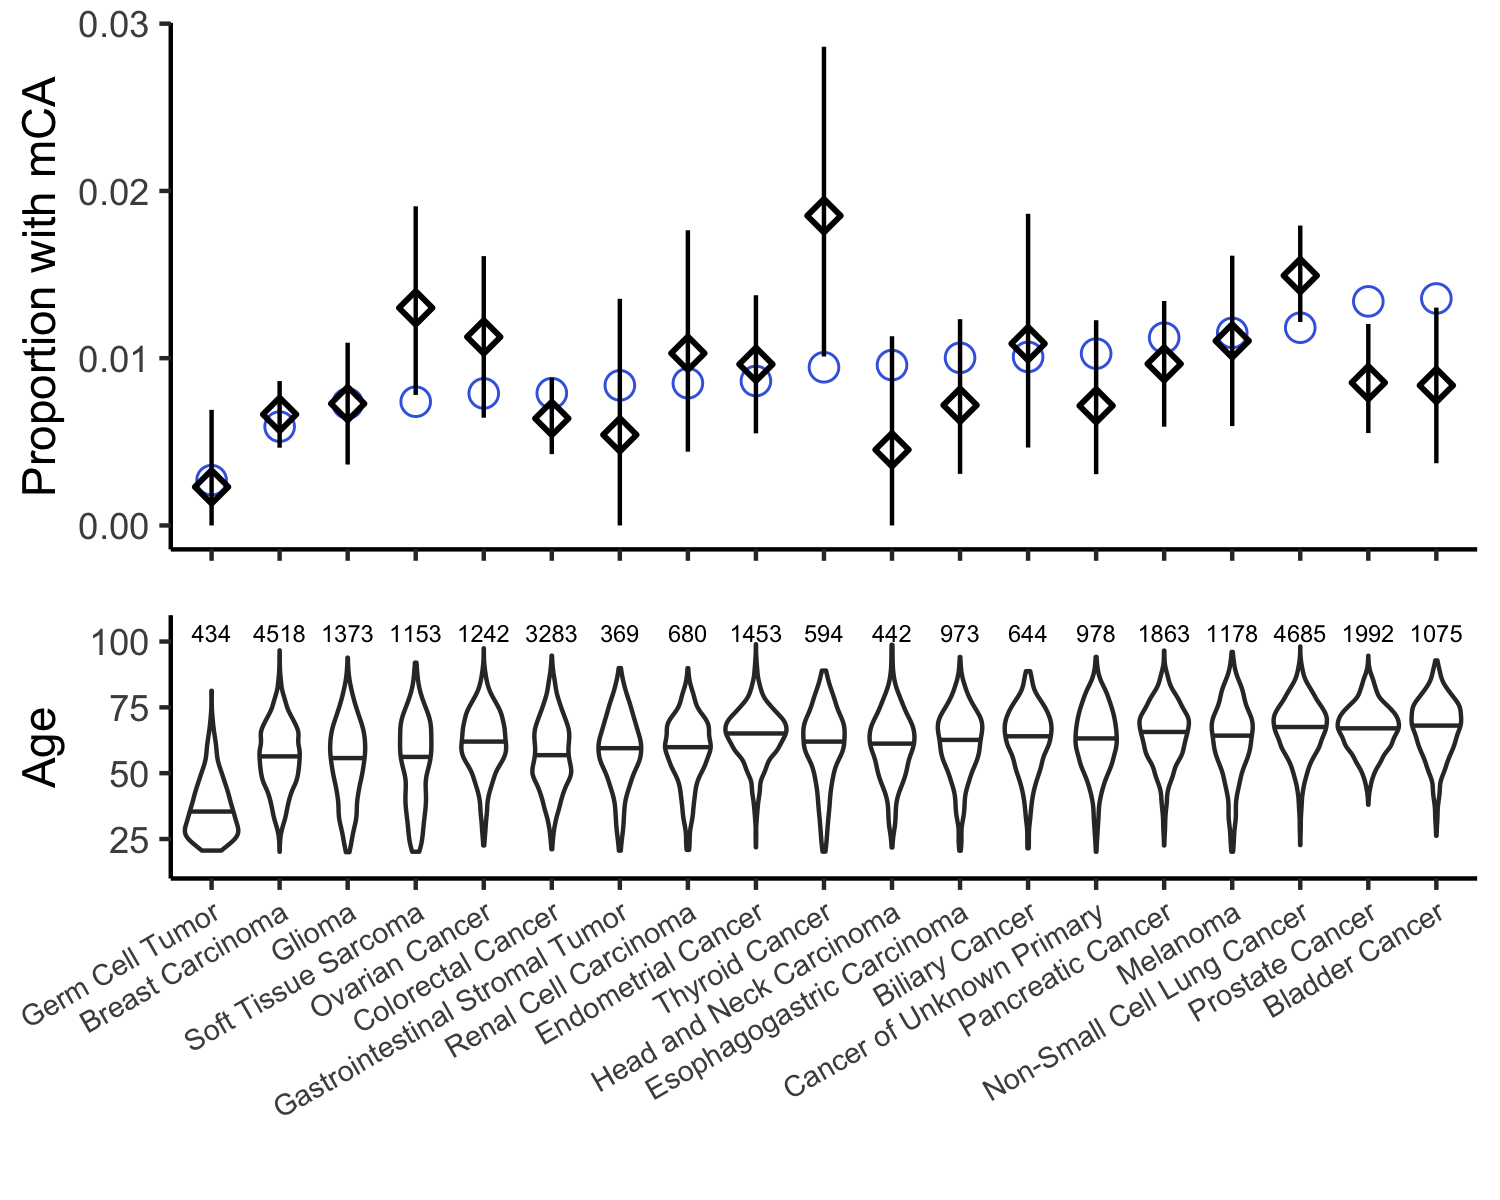

In [87]:
fit = glm(data = M_wide, formula = ch_cnv_auto ~ age + Gender + race_b, family = 'binomial')

D = M_wide %>%
    group_by(tumor_type) %>%
    summarise(
        cnv_freq = sum(ch_cnv_auto)/n(),
        cnv_count = sum(ch_cnv_auto),
        sm_freq = sum(ch_nonsilent)/n(),
        n_male = sum(Gender == 'Male'),
        loy_freq = sum(loy[Gender == 'Male'])/n_male,
        n = n(),
        age_median = median(age),
        cnv_freq_pred = sum(predict(fit, data.frame(age = age, Gender = Gender, race_b = race_b), type="response"))/n()
    ) %>%
    rowwise() %>%
    mutate(
        # (03/22/2021) 90% confidence interval - may be inexact!
        cnv_freq_lower = qbinom(p = 0.05, size = n, prob = cnv_freq)/n,
        cnv_freq_upper = qbinom(p = 0.95, size = n, prob = cnv_freq)/n,
        # (03/22/2021) uncomment below code to generate exact 95% intervals
#         cnv_freq_lower = binom.test(x = cnv_count, n = n, p = 0.5)$conf[1],
#         cnv_freq_upper = binom.test(x = cnv_count, n = n, p = 0.5)$conf[2]
    ) %>%
    rowwise() %>%
    filter(n > 300) %>%
    arrange(cnv_freq_pred) %>%
    mutate(tumor_type = factor(tumor_type, unique(tumor_type)))
    
D = D %>% 
    rowwise() %>%
    mutate(p = prop.test(x = cnv_count, n = n, p = cnv_freq_pred)$p.value) %>%
    mutate(
        q = p.adjust(p, method = 'BH'),
        q.stars = gtools::stars.pval(q)
    ) %>%
    ungroup()

coef = mean(D$sm_freq)/mean(D$cnv_freq)

p1 = D %>% 
    ggplot(
        aes()
    ) +
    theme_classic() +
    geom_point(
        inherit.aes = F,
        aes(x = tumor_type,
            y = cnv_freq_pred
        ),
        color = 'royalblue',
        pch = 21,
        size = 3
    ) +
    geom_pointrange(
        inherit.aes = F,
        aes(x = tumor_type,
            y = cnv_freq, 
            ymin = cnv_freq_lower, 
            ymax = cnv_freq_upper
        ),
        stat = 'identity',
        pch = 5
    ) +
    theme(
        axis.text.x = element_blank(),
        plot.margin = unit(c(0,0,0,0), 'mm')
    ) +
    xlab('') +
    ylab('Proportion with mCA')

give.n <- function(x){
  return(c(y = 100, label = length(x))) 
}

p2 = M_wide %>% filter(tumor_type %in% D$tumor_type) %>%
    mutate(tumor_type = factor(tumor_type, levels(D$tumor_type))) %>%
    ggplot(aes(x = tumor_type, y = age)) +
    theme_classic() +
    geom_violin(draw_quantiles = c(0.5)) +
    theme(
        axis.text.x = element_text(angle = 30, hjust = 1, size = 7),
        plot.margin = unit(c(0,0,0,0), 'mm')
    ) +
    xlab('') +
    stat_summary(fun.data = give.n, geom = "text", vjust = 0, size = 2) +
    scale_y_continuous(expand = expansion(add = 10)) +
    ylab('Age')

panel = p1/p2 + plot_layout(heights = c(2,1))

do_plot(panel, 'cancer_types.pdf', w = 5, h = 4)

In [78]:
options(repr.plot.width = 4, repr.plot.height = 2, repr.plot.res = 400)

sm_classes = M_long %>% pull(VariantClass2) %>% unique

colors = c(cnv_pal2, sm_pal) 

heme_colors = c(' ' = 'white', 'CLL' = 'royalblue', 'MDS' = 'tomato3', 'MPN' = 'purple', 'Lymphoma' = 'yellowgreen')

colors = c(colors, heme_colors)

gene_set = c(fread('../data/gene_set.tsv')$Gene, 'PPM1D', 'SRSF2')

# basically the same
gene_set = M_long %>% 
    filter(ch_nonsilent == 1) %>%
    filter(Gene %in% gene_set) %>%
    filter(dmp_patient_id %in% segs_filtered$dmp_patient_id) %>%
    count(Gene) %>% filter(n >= 2) %>% pull(Gene)

# gene_set = c('DNMT3A', 'TET2', 'JAK2', 'ASXL1', 'TP53', 'ATM', 'PPM1D', 'CHEK2',
#              'SRSF2', 'SF3B1', 'U2AF1', 'EZH2', 'MPL', 'NOTCH1', 'TERT', 'SUZ12', 'CBL')

chroms = segs_filtered %>% count(chrom) %>%
#     filter(n >= 4) %>% 
    pull(chrom)
# max_rows = 15
max_rows = 22

plots = list()

for (this_chrom in chroms) {
    
    chrom_label = ifelse(this_chrom == 23, 'X', this_chrom)

    segs_auto = segs_filtered %>% filter(chrom == this_chrom)

    M_co = rbind(
            M_long %>% 
            filter(Gene %in% gene_set) %>%
            filter(ch_nonsilent == 1) %>%
            filter(dmp_patient_id %in% segs_auto$dmp_patient_id) %>% 
            mutate(
                mutation = Gene,
                type = VariantClass2,
                arm = 'na',
                focality = 'na'
            ) %>%
            select(mutation, type, arm, focality, dmp_patient_id),
            segs_auto %>% 
            mutate(
                mutation = paste0(arm, type, focality)
            ) %>%
            select(mutation, type = type2, arm, focality, dmp_patient_id)
        ) %>%
        group_by(mutation) %>%
        mutate(mutation_n = n()) %>%
        ungroup()

    D = M_co %>%
        distinct(mutation, dmp_patient_id, `.keep_all` = T) %>%
        group_by(mutation) %>% mutate(mutation_n = n()) %>% ungroup() %>%
        arrange(type %in% sm_classes, desc(mutation_n)) %>%
        mutate(mutation = factor(mutation, rev(unique(mutation)))) %>%
        rowwise() %>%
        mutate(mut_weight = 2^which(mutation == levels(mutation))) %>%
        ungroup() %>%
        group_by(dmp_patient_id) %>% 
        mutate(patient_weight = sum(mut_weight)) %>%
        ungroup() %>%
        arrange(desc(patient_weight), type) %>%
        mutate(pid = as.integer(factor(dmp_patient_id, unique(dmp_patient_id))))
    
    D = D %>% arrange(desc(mutation)) %>%
        mutate(mutation = as.character(mutation)) %>%
        mutate(mutation = str_remove_all(mutation, 'amp|del|loh|broad|focal')) %>%
        mutate(mutation = factor(mutation, rev(unique(mutation))))
    
    n_rows = length(levels(D$mutation))
    n_cols = length(unique(D$pid))
    
    D = D %>% mutate(mutation = factor(mutation, c(as.character(1:(max_rows - n_rows)), levels(mutation))))
    nrows_sm = D %>% filter(type %in% sm_classes) %>% pull(mutation) %>% unique %>% length

    p = ggplot(
        D,
        aes(x = pid, y = mutation, fill = type)
    ) +
    geom_rect(
        xmin = 0, xmax = n_cols + 0.5, ymin = max_rows - n_rows + nrows_sm + 0.5, ymax = max_rows + 0.5,
        fill = 'whitesmoke',
    ) +
    geom_segment(
        aes(x = pid + 0.5, xend = pid + 0.5),
        y = max_rows - n_rows + 0.5,
        yend = max_rows + 0.5,
        color = 'gray90',
        size = 0.3
    ) +
    geom_hline(yintercept = max_rows - n_rows + nrows_sm + 0.5, size = 0.3, color = 'gray90') +
#     geom_hline(yintercept = max_rows + 0.5, size = 0.5, color = 'black') +
#     geom_hline(yintercept = max_rows - n_rows + 0.5, size = 0.5, color = 'black') +
    geom_segment(x = 0.5, xend = 0.5, y = max_rows - n_rows + 0.5, yend = max_rows + 0.5) +
    geom_rect(
        aes(
            xmin = pid - 0.4,
            xmax = pid + 0.4, 
            ymin = case_when(
                focality == 'focal' ~ as.numeric(mutation) - 0.1,
                arm == 'p' ~ as.numeric(mutation),
                type %in% sm_classes ~ as.numeric(mutation) - 0.45,
                T ~ as.numeric(mutation) - 0.45
            ),
            ymax = case_when(
                focality == 'focal' ~ as.numeric(mutation) + 0.1,
                arm == 'p' ~ as.numeric(mutation) + 0.45,
                arm == 'q' ~ as.numeric(mutation),
                arm == 'p,q' ~ as.numeric(mutation) + 0.45,
                type %in% sm_classes ~ as.numeric(mutation) + 0.45
            )
        ),
        size = 0, colour = "white"
    ) +
    # centromeres
    geom_point(
        data = D %>% filter((!type %in% sm_classes) & focality != 'focal'),
        aes(color = type),
        size = 1,
        show.legend = FALSE
    ) +
    theme_classic() +
    theme(
        axis.text.x = element_blank(),
        plot.margin = margin(t = 0, r = 1, b = 0, l = 0, unit = "mm"),
#         panel.spacing = unit(1,'cm'),
        axis.line = element_blank(),
        axis.ticks = element_blank(),
        legend.box = "horizontal",
        plot.title = element_text(size = 10)
    ) +
    guides(
        fill = guide_legend(ncol = 2, title = 'Variant Types'),
        color = FALSE
    ) +
    scale_fill_manual(
        values = colors
    ) +
    scale_color_manual(
        values = colors
    ) +
    scale_x_discrete(
        expand = expansion(add = 0.2)
    ) +
    scale_y_discrete(
        expand = expansion(add = 0.2),
        labels = str_remove_all(levels(D$mutation), 'broad|focal|del|del|loh|amp|^\\d+$'),
        drop = F
    ) +
    ggtitle(chrom_label) +
    ylab('') +
    xlab('')
    
    if (this_chrom != 14) {
        p = p + theme(legend.position = 'none')
    } else {
        p = p + theme(legend.position = 'right')
    }
    

    plots[[this_chrom]] = p
}

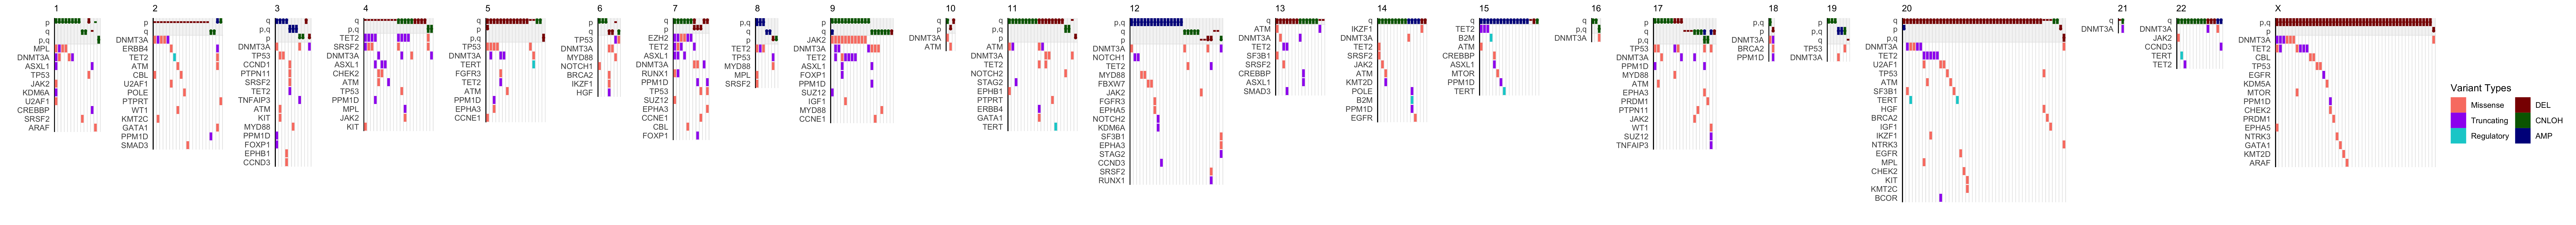

In [79]:
plots = plots[lengths(plots) != 0]

plot_widths = segs_filtered %>% 
    distinct(chrom, dmp_patient_id) %>%
    filter(chrom %in% chroms) %>% count(chrom) %>% pull(n)

panel = wrap_plots(plotlist = plots, widths = plot_widths, nrow = 1, guides = 'collect')

do_plot(panel, 'oncoplot.pdf', w = 40, h = 3.5)

## Genomic distribution

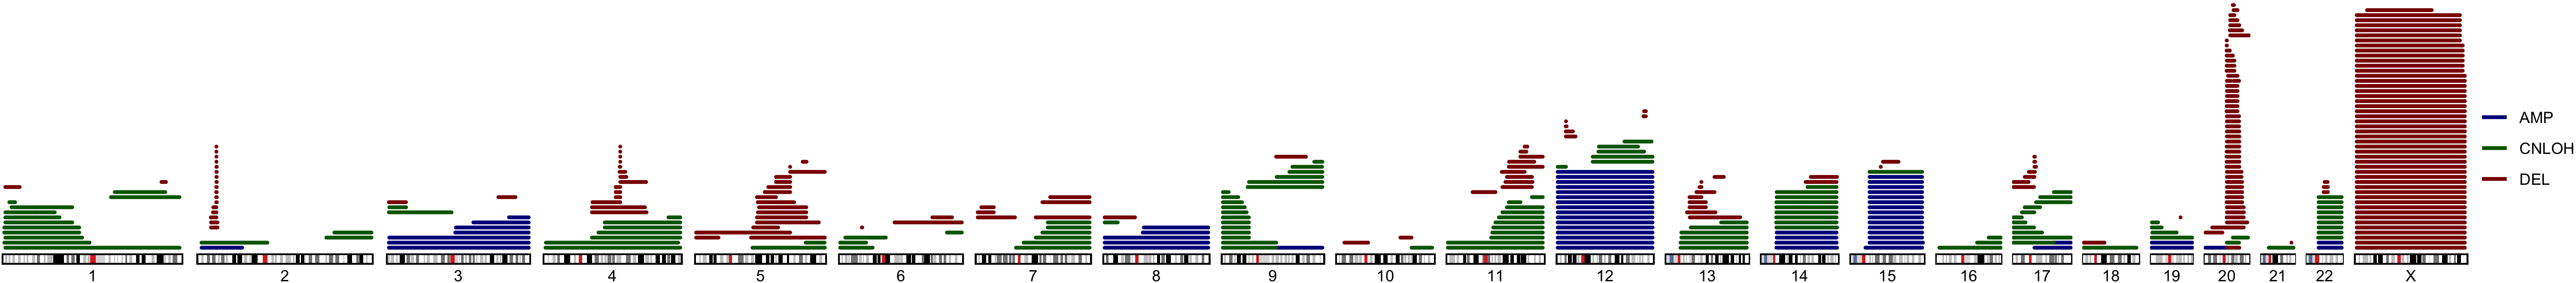

In [108]:
cytoband = fread('../data/cytoBand.txt') %>% setNames(c('chrom', 'start', 'end', 'name', 'stain'))

cytoband = cytoband %>% 
    mutate(chrom = str_remove(chrom, 'chr')) %>%
    mutate(chrom = ifelse(chrom == 'X', 23, chrom)) %>%
    filter(chrom != 'Y') %>%
    mutate(chrom = as.integer(chrom))

cyto_colors = c(
    'gpos100'= rgb(0/255.0,0/255.0,0/255.0),
    'gpos'   = rgb(0/255.0,0/255.0,0/255.0),
    'gpos75' = rgb(130/255.0,130/255.0,130/255.0),
    'gpos66' = rgb(160/255.0,160/255.0,160/255.0),
    'gpos50' = rgb(200/255.0,200/255.0,200/255.0),
    'gpos33' = rgb(210/255.0,210/255.0,210/255.0),
    'gpos25' = rgb(200/255.0,200/255.0,200/255.0),
    'gvar'   = rgb(220/255.0,220/255.0,220/255.0),
    'gneg'  = rgb(255/255.0,255/255.0,255/255.0),
    'acen'  = rgb(217/255.0,47/255.0,39/255.0),
    'stalk' = rgb(100/255.0,127/255.0,164/255.0)
)

window = 5e6

M_overlap = M_long %>%
    filter(dmp_patient_id %in% segs_filtered$dmp_patient_id) %>%
    rowwise() %>%
    filter(
        any(chrom == segs_filtered$chrom & dmp_patient_id == segs_filtered$dmp_patient_id &
            start >= segs_filtered$start - window & start <= segs_filtered$end + window)
    ) %>%
    ungroup() %>%
    mutate(VariantClass = case_when(
        VariantClass %in% c('Silent', 'Intron') ~ 'noncoding',
        T ~ 'coding'
    ))

p_segs = segs_filtered %>%
    mutate(chrom = factor(ifelse(chrom == 23, 'X', as.character(chrom)), chrom_levels)) %>%
    group_by(dmp_sample_id, chrom) %>%
    mutate(total_length = sum(size)) %>%
    mutate(type2 = factor(type2, c('AMP', 'CNLOH', 'DEL'))) %>%
    arrange(type2, round(start/1e7), -total_length) %>%
    group_by(chrom) %>%
    mutate(index = as.integer(factor(dmp_sample_id, unique(dmp_sample_id)))) %>% 
#     left_join(
#         M_overlap %>% select(dmp_patient_id, chrom, sm_pos = start, Gene, VariantClass, VAF_N),
#         by = c('chrom', 'dmp_patient_id')
#     ) %>%
    ungroup() %>%
    ggplot(
        aes(x = start, xend = end, y = index, yend = index, color = type2)
    ) +
    geom_rect(
        inherit.aes = F,
        data = chrom_lens %>% mutate(chrom = factor(ifelse(chrom == 23, 'X', as.character(chrom)), chrom_levels)),
        aes(xmin = 0, xmax = length, ymin = -2, ymax = -0.5),
        color = 'black',
        fill = 'white',
        size = 1
    ) +
    geom_rect(
        data = cytoband %>% mutate(chrom = factor(ifelse(chrom == 23, 'X', as.character(chrom)), chrom_levels)),
        inherit.aes = F,
        aes(xmin = start, xmax = end, ymin = -2, ymax = -0.5, fill = stain),
        size = 1,
        show.legend = FALSE
    ) +
    geom_segment(
        lineend = 'round',
        size = 1
    ) +
    scale_fill_manual(values = cyto_colors) +
    theme_void() +
    theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank(),
        legend.position = 'right',
        panel.spacing.y = unit(0, "lines"),
        plot.margin = unit(c(0,0,0,0), "lines"),
        strip.text.y = element_text(size = 10, hjust = 0.5, angle = 0),
        panel.border = element_blank(),
        strip.background = element_blank()
    ) +
    scale_y_discrete(expand = expansion(add = 1)) +
    scale_x_discrete(expand = c(0.02,0)) +
    facet_grid(.~chrom, space = 'free', scales = 'free', switch="both") +
    xlab('') +
    ylab('') +
    scale_color_manual(values = cnv_pal2) +
    labs(color = '')

do_plot(p_segs, 'genome_wide.pdf', w = 20, h = 2.2)

## CDRs

In [109]:
focal_dels = function(gene) {
    
    all_colors = c(
        'amp' = 'darkblue', 'loh' = 'darkgreen', 'del' = 'darkred',
        'Regulatory' = 'darkturquoise', 'Missense' = 'salmon', 'Truncating' = 'purple') 
    
    gene_structure = gene_structures %>% filter(str_detect(description, paste0('"', gene, '"')))

    gene_loc = gene_bed %>% 
        filter(Gene == gene) %>%
        as.data.frame(stringsAsFactors = F) %>%
        mutate(loc = as.integer((start + end) / 2), chrom = as.integer(chrom))

    this_chrom_lens = chrom_lens %>% filter(chrom == gene_loc$chrom)

    acen_chrom = acen %>% filter(chrom == gene_loc$chrom)

    D = segs_filtered %>%
        filter(type == 'del' & start < gene_loc$start + 5e6 & end > gene_loc$end - 5e6) %>%
        filter(chrom == gene_loc$chrom) %>%
        mutate(chrom = factor(chrom)) %>%
        group_by(dmp_sample_id, chrom) %>%
        mutate(total_length = sum(size)) %>%
        mutate(type = factor(type, c('amp', 'loh', 'del'))) %>%
        arrange(desc(type), round(start/1e7), -total_length) %>%
        group_by(chrom) %>%
        mutate(index = as.integer(factor(dmp_sample_id, unique(dmp_sample_id)))) %>%
        ungroup()

    p_segs = ggplot(
            D,
            aes(x = start, xend = end, y = index, yend = index, color = type)
        ) +
        geom_rect(
            inherit.aes = F,
            data = acen_chrom,
            aes(xmin = cen_start, xmax = cen_end, ymin = -Inf, ymax = Inf),
            color = 'gray',
            size = 0,
            alpha = 0.3
        ) +
        geom_segment(
            size = 1,
            alpha = 0.8,
            lineend = 'round'
        ) +
        geom_segment(
            inherit.aes = F,
            data = this_chrom_lens,
            aes(x = 0, xend = length, y = 0, yend = 0),
            alpha = 0,
            size = 0,
            color = 'white'
        ) +
        scale_alpha(
            range = c(0, 1)
        ) +
        theme_classic() +
        theme(
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            axis.title = element_blank(),
            legend.position = 'none',
            panel.spacing.y = unit(1, "mm"),
            plot.margin = unit(c(0.5,0.2,0.2,0.2), "lines"),
            strip.text.y = element_blank(),
            panel.border = element_rect(size = 0.2, fill = NA, color = 'gray'),
            strip.background = element_rect(size = 0.5, fill = 'seashell3', color = 'seashell3'),
            plot.title = element_text(size = 7)
        ) +
        scale_y_discrete(expand = expansion(add = 1)) +
        xlab('') +
        ylab('') +
        scale_color_manual(values = all_colors) +
        ggtitle(paste0(gene, ', ', 'chr', gene_loc$chrom)) +
        # exon structures
        geom_segment(
            inherit.aes = F,
            data = gene_structure %>% mutate(zoom = TRUE),
            aes(x = min(start), xend = max(end), y = -1, yend = -1),
            size = 0.1,
            color = 'black'
        ) +
        geom_segment(
            inherit.aes = F,
            data = gene_structure %>% mutate(zoom = TRUE),
            aes(x = start, xend = end, y = -1, yend = -1),
            size = 2,
            color = 'black'
        ) +
        facet_zoom(
            zoom.size = 1,
            zoom.data = zoom,
            xlim = c(gene_loc$start, gene_loc$end)
        )

    p_segs
}

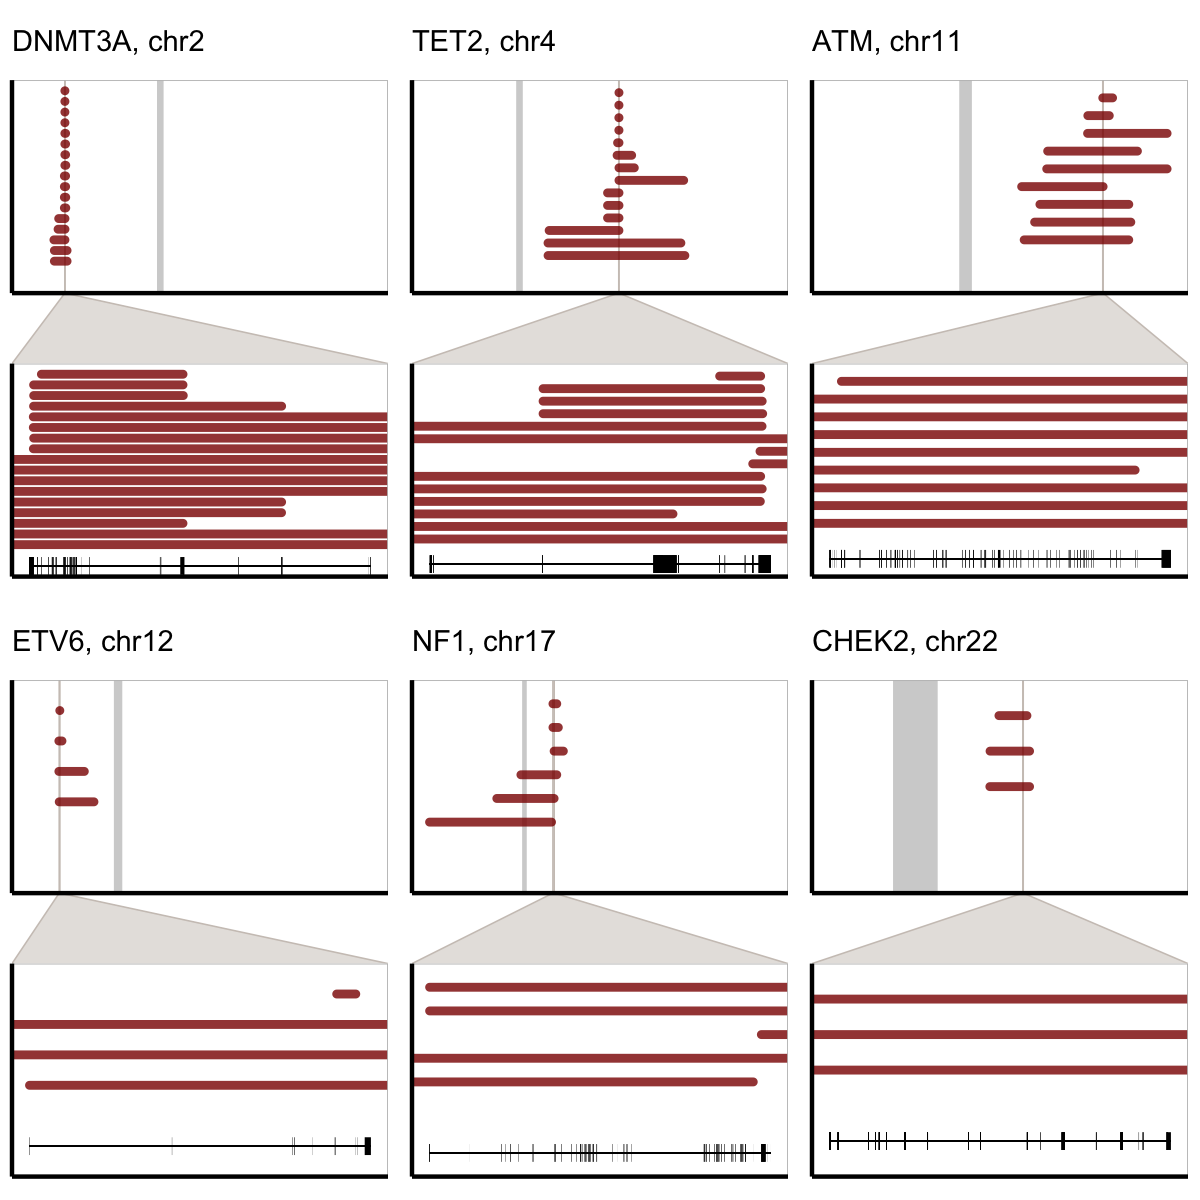

In [110]:
focal_genes = c('DNMT3A', 'TET2', 'ATM', 'ETV6', 'NF1', 'CHEK2')

plots = list()

for (gene in focal_genes) {
    plots[[gene]] = focal_dels(gene)
}

p_focal = plot_grid(plotlist = plots, nrow = 2)

do_plot(p_focal, 'focal_del.pdf', w = 4, h = 4)

## Co-localization

In [5]:
window = 5e6

segs_filtered_auto = segs_filtered %>% filter(chrom != 23)

M_overlap = M_long %>%
    filter(dmp_patient_id %in% segs_filtered_auto$dmp_patient_id) %>%
    rowwise() %>%
    mutate(
        locality = ifelse(
            any(chrom == segs_filtered_auto$chrom & dmp_patient_id == segs_filtered_auto$dmp_patient_id &
                start >= segs_filtered_auto$start - window & start <= segs_filtered_auto$end + window
            ),
            'cis',
            'trans'
        )
    ) %>%
    ungroup() %>%
    mutate(variant_type = case_when(
        VariantClass %in% c('Silent', 'Intron') ~ 'noncoding',
        T ~ 'coding'
    ))

perm = fread('../data/permutation.tsv', sep = '\t')

# perm = data.frame()

# for (i in 1:2000) {
    
#     if (i %% 500 == 0) {
#         display(i)
#     }
    
#     res = M_overlap %>%
#         mutate(dmp_patient_id = sample(dmp_patient_id)) %>%
#         rowwise() %>%
#         mutate(
#             locality = ifelse(
#                 any(chrom == segs_filtered_auto$chrom & dmp_patient_id == segs_filtered_auto$dmp_patient_id &
#                     start >= segs_filtered_auto$start - window & start <= segs_filtered_auto$end + window
#                 ),
#                 'cis',
#                 'trans'
#             )
#         ) %>%
#         ungroup() %>%
#         group_by(variant_type) %>%
#         summarise(
#             prop_cis = sum(locality == 'cis')/n(),
#             .groups = 'drop'
#         ) %>%
#         mutate(i = i)
    
#     perm = perm %>% rbind(res)
# }

In [6]:
prop_cis_coding = M_overlap %>% filter(variant_type == 'coding') %>% pull(locality) %>% {sum(. == 'cis')/length(.)}
prop_cis_noncoding = M_overlap %>% filter(variant_type == 'noncoding') %>% pull(locality) %>% {sum(. == 'cis')/length(.)}
prop_coding_nonrecurrent = M_overlap %>%
    filter(variant_type == 'coding') %>%
    filter(!Gene %in% c('MPL', 'DNMT3A', 'TET2', 'EZH2', 'JAK2', 'ATM', 'TP53')) %>% 
    pull(locality) %>% {sum(. == 'cis')/length(.)}
    
prop_cis_coding %>% paste('cis coding')
prop_coding_nonrecurrent %>% paste('cis coding non recurrent')
prop_cis_noncoding %>% paste('cis noncoding')

[1] "0.150793650793651 cis coding"

[1] "0.0380952380952381 cis coding non recurrent"

[1] "0.0214285714285714 cis noncoding"

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



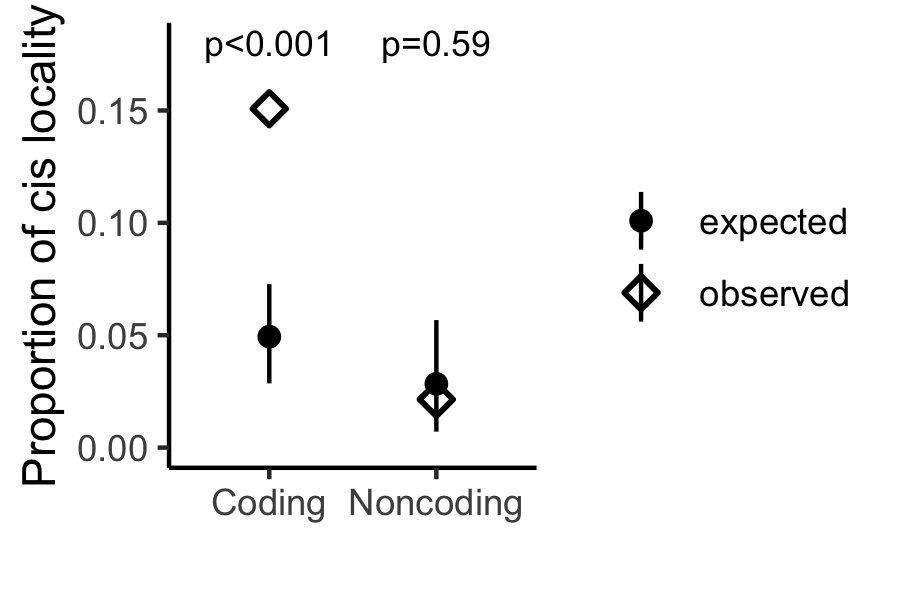

In [7]:
p_coding = perm %>% filter(variant_type == 'coding') %>% pull(prop_cis) %>% {sum(. > prop_cis_coding)/length(.)}
p_noncoding = perm %>% filter(variant_type == 'noncoding') %>% pull(prop_cis) %>% {sum(. > prop_cis_noncoding)/length(.)}

D = M_overlap %>% 
    group_by(variant_type) %>%
    summarise(
        prop_cis_median = sum(locality == 'cis')/n()
    ) %>%
    mutate(
        prop_cis_lower = prop_cis_median, 
        prop_cis_upper = prop_cis_median,
        estimate = 'observed'
    ) %>%
    rbind(
        perm %>% 
        group_by(variant_type) %>%
        summarise(
            prop_cis_lower = quantile(prop_cis, c(.025))[1],
            prop_cis_upper = quantile(prop_cis, c(.975))[1],
            prop_cis_median = median(prop_cis)
        ) %>%
        mutate(
            estimate = 'expected'
        )
    ) %>%
    mutate(
        variant_type = Hmisc::capitalize(variant_type)
    )


p_perm = ggplot(
        D,
        aes(x = variant_type, y = prop_cis_median, ymin = prop_cis_lower, ymax = prop_cis_upper, pch = estimate)
    ) +
    geom_pointrange() +
    theme_classic() +
    scale_shape_manual(values=c(16, 5)) +
    theme(legend.position = 'right') +
    ylab('Proportion of cis locality') +
    ylim(0, 0.18) +
    xlab('') +
    # stat_compare_means(
    #     comparisons = list(c('coding', 'noncoding')),
    #     label.y = 0.14,
    #     size = 0
    # )
    annotate('text', x = 1, y = 0.18, label = glue('p<0.001'), size = 3) +
    annotate('text', x = 2, y = 0.18, label = glue('p={signif(p_noncoding, 2)}'), size = 3) +
    theme(legend.title = element_blank())

do_plot(p_perm, 'permutation.pdf', w = 3, h = 2)

## general characterstics

In [132]:
options(repr.plot.width = 4, repr.plot.height = 2.5, repr.plot.res = 300)

p_dev = ggplot(
  segs_filtered,
  aes(x = valor, y = cnlr, color = type)
) +
scale_color_manual(values = cnv_pal) +
# geom_hline(yintercept = 0, linetype = 'dashed', alpha = 0.8, color = 'darkgreen') +
geom_point(pch = 21, stroke = 0.5) +
scale_x_continuous(limits = c(0, 2.5), expand = c(0,0)) +
scale_y_continuous(limits = c(-1, 0.6), expand = c(0,0)) +
theme_classic() +
theme(
    legend.position = 'none',
    axis.title = element_text(size = 8)
) +
# geom_text(size = 2) +
geom_line(
  inherit.aes = F,
  data = del_line,
  aes(x = valor, y = cnlr),
  linetype = 'dashed', alpha = 0.8, color = 'darkred'
) +
geom_line(
  inherit.aes = F,
  data = amp_line,
  aes(x = valor, y = cnlr),
  linetype = 'dashed', alpha = 0.8, color = 'darkblue'
) +
geom_line(
  inherit.aes = F,
  data = loh_line,
  aes(x = valor, y = cnlr),
  linetype = 'dashed', alpha = 0.8, color = 'darkgreen'
) +
xlab('logOR') +
ylab('logR') + 
annotate('text', x = 0.9, y = 0.5, label = 'AMP', color = cnv_pal['amp'], size = 3) +
annotate('text', x = 2.1, y = 0.2, label = 'CNLOH', color = cnv_pal['loh'], size = 3) +
annotate('text', x = 2, y = -0.5, label = 'DEL', color = cnv_pal['del'], size = 3)

In [133]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 300)

p_age = ggplot(
    M_wide %>% 
        mutate(age_bin = cut(age, c(0, seq(40, 80, 10), 100))) %>%
        group_by(age_bin) %>%
        summarise(
            prop_ch_cnv = sum(ch_cnv)/n(),
            prop_ch_cnv_auto = sum(ch_cnv_auto)/n(),
            prop_both_ch = sum(ch_cnv & ch_nonsilent)/n(),
            n = n()
        ),
    aes(x = age_bin, y = prop_ch_cnv, group = '1')
) +
geom_line() +
theme_classic() +
geom_point() +
ylim(0, 0.04) +
theme(
    axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1, size = 8),
    axis.title = element_text(size = 8)
) +
ylab('Proportion with mCA')

`summarise()` ungrouping output (override with `.groups` argument)



In [134]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 300)

give.min <- function(x){
  return(c(y = min(x), label = min(x))) 
}

p_phi = ggplot(
        segs_filtered,
        aes(x = type2, y = phi, fill = type2, color = type2)
    ) +
#     geom_hline(yintercept = 0.1, linetype = 'dashed', color = 'gray', size = 0.5, alpha = 0.8) +
    geom_violin(size = 0.3, position = position_dodge(width = 0.75), alpha = 0.2, scale = 'width') +
    theme_classic() +
    geom_quasirandom(width = 0.1, method = 'smiley', size = 0.5) +
    scale_fill_manual(values = cnv_pal2) +
    scale_color_manual(values = cnv_pal2) +
    ylim(0,NA) +
    theme(
        legend.position = 'none',
        axis.title = element_text(size = 8),
        axis.text.x = element_text(size = 8, angle = 30, hjust = 1, vjust = 1)
    ) +
    ylab('Aberrant cell fraction') +
    xlab('Event type') +
    stat_summary(fun.data = give.min, geom = "text", vjust = 1.5, size = 2.5)

In [136]:
options(repr.plot.width = 1.5, repr.plot.height = 2, repr.plot.res = 300)

p_n = ggplot(
        segs_filtered %>% group_by(dmp_sample_id) %>% mutate(n_sample = n()) %>%
        ungroup %>% count(n_sample, active_heme, type) %>% mutate(n = n/n_sample) %>%
            mutate(n_sample = case_when(
                n_sample < 3 ~ as.character(n_sample), T ~ '3+')),
        aes(x = n_sample, y = n, fill = type)
    ) +
    theme_classic() +
    geom_bar(stat = 'identity', position = 'stack') +
    scale_fill_manual(values = cnv_pal) +
    theme(
        legend.position = 'none',
        axis.title = element_text(size = 8)
    ) +
    xlab('Events per sample')

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6 row(s) containing missing values (geom_path).”


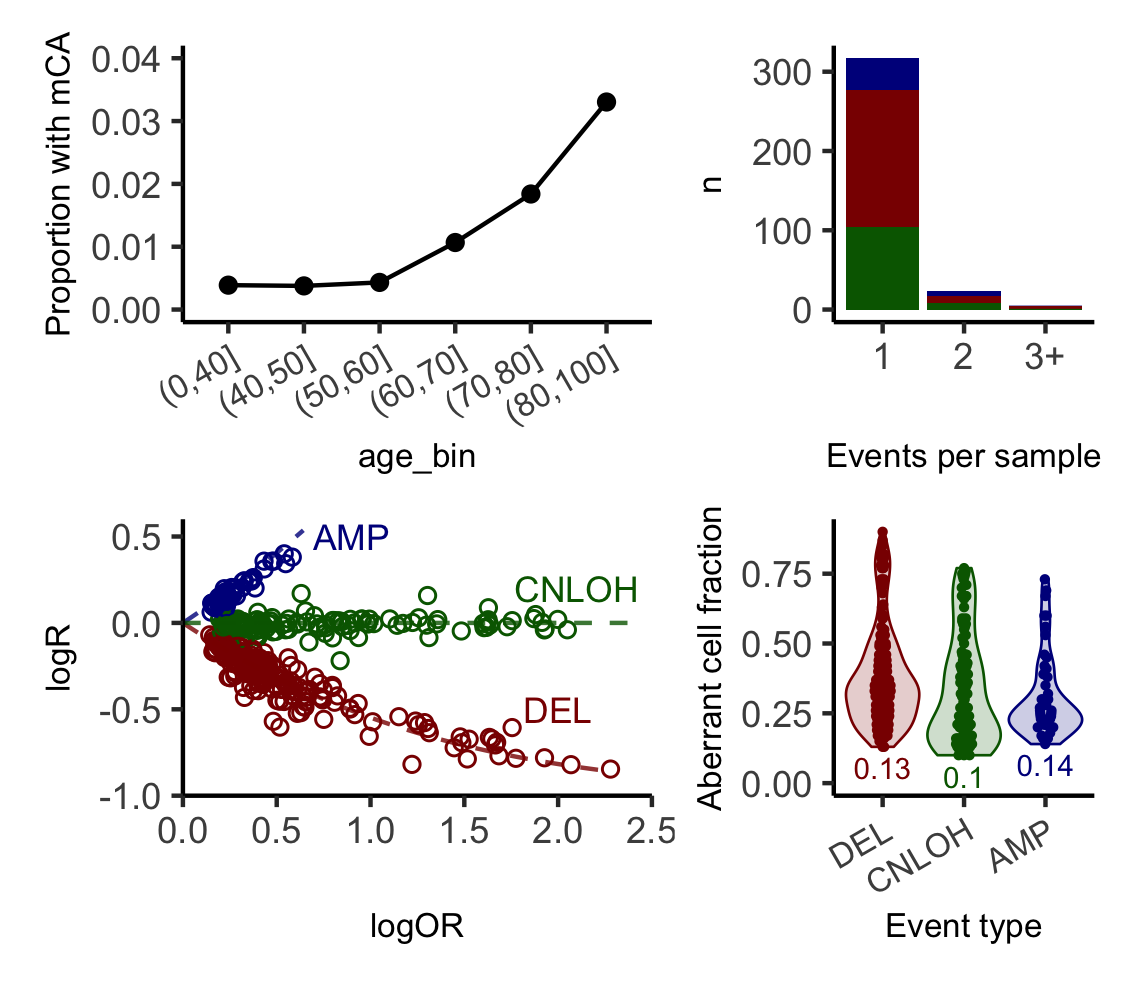

In [137]:
panel = p_age + p_n + p_dev + p_phi + plot_layout(widths = c(1.8,1))

do_plot(panel, 'ai_general.pdf', w = 3.8, h = 3.3)

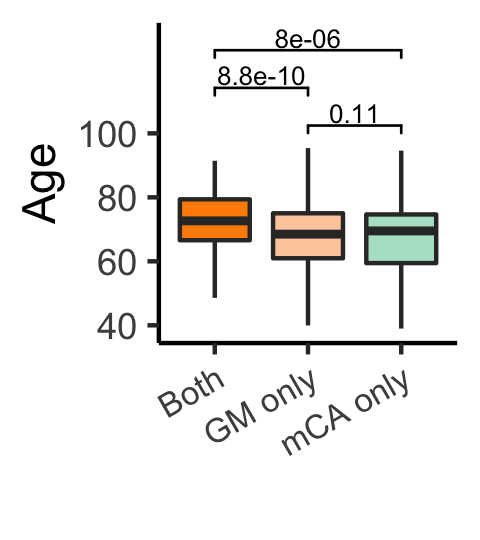

In [121]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 300)

pval = 0.01
label_size = 8

p_mutnum = ggplot(
    M_wide %>% 
        mutate(mutnum_silent = mutnum_silent + mutnum_intronic) %>%
        mutate(ch_cnv = ifelse(ch_cnv == 1, 'mCA+', 'mCA-')) %>%
        reshape2::melt(
            measure.vars = c('mutnum_all', 'mutnum_nonsilent', 'mutnum_silent'),
            variable.name = 'mutation_type',
            value.name = 'mutnum'
        ) %>%
        filter(mutation_type == 'mutnum_all') %>%
        mutate(mutnum = ifelse(mutnum >= 3, '3+', as.character(mutnum))) %>%
        count(ch_cnv, mutnum, mutation_type) %>%
        group_by(ch_cnv) %>%
        mutate(prop = n/sum(n)) %>%
        ungroup() %>%
        filter(mutnum > 0),
    aes(x = ch_cnv, y = prop, fill = mutnum)
) +
geom_col(color = 'black', size = 0.2) +
theme_classic() +
scale_fill_manual(values = scales::seq_gradient_pal("white", sm_col)(c(0.3, 0.6, 1))) +
scale_y_continuous(expand = expansion(add = 0.05), limits = c(0,0.85)) +
stat_compare_means(
    comparisons = list(c('mCA+', 'mCA-')),
    label.y = 0.8,
    size = 0,
    method = 't.test'
) +
annotate('text', x = 1.5, y = 0.8, label = '****', size = 3) +
xlab('') +
theme(
    legend.key.size = unit(3, 'mm'),
    legend.title = element_text(size = 7),
    legend.position = 'top',
    legend.spacing = unit(0,'mm'),
    axis.text.x = element_text(size = 8, angle = 30, hjust = 1)
) +
guides(fill = guide_legend(title.position = "top"))

p_vaf = ggplot(
        M_wide %>% 
            rowwise() %>% mutate(VAF_silent = max(VAF_silent, VAF_intronic)) %>% ungroup() %>%
            mutate(ch_cnv = ifelse(ch_cnv == 1, 'mCA+', 'mCA-')) %>%
            reshape2::melt(
                measure.vars = c('VAF_all', 'VAF_nonsilent', 'VAF_silent'),
                variable.name = 'mutation_type',
                value.name = 'VAF'
            ) %>% 
            filter(VAF > 0 & VAF < 0.5 & mutation_type == 'VAF_all'),
        aes(x = ch_cnv, y = VAF, fill = ch_cnv)
    ) +
    geom_violin(draw_quantiles = c(0.5)) +
    theme_classic() +
    stat_compare_means(
        size = 2.5,
        method = 't.test', 
        label = 'p.signif', 
        comparisons = list(c('mCA+', 'mCA-'))) +
    ylim(0,0.55) +
    theme(
        axis.text.x = element_text(size = 8, angle = 30, hjust = 1),
        legend.position = 'none'
    ) +
    xlab('') +
    scale_fill_manual(values = c(cnv_col, 'gainsboro'))

D = M_wide %>%
    mutate(ch_status = case_when(
        ch_cnv & ch_nonsilent ~ 'Both',
        ch_cnv == 1 ~ 'mCA only',
        ch_nonsilent == 1 ~ 'GM only',
        T ~ 'none'
    )) %>%
    group_by(ch_status) %>%
    mutate(n = n()) %>%
    ungroup() %>%
    filter(ch_status != 'none')


give.n <- function(x){
  return(c(y = min(x), label = length(x))) 
}

p_age = ggplot(
        D,
        aes(x = ch_status, y = age, fill = ch_status)
    ) +
#     geom_violin(draw_quantiles = c(0.5)) +
    geom_boxplot(outlier.alpha = 0) +
    theme_classic() +
    stat_compare_means(
        comparisons = list(
            c('mCA only', 'GM only'),
            c('Both', 'GM only'),
            c('mCA only', 'Both')
        ),
        size = 2.2,
        method = 't.test', label = 'p.value',
        vjust = 0,
        step.increase = 0.15
    ) +
#     ylim(39, 130) +
    theme(
#         plot.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "pt"),
#         axis.title.x = element_blank()
        axis.text.x = element_text(size = 8, angle = 30, hjust = 1),
        legend.position = 'none'
    ) +
    xlab('') +
    scale_fill_manual(values = c('mCA only' = cnv_col, 'Both' = 'darkorange', 'GM only' = sm_col)) +
    ylab('Age') + coord_cartesian(ylim=c(39, 130))  + scale_y_continuous(breaks = seq(40,110,20), labels=c("40" = "40", "60" = "60",
                              "80" = "80", "100" = "100"))

do_plot(p_age, 'age_pvalue.pdf', w = 1.6, h = 1.8)

`summarise()` regrouping output by 'age_bin' (override with `.groups` argument)



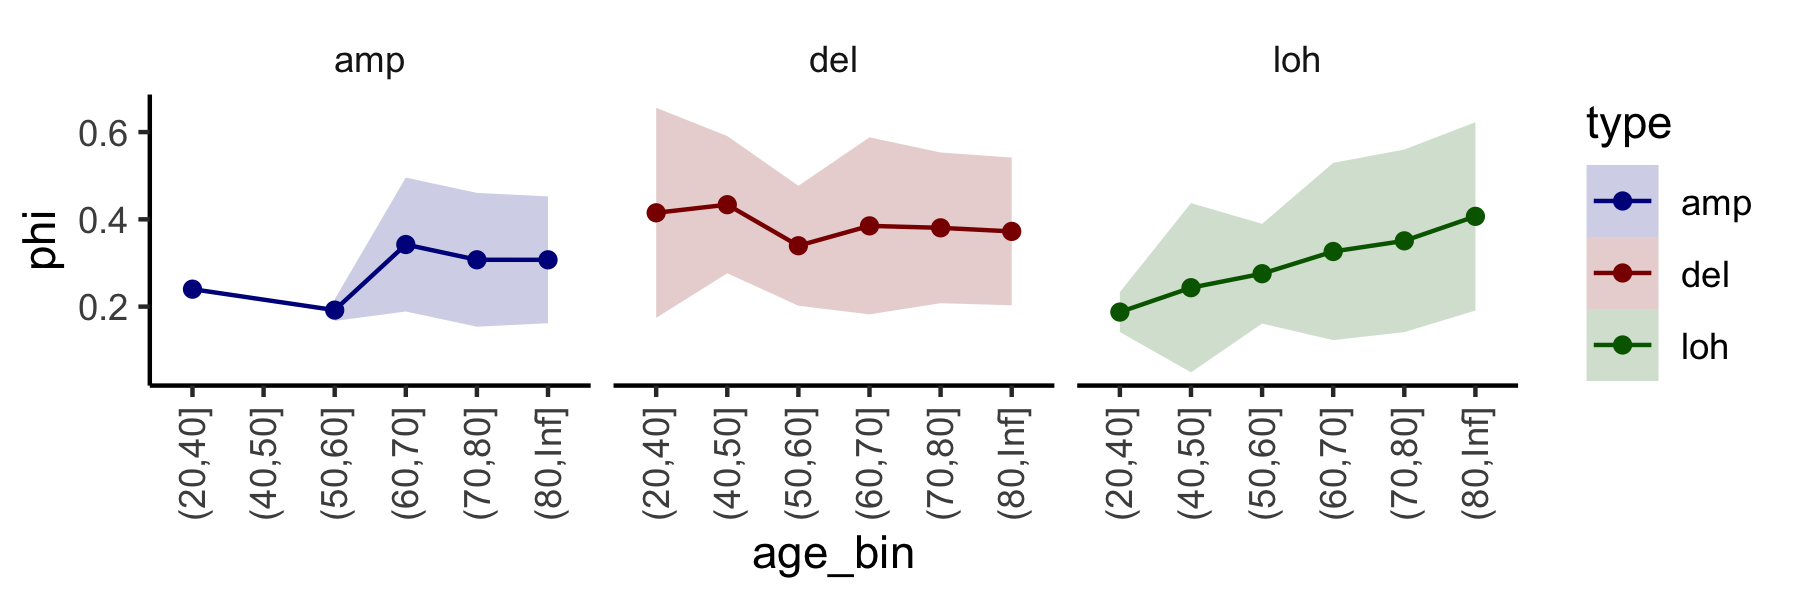

In [122]:
options(repr.plot.width = 6, repr.plot.height = 2, repr.plot.res = 300)

ggplot(
    segs_filtered %>% 
        mutate(age_bin = cut(age, c(20, seq(40, 80, 10), Inf))) %>%
        group_by(age_bin, type) %>%
        summarise(
            ci_lower = mean(phi) - sd(phi),
            ci_upper = mean(phi) + sd(phi),
            phi = mean(phi),
            n = n()
        ),
    aes(x = age_bin, y = phi, ymin = ci_lower, ymax = ci_upper, group = type, color = type, fill = type)
) +
geom_line() +
theme_classic() +
geom_point() +
# geom_errorbar(size = 0.5, width = 0.1) +
geom_ribbon(alpha = 0.2, size = 0) +
scale_color_manual(values = c('loh' = 'darkgreen', 'amp' = 'darkblue', 'del' = 'darkred', 'err' = 'gray')) +
scale_fill_manual(values = c('loh' = 'darkgreen', 'amp' = 'darkblue', 'del' = 'darkred', 'err' = 'gray')) +
facet_wrap(~type) +
theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5),
    strip.background = element_blank()
)

# Comparison with other studies

In [138]:
segs_laurie = fread('../data/external/segs_laurie.txt')

segs_laurie = segs_laurie %>% 
    mutate(
        size = length * 1e6,
        type = c('aupd' = 'loh', 'gain' = 'amp', 'loss' = 'del')[mosaic.type],
        start = `Start (GRCh37)`,
        end = `End (GRCh37)`,
        chrom = chromosome,
        patient_id = as.character(subject.id)
    ) %>%
    mutate(n_total = 50222)

segs_loh = fread('../data/external/segs_loh.txt') %>%
    filter(COPY_CHANGE != 'undetermined') %>%
    mutate(
        chrom = as.integer(ifelse(CHR == 'X', 23, CHR)),
        size = SIZE_MB * 1e6,
        start = `Start (GRCh37)`,
        end = `End (GRCh37)`,
        type = c('neutral' = 'loh', 'loss' = 'del', 'gain' = 'amp')[COPY_CHANGE],
        phi = as.numeric(CELL_FRAC),
        patient_id = as.character(ID)
    ) %>%
    mutate(n_total = 151202)

segs_jacobs = fread('../data/external/segs_jacobs.txt') %>%
    mutate(
        chrom = CHROM,
        start = `Start (GRCh37)`,
        end = `End (GRCh37)`,
        size = SEG_SIZE,
        type = c('NEUTRAL' = 'loh', 'LOSS' = 'del', 'GAIN' = 'amp')[STATE],
        phi = PROPORTION_ABNORMAL,
        patient_id = as.character(ID)
    ) %>%
    mutate(n_total = 31717 + 26136)

segs_machiela = fread('../data/external/segs_machiela.txt') %>%
    mutate(
        chrom = as.integer(CHR),
        start = `Start (GRCh37)`,
        end = `End (GRCh37)`,
        size = SEG_SIZE,
        type = c('Neutral' = 'loh', 'Loss' = 'del', 'Gain' = 'amp')[STATE],
        phi = PERCENT,
        age = as.numeric(AGE),
        patient_id = as.character(ID)
    ) %>%
    select(-AGE, -CHR) %>%
    filter(!is.na(type)) %>%
    mutate(n_total = 24849)
    
segs_all = bind_rows(
        segs_filtered %>% mutate(study = 'This study') %>%
            mutate(n_total = 32444) %>%
            mutate(patient_id = dmp_patient_id),
        segs_loh %>% mutate(study = 'Loh'),
        segs_laurie %>% mutate(study = 'Laurie'),
        segs_jacobs %>% mutate(study = 'Jacobs'),
        segs_machiela %>% mutate(study = 'Machiela')
    ) %>% 
    mutate(study_label = paste0(study, '\n(n=', n_total, ')')) %>%
    mutate(study_label = factor(study_label, unique(study_label))) %>%
    mutate(study = factor(study, unique(study))) %>%
    mutate(type2 = factor(c('del' = 'DEL', 'loh' = 'CNLOH', 'amp' = 'AMP')[type], c('DEL', 'CNLOH', 'AMP')))

Warning message:
“Removed 7 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 234 rows containing missing values (geom_violin).”
Warning message:
“Removed 7 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 234 rows containing missing values (geom_violin).”


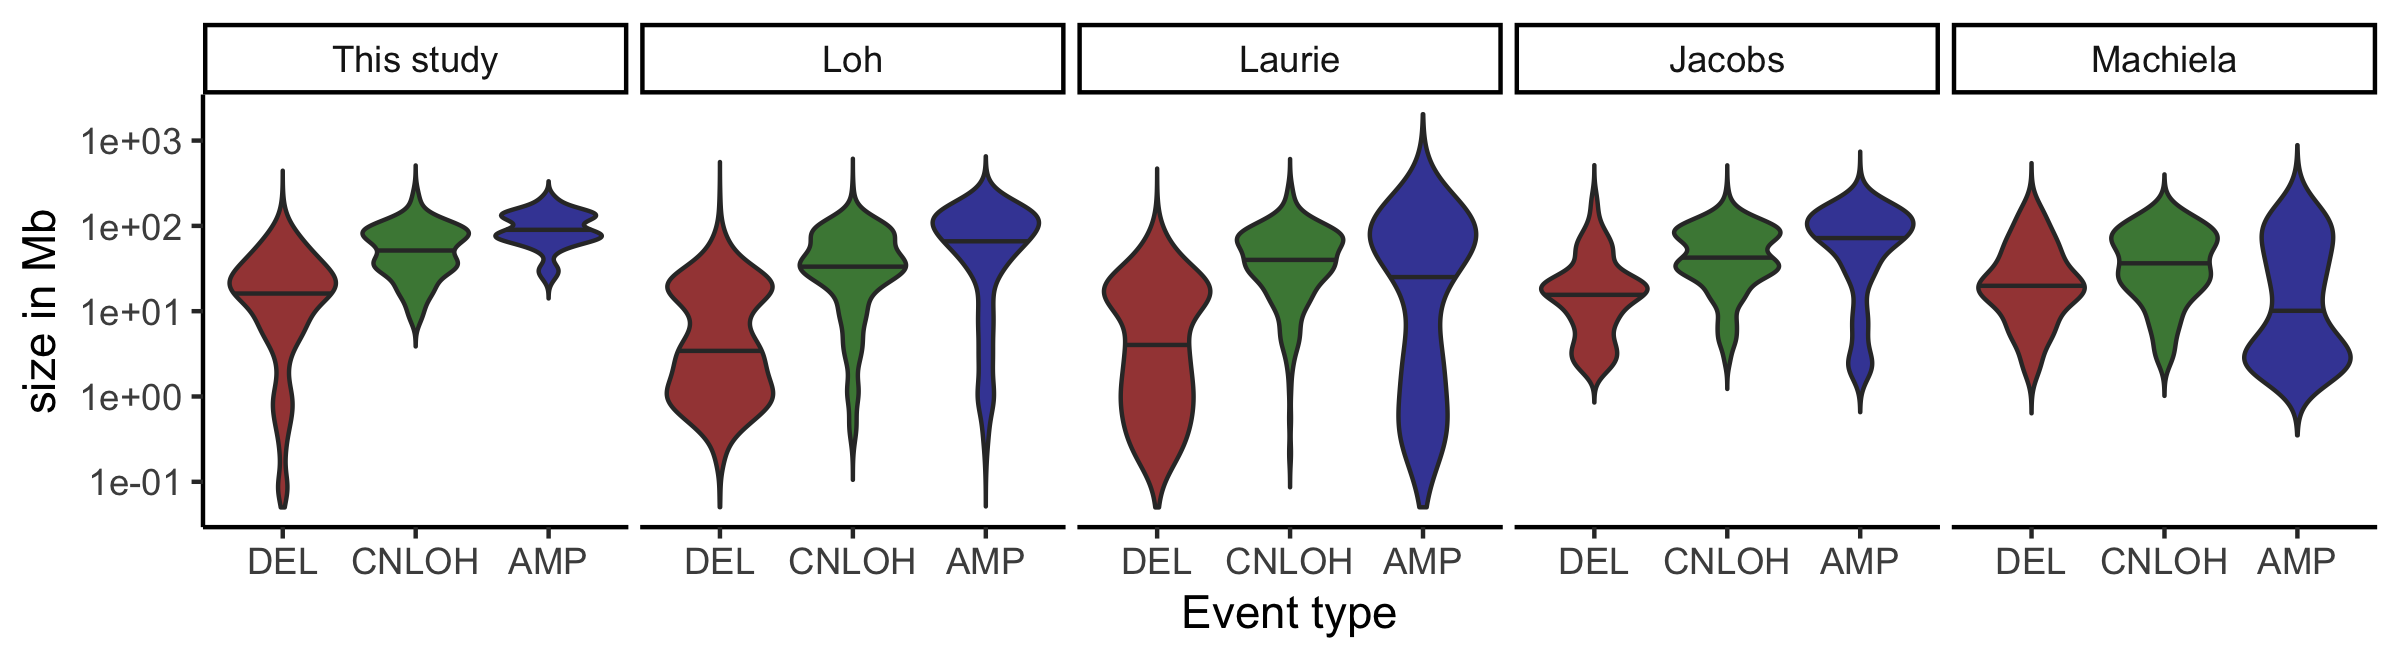

In [141]:
give.n <- function(x){
  return(c(y = max(x), label = length(x))) 
}

p = segs_all %>%
    mutate(size = size/1e6) %>%
    filter(chrom != '23') %>%
    filter(phi >= 0.1 | is.na(phi)) %>%
    ggplot(
        aes(x = type2, y = size, fill = type2)
    ) +
    geom_violin(alpha = 0.8, trim = F, draw_quantiles = c(0.5), scale = 'width', width = 0.8) +
    theme_classic() +
    scale_fill_manual(values = cnv_pal2) +
    scale_color_manual(values = cnv_pal2) +
    scale_y_continuous(trans = 'log10', limits = c(0.05, NA)) +
    facet_wrap(~study, nrow = 1) +
    # stat_summary(fun.data = give.n, geom = "text", hjust = 1.5, vjust = -1, size = 2.5) +
    theme(panel.spacing = unit(1, 'mm'), legend.position = 'none') +
    ylab('size in Mb') +
    xlab('Event type')

do_plot(p, 'size.pdf', w = 8, h = 2.2)

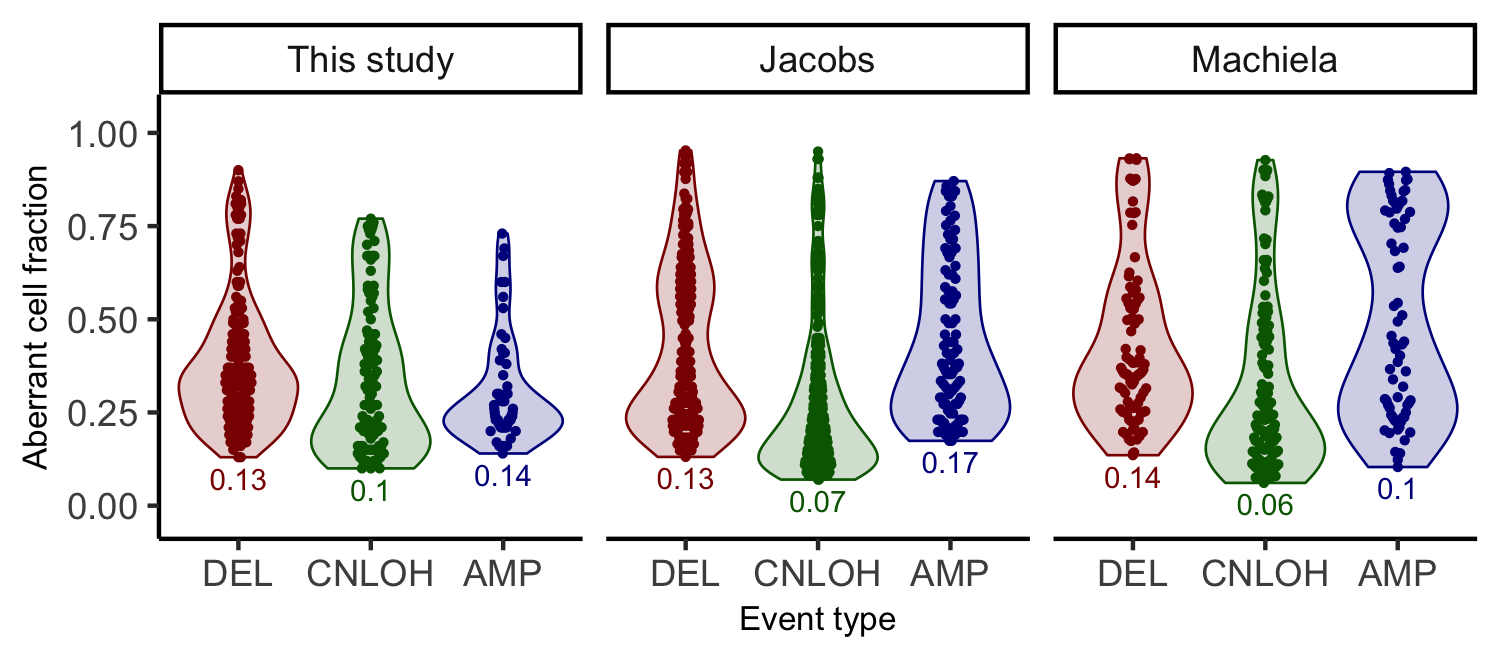

In [142]:
give.min <- function(x){
  return(c(y = min(x), label = round(min(x), 2))) 
}

p = segs_all %>%
    filter(!is.na(phi)) %>%
    filter(study != 'Loh') %>%
    ggplot(
        aes(x = type2, y = phi, fill = type2, color = type2)
    ) +
    geom_violin(size = 0.3, position = position_dodge(width = 0.75), alpha = 0.2, scale = 'width') +
    theme_classic() +
    geom_quasirandom(width = 0.1, method = 'smiley', size = 0.5) +
    scale_fill_manual(values = cnv_pal2) +
    scale_color_manual(values = cnv_pal2) +
    scale_y_continuous(expand = expansion(add = 0.15)) +
    theme(
        axis.title = element_text(size = 8)
    ) +
    # scale_y_continuous()
    ylab('Aberrant cell fraction') +
    xlab('Event type') +
    stat_summary(fun.data = give.min, geom = "text", vjust = 1.5, size = 2.5) +
    facet_wrap(~study, nrow = 1) +
    theme(panel.spacing = unit(2, 'mm'), legend.position = 'none')

do_plot(p, 'cell_frac.pdf', w = 5, h = 2.2)

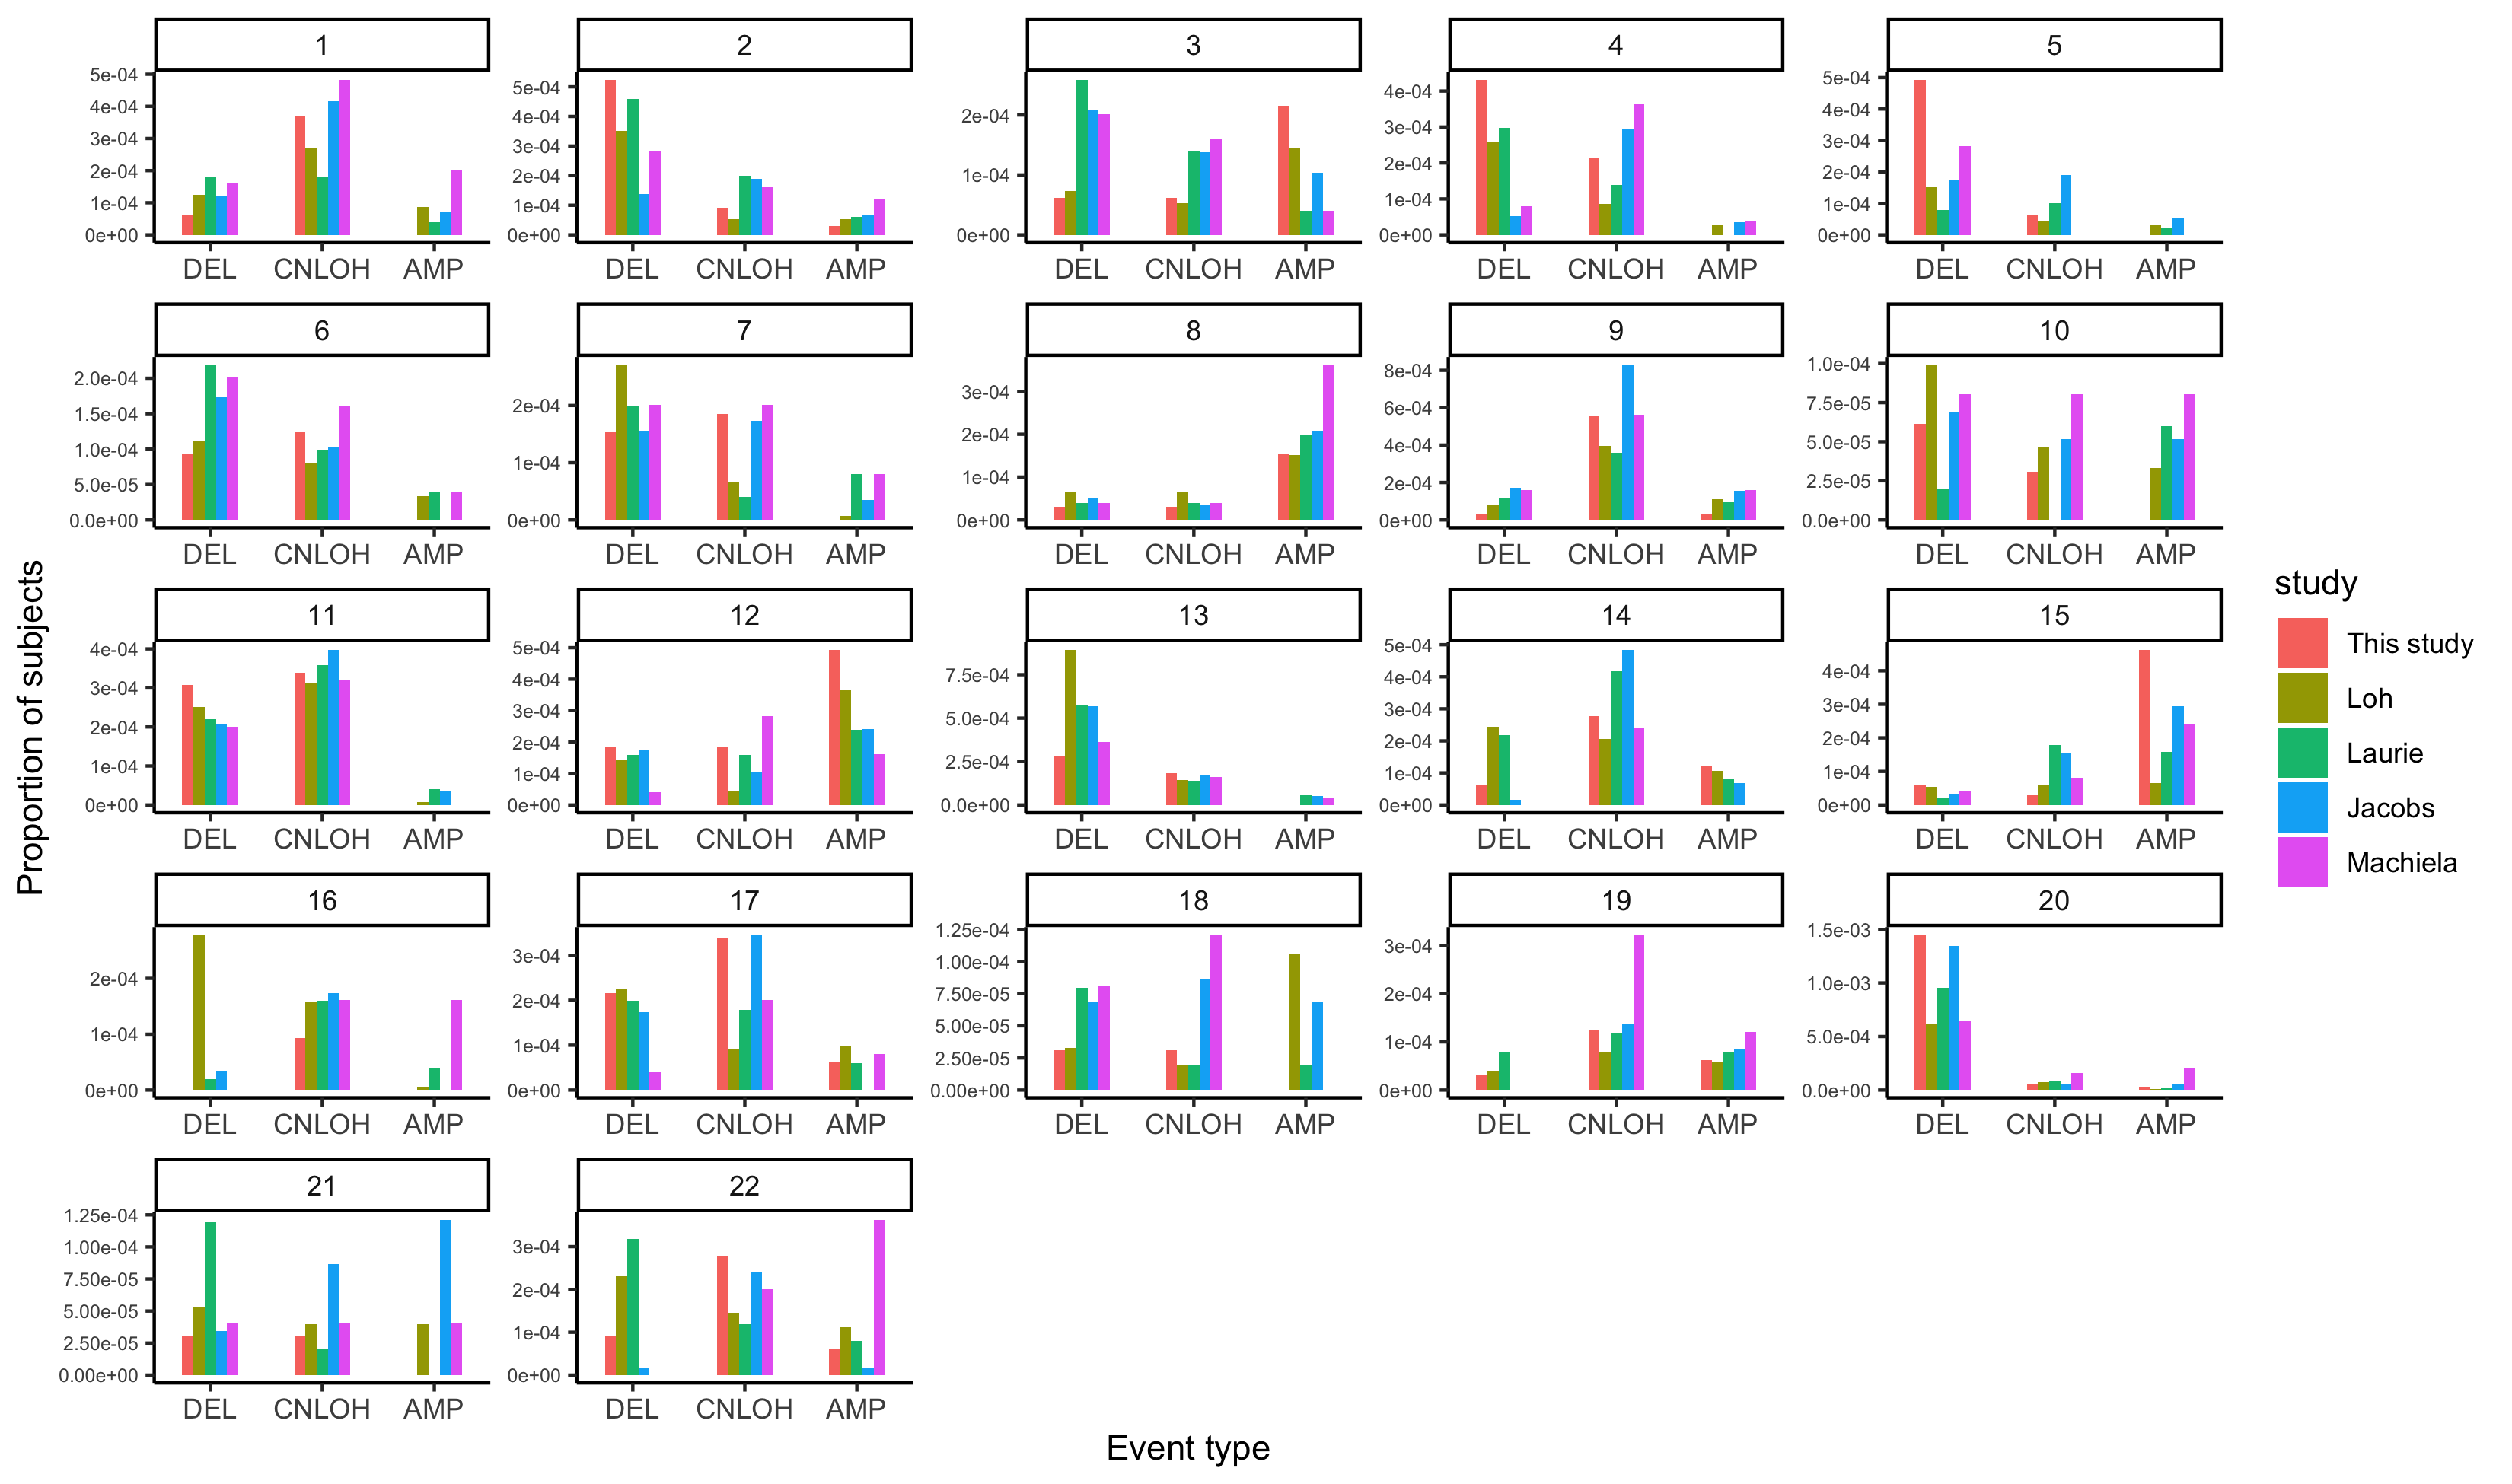

In [143]:
p = segs_all %>%
    filter(chrom != '23') %>%
    filter(phi >= 0.1 | is.na(phi)) %>%
    group_by(study, chrom, type2) %>%
    summarise(
        n = length(unique(patient_id)),
        prop = n/unique(n_total),
        .groups = 'drop'
    ) %>%
    tidyr::complete(chrom, type2, study, fill = list(n = 0, prop = 0)) %>% 
    ggplot(
        aes(x = type2, y = prop, fill = study)
    ) +
    scale_x_discrete(drop=FALSE, expand = expansion(add = 0.5)) +
    geom_col(width = 0.5, position = position_dodge(width = 0.5)) +
    facet_wrap(~chrom, scale = 'free') +
    scale_y_continuous(labels = function(x) format(x, scientific = TRUE)) +
    theme_classic() +
    theme(
        axis.text.y = element_text(size = 6)
    ) +
    ylab('Proportion of subjects') +
    xlab('Event type')
                   
do_plot(p, 'comparison_incidence.pdf', w = 11, h = 6.5)

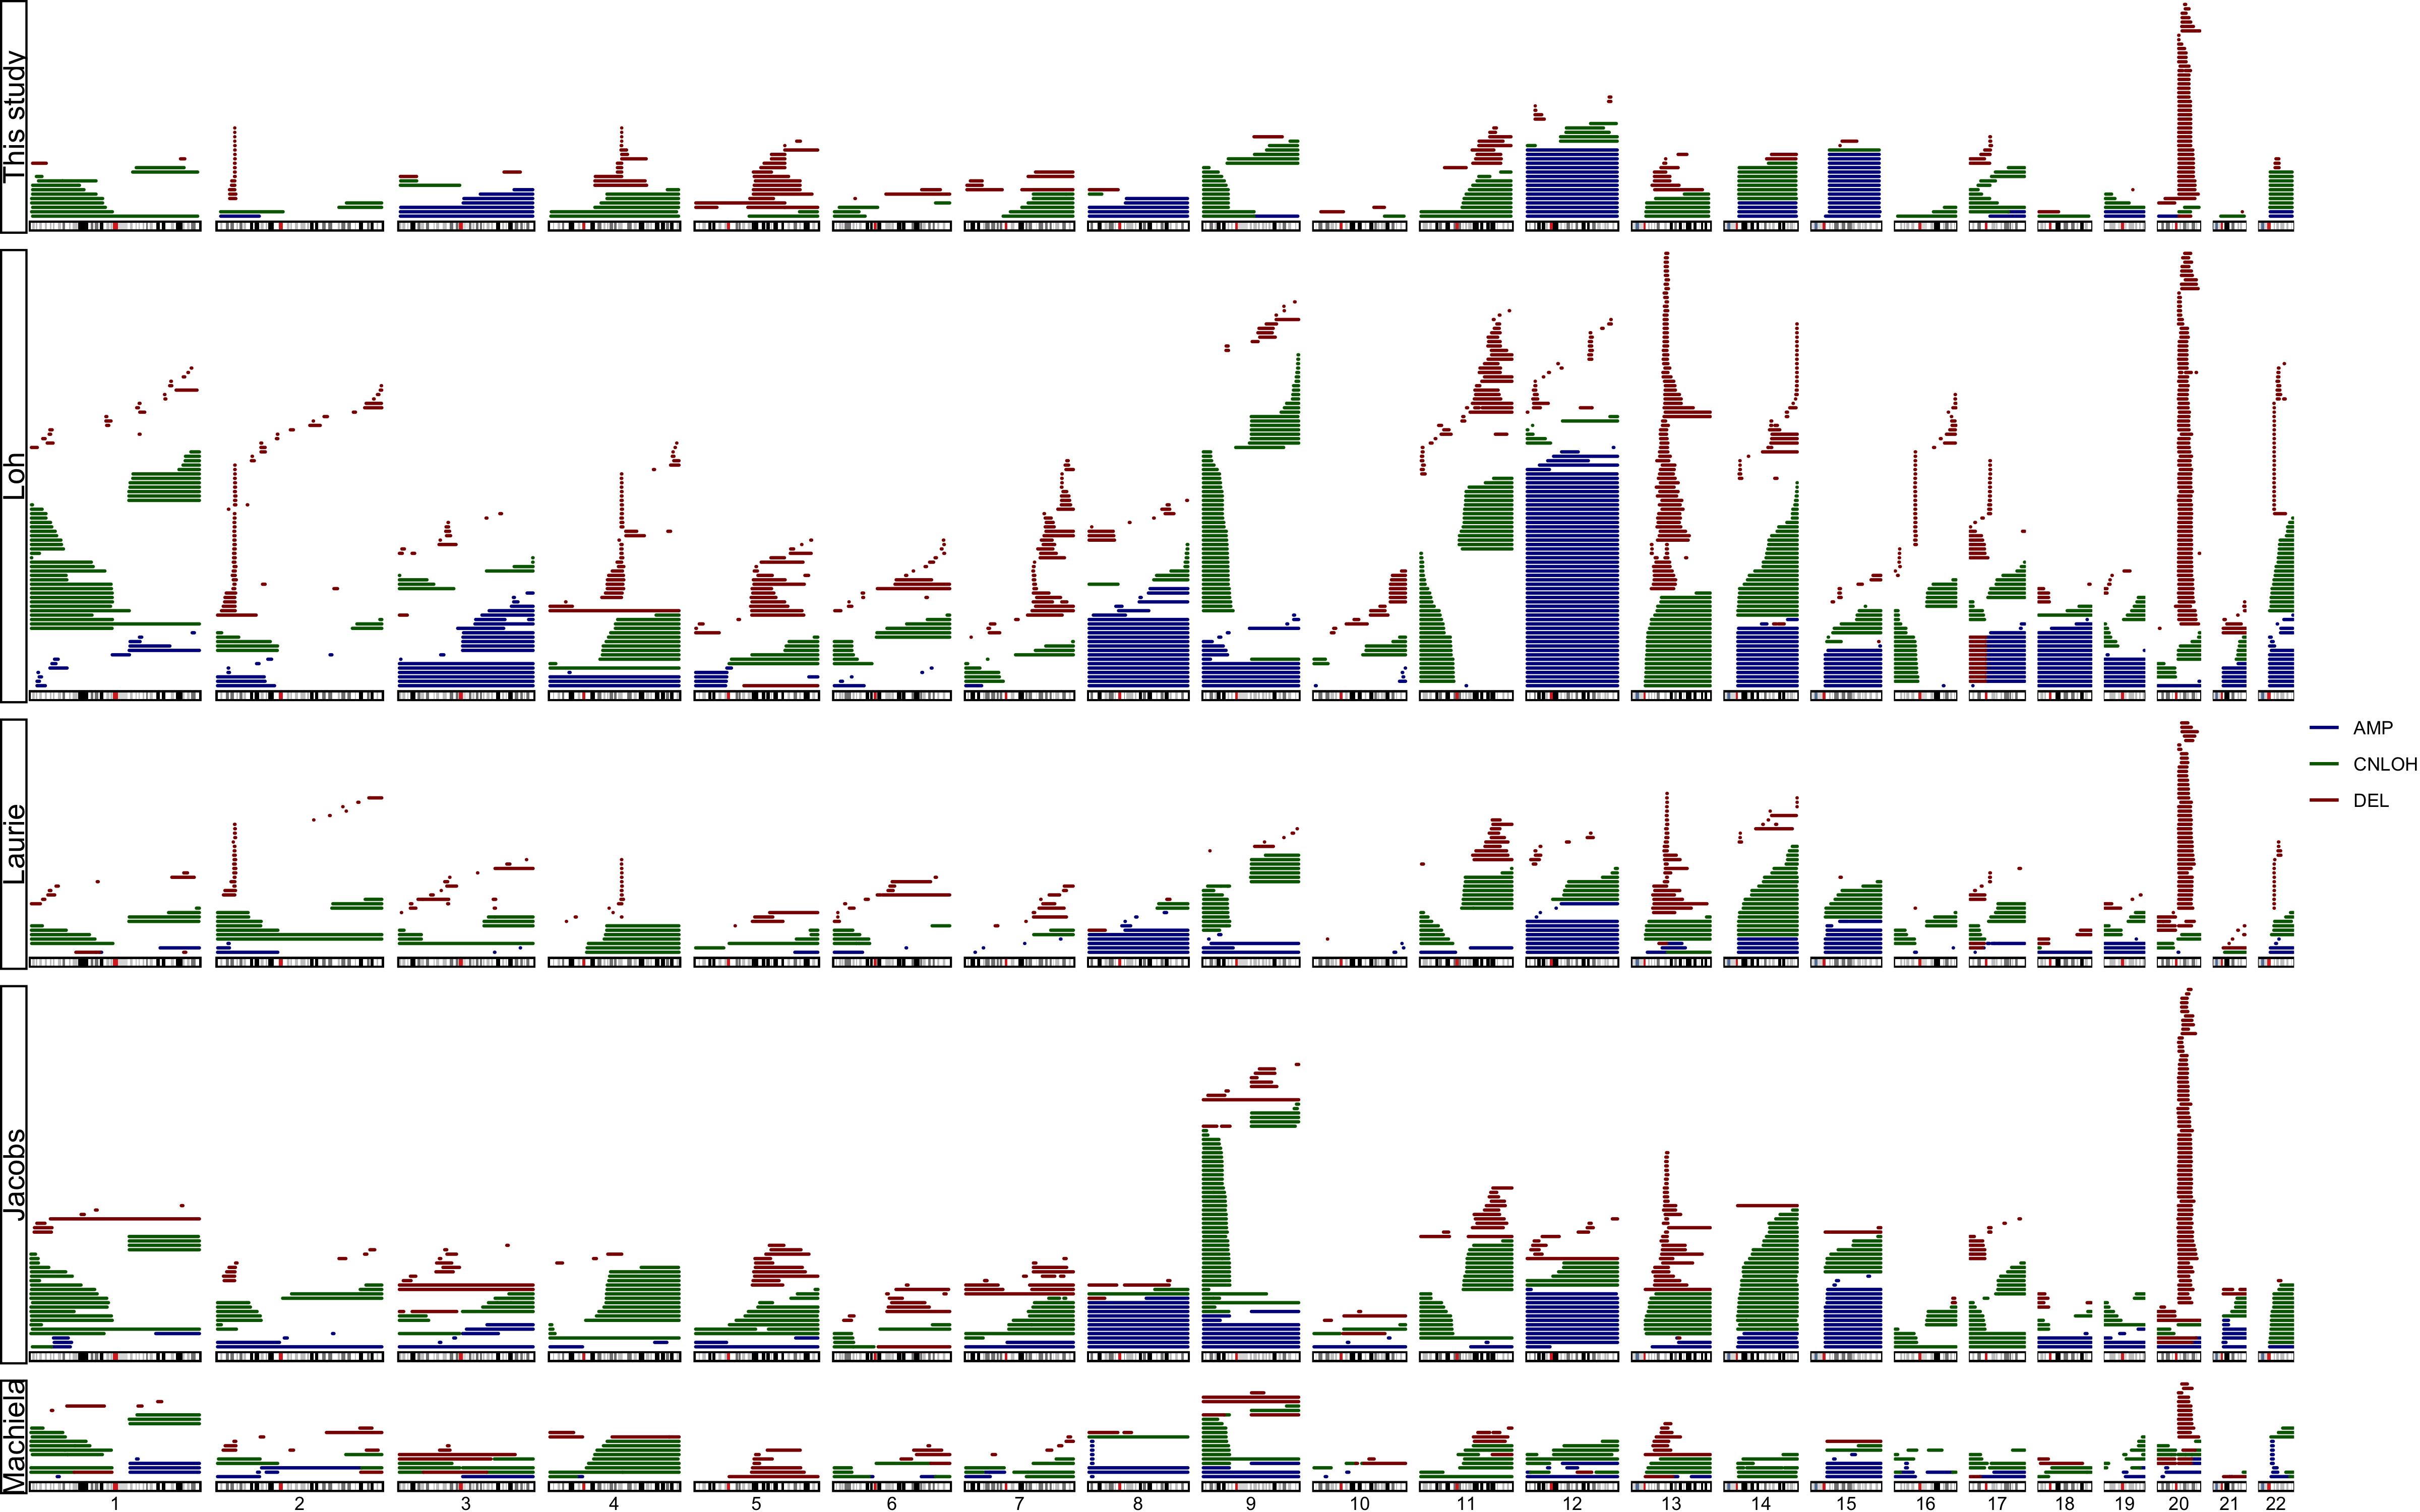

In [145]:
cytoband = fread('../data/cytoBand.txt') %>% setNames(c('chrom', 'start', 'end', 'name', 'stain'))

cytoband = cytoband %>% 
    mutate(chrom = str_remove(chrom, 'chr')) %>%
    mutate(chrom = ifelse(chrom == 'X', 23, chrom)) %>%
    filter(chrom != 'Y') %>%
    mutate(chrom = as.integer(chrom))

cyto_colors = c(
    'gpos100'= rgb(0/255.0,0/255.0,0/255.0),
    'gpos'   = rgb(0/255.0,0/255.0,0/255.0),
    'gpos75' = rgb(130/255.0,130/255.0,130/255.0),
    'gpos66' = rgb(160/255.0,160/255.0,160/255.0),
    'gpos50' = rgb(200/255.0,200/255.0,200/255.0),
    'gpos33' = rgb(210/255.0,210/255.0,210/255.0),
    'gpos25' = rgb(200/255.0,200/255.0,200/255.0),
    'gvar'   = rgb(220/255.0,220/255.0,220/255.0),
    'gneg'  = rgb(255/255.0,255/255.0,255/255.0),
    'acen'  = rgb(217/255.0,47/255.0,39/255.0),
    'stalk' = rgb(100/255.0,127/255.0,164/255.0)
)

window = 1e7

M_overlap = M_long %>%
    filter(dmp_patient_id %in% segs_filtered$dmp_patient_id) %>%
    rowwise() %>%
    filter(
        any(chrom == segs_filtered$chrom & dmp_patient_id == segs_filtered$dmp_patient_id &
            start >= segs_filtered$start - window & start <= segs_filtered$end + window)
    ) %>%
    ungroup() %>%
    mutate(VariantClass = case_when(
        VariantClass %in% c('Silent', 'Intron') ~ 'noncoding',
        T ~ 'coding'
    ))

p_segs = segs_all %>%
#     arrange(study != 'Loh') %>%
    mutate(study = factor(study, unique(study))) %>%
    filter(phi >= 0.1 | is.na(phi)) %>%
    filter(chrom != 23) %>%
    group_by(patient_id, chrom) %>%
    mutate(total_length = sum(size)) %>%
    mutate(type2 = factor(type2, c('AMP', 'CNLOH', 'DEL'))) %>%
    arrange(type2, round(start/1e7), -total_length) %>%
    group_by(chrom, study) %>%
    mutate(index = as.integer(factor(patient_id, unique(patient_id)))) %>% 
    filter(index < 100) %>%
    ungroup() %>%
    ggplot(
        aes(x = start, xend = end, y = index, yend = index, color = type2)
    ) +
    geom_rect(
        inherit.aes = F,
        data = chrom_lens %>% filter(chrom != 23),
        aes(xmin = 0, xmax = length, ymin = -2, ymax = -0.5),
        color = 'black',
        fill = 'white',
        size = 1
    ) +
    geom_rect(
        data = cytoband %>% filter(chrom != 23),
        inherit.aes = F,
        aes(xmin = start, xmax = end, ymin = -2, ymax = -0.5, fill = stain),
        size = 1,
        show.legend = FALSE
    ) +
    geom_segment(
        lineend = 'round',
        size = 0.75
    ) +
    scale_fill_manual(values = cyto_colors) +
    theme_void() +
    theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank(),
        legend.position = 'right',
        panel.spacing.y = unit(0.5, "lines"),
        plot.margin = unit(c(0,0,0,0), "lines"),
        panel.border = element_blank(),
        strip.text.y = element_text(size = 14, hjust = 0.5, angle = 0),
        strip.background.y = element_rect(size = 1, fill = NA),
        strip.background.x = element_blank()
    ) +
    scale_y_discrete(expand = expansion(add = 1)) +
    scale_x_discrete(expand = c(0.02,0)) +
    facet_grid(study~chrom, space = 'free', scales = 'free', switch="both") +
    xlab('') +
    ylab('') +
    scale_color_manual(values = cnv_pal2, name = '')

do_plot(p_segs, 'comparison_genomewide.pdf', w = 16, h = 10)

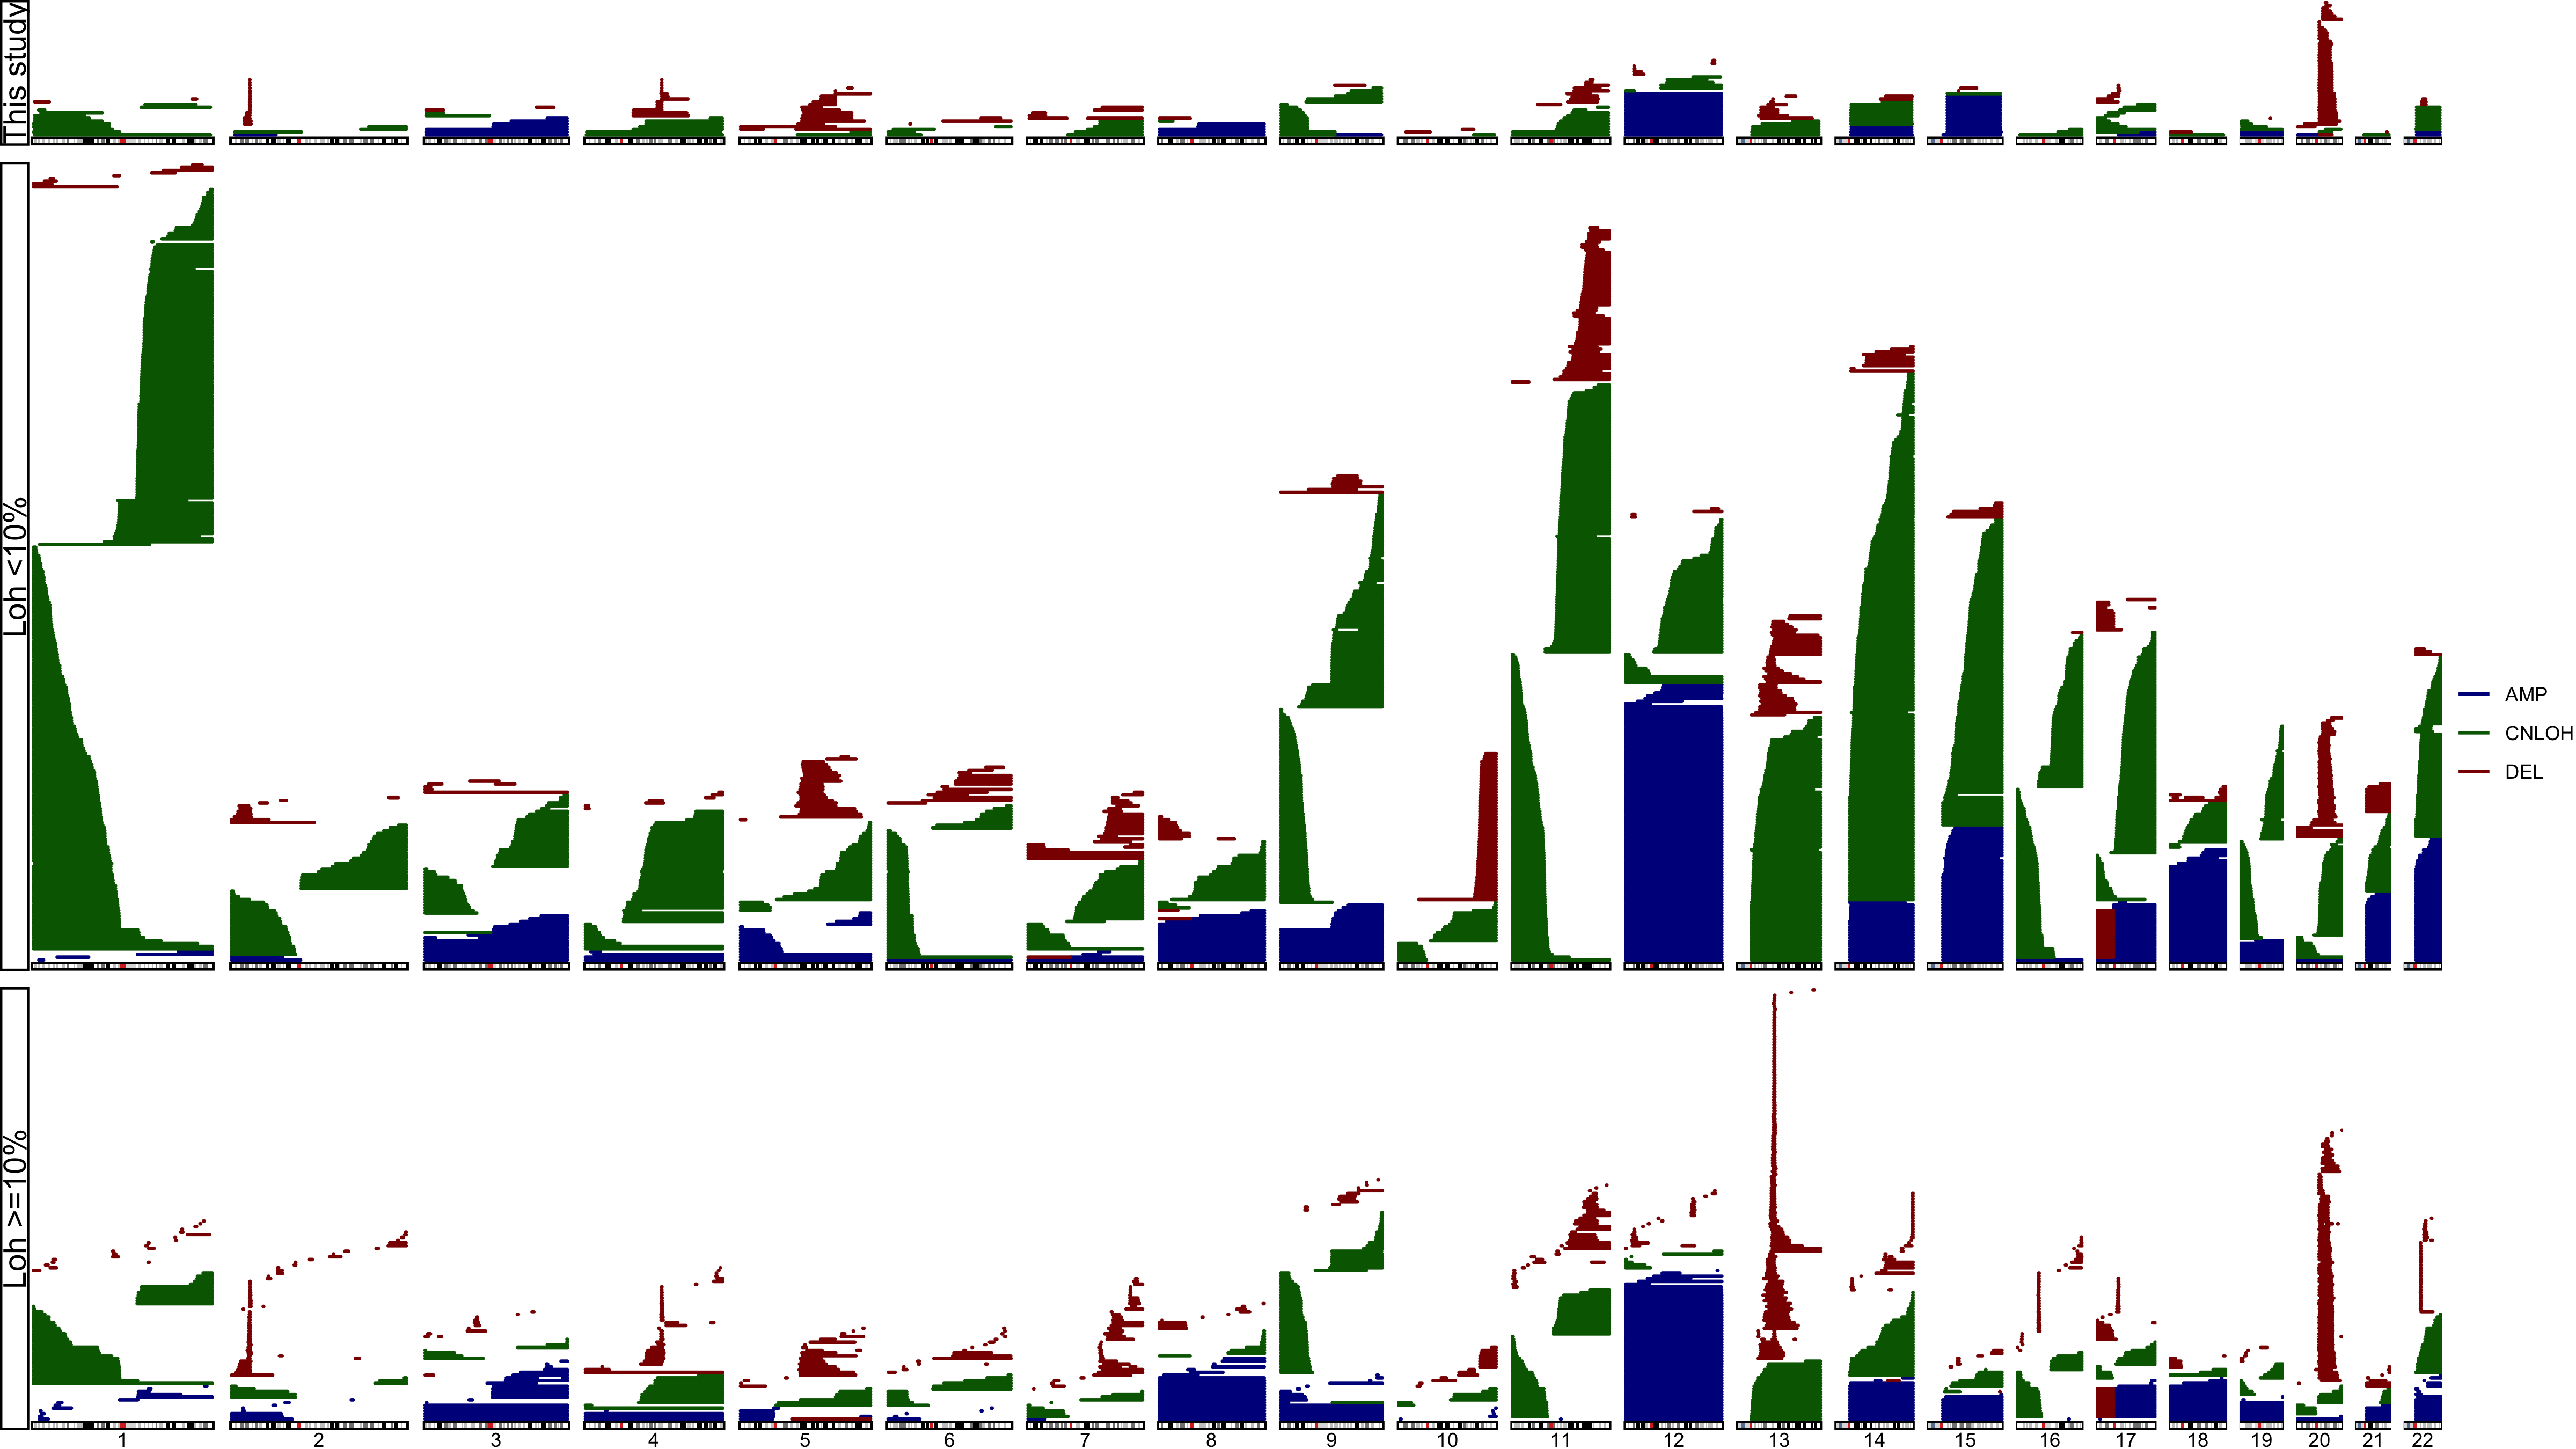

In [146]:
##  EDITED MS - Reviewer 2 

window = 1e7

M_overlap = M_long %>%
    filter(dmp_patient_id %in% segs_filtered$dmp_patient_id) %>%
    rowwise() %>%
    filter(
        any(chrom == segs_filtered$chrom & dmp_patient_id == segs_filtered$dmp_patient_id &
            start >= segs_filtered$start - window & start <= segs_filtered$end + window)
    ) %>%
    ungroup() %>%
    mutate(VariantClass = case_when(
        VariantClass %in% c('Silent', 'Intron') ~ 'noncoding',
        T ~ 'coding'
    ))

p_segs = segs_all %>%
filter(study %in% c("This study", "Loh")) %>%
#     arrange(study != 'Loh') %>%
    mutate(study = case_when(
        study == "Loh" & phi < 0.1 ~ "Loh <10%",
        study == "Loh" & phi >= 0.1 ~ "Loh >=10%",
        T ~ "This study")  ) %>%
    mutate(study = factor(study, unique(study))) %>%
    #filter(phi >= 0.1 | is.na(phi)) %>%
    filter(chrom != 23) %>%
    group_by(patient_id, chrom) %>%
    mutate(total_length = sum(size)) %>%
    mutate(type2 = factor(type2, c('AMP', 'CNLOH', 'DEL'))) %>%
    arrange(type2, round(start/1e7), -total_length) %>%
    group_by(chrom, study) %>%
    mutate(index = as.integer(factor(patient_id, unique(patient_id)))) %>% 
#     filter(index < 100) %>%
    ungroup() %>%
    ggplot(
        aes(x = start, xend = end, y = index, yend = index, color = type2)
    ) +
    geom_rect(
        inherit.aes = F,
        data = chrom_lens %>% filter(chrom != 23),
        aes(xmin = 0, xmax = length, ymin = -2, ymax = -0.5),
        color = 'black',
        fill = 'white',
        size = 1
    ) +
    geom_rect(
        data = cytoband %>% filter(chrom != 23),
        inherit.aes = F,
        aes(xmin = start, xmax = end, ymin = -2, ymax = -0.5, fill = stain),
        size = 1,
        show.legend = FALSE
    ) +
    geom_segment(
        lineend = 'round',
        size = 0.75
    ) +
    scale_fill_manual(values = cyto_colors) +
    theme_void() +
    theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank(),
        legend.position = 'right',
        panel.spacing.y = unit(0.5, "lines"),
        plot.margin = unit(c(0,0,0,0), "lines"),
        panel.border = element_blank(),
        strip.text.y = element_text(size = 14, hjust = 0.5, angle = 0),
        strip.background.y = element_rect(size = 1, fill = NA),
        strip.background.x = element_blank()
    ) +
    scale_y_discrete(expand = expansion(add = 1)) +
    scale_x_discrete(expand = c(0.02,0)) +
    facet_grid(study~chrom, space = 'free', scales = 'free', switch="both") +
    xlab('') +
    ylab('') +
    scale_color_manual(values = cnv_pal2, name = '')

do_plot(p_segs, 'comparison_genomewide_10p_h9.pdf', w = 16, h = 9)

# GM characterstics

Warning message:
“Removed 6 rows containing non-finite values (stat_density).”
Warning message:
“Removed 6 rows containing non-finite values (stat_density).”


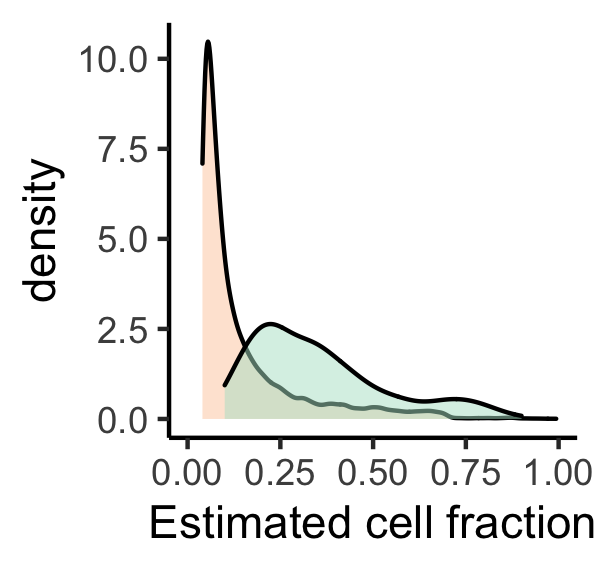

In [147]:
D = M_long %>% 
    filter(ch_nonsilent == 1) %>%
    rowwise() %>%
    mutate(
        cis_cnv = any(chrom == segs_filtered$chrom & dmp_patient_id == segs_filtered$dmp_patient_id &
            start >= segs_filtered$start - window & start <= segs_filtered$end + window)
    ) %>%
    ungroup() %>%
    filter(cis_cnv == 0)

p = ggplot(
        D,
        aes(x = VAF_N * 2)
    ) +
    geom_density(
        trim = TRUE,
        alpha = 0.5,
        fill = sm_col,
        size = 0.5
    ) +
    geom_density(
        trim = TRUE,
        inherit.aes = F,
        data = segs_filtered,
        mapping = aes(x = phi),
        fill = cnv_col,
        alpha = 0.5,
        size = 0.5
    ) +
    xlim(0,1) +
    theme_classic() +
    xlab('Estimated cell fraction')

do_plot(p, 'sensitivity.pdf', w = 2, h = 1.9)

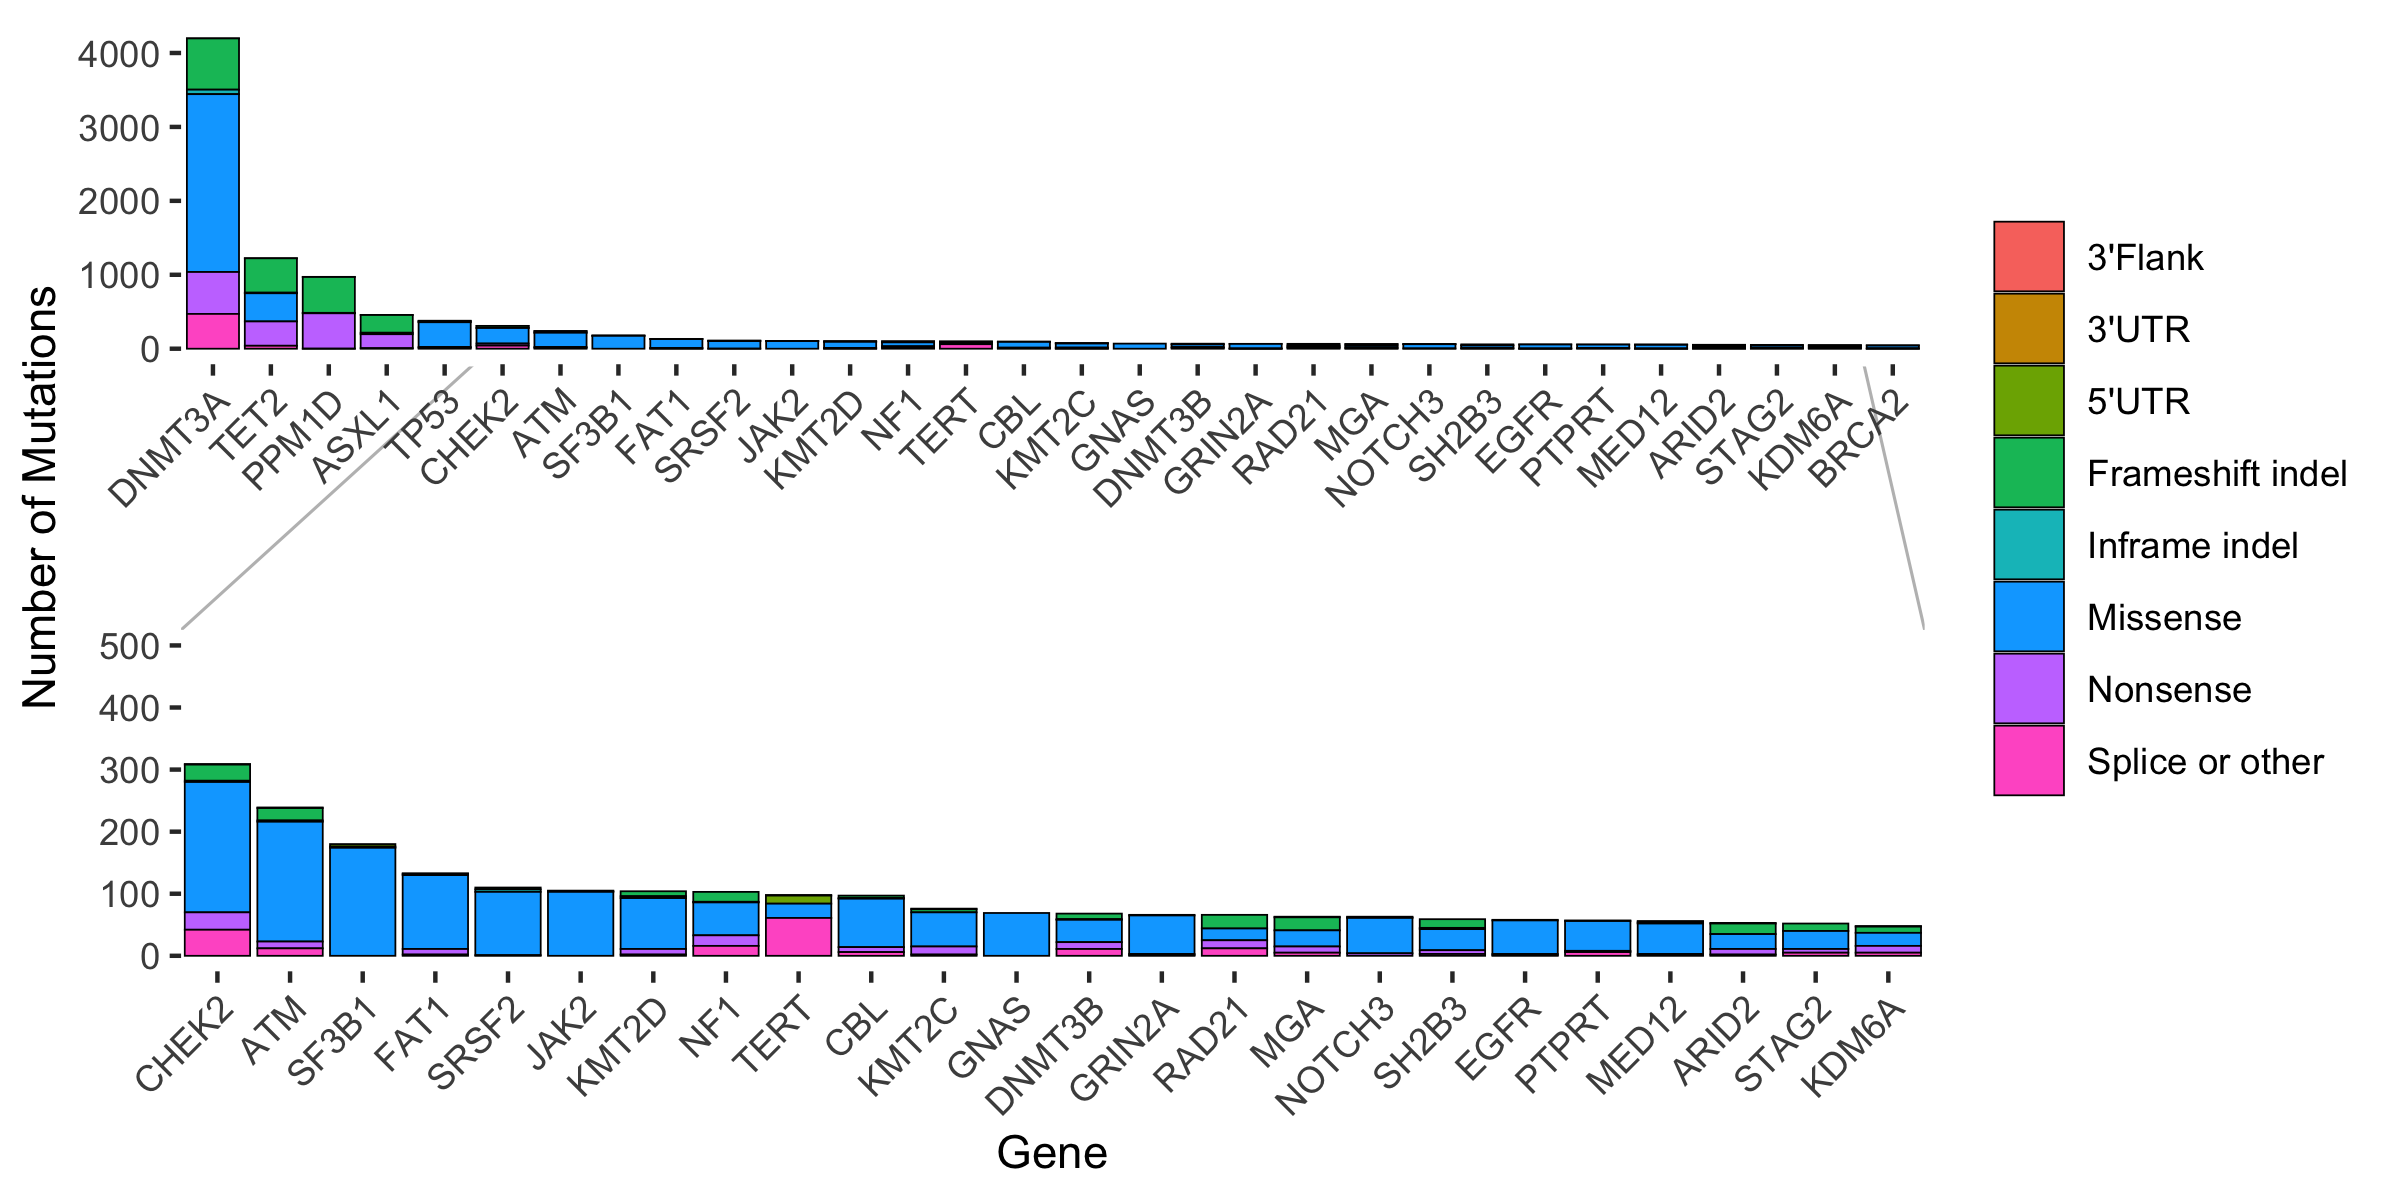

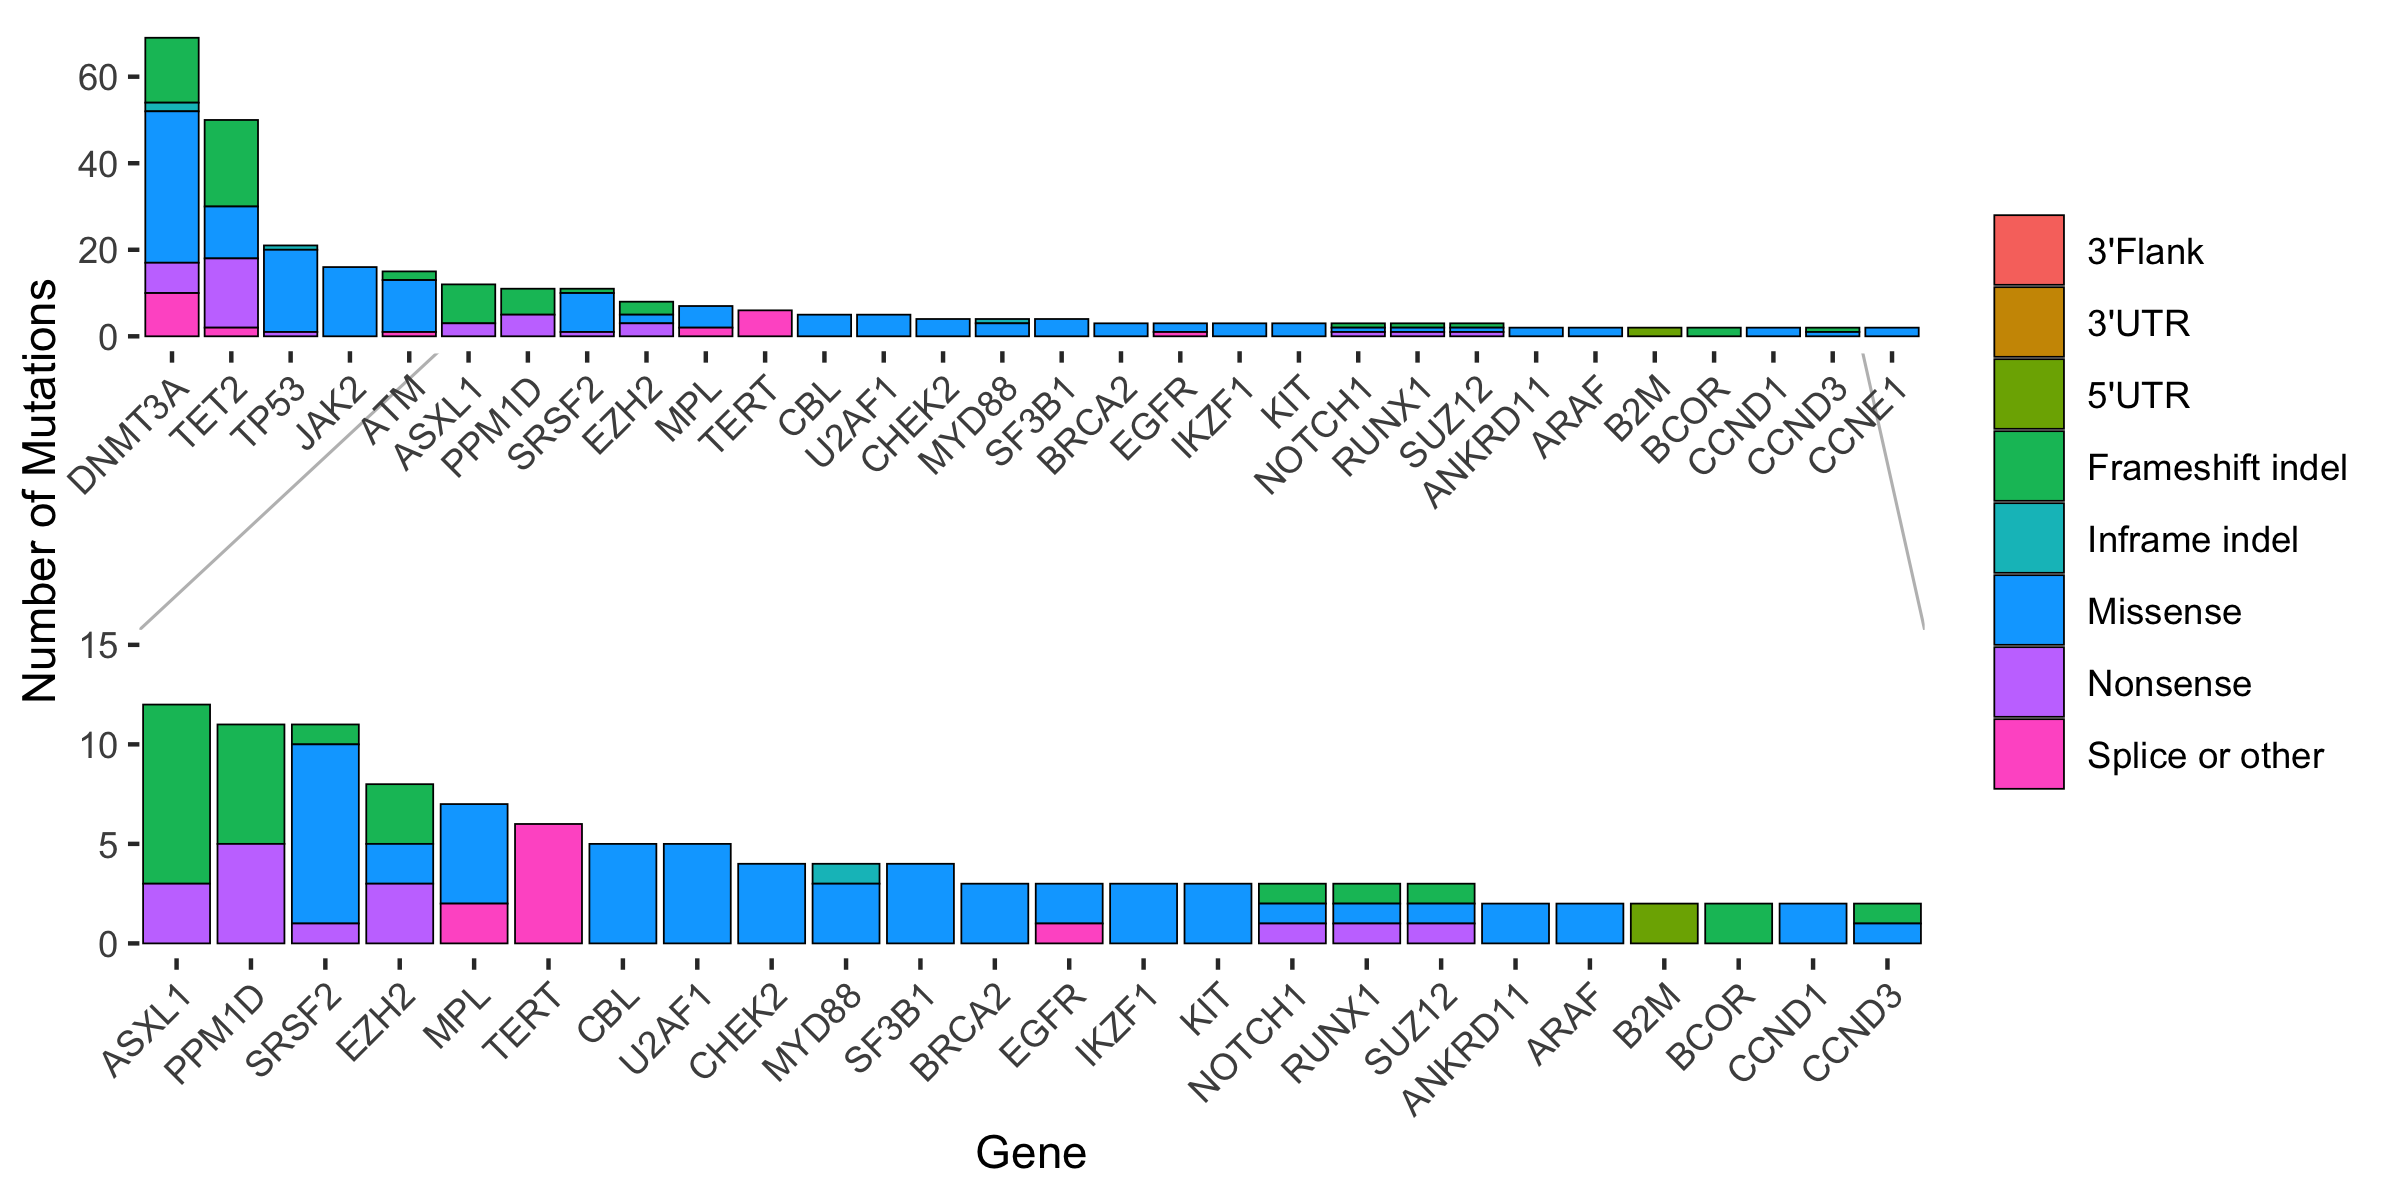

In [149]:
font_size = 8

M_long_nonsilent = M_long %>% 
    filter(!VariantClass %in% c('Silent', 'Intron')) %>%
    mutate(
        VariantClass3 = case_when(
            VariantClass == 'Frame_Shift_Del' ~ 'Frameshift indel',
            VariantClass == 'Frame_Shift_Ins' ~ 'Frameshift indel',
            VariantClass == 'In_Frame_Del' ~ 'Inframe indel',
            VariantClass == 'In_Frame_Ins' ~ 'Inframe indel',
            VariantClass == 'Splice_Site' ~ 'Splice or other',
            VariantClass == 'Splice_Region' ~ 'Splice or other',
            VariantClass == "5'Flank" ~ 'Splice or other',
            VariantClass == 'Translation_Start_Site' ~ 'Splice or other',
            VariantClass == 'Nonstop_Mutation' ~ 'Splice or other',
            VariantClass == 'Missense_Mutation' ~ 'Missense',
            VariantClass == 'Nonsense_Mutation' ~ 'Nonsense',
            T ~ VariantClass)
    ) %>%
    mutate(VariantClass3 = factor(VariantClass3))

panel_theme = theme(
    legend.direction = 'vertical',
    legend.position="top", 
    legend.text = element_text(size=12),
    plot.margin = margin(t = 0, r = 0, b = 0, l = 0),
    axis.text = element_text(size = font_size)
  )

# All patients

gene_list = M_long_nonsilent %>% count(Gene) %>% arrange(-n) %>% .$Gene %>% unique %>% .[1:30]

p_all = ggplot(
        M_long_nonsilent %>% filter(Gene %in% gene_list) %>% 
        mutate(Gene = as.integer(factor(Gene, gene_list))) %>%
        count(Gene, VariantClass3),
        aes(x = Gene, y = n, fill = VariantClass3)
    ) + 
    geom_bar(stat = 'identity', color = 'black', size = 0.2, width = 0.9) +
    ylab("Number of Mutations") +
    theme_classic() +
    theme(
        panel.grid.major = element_blank(), 
        panel.border = element_blank(),
        axis.line = element_line(colour = "white"),
        legend.title = element_blank()
    ) +
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = 'right',
        strip.background = element_rect(fill = NA, size = 1, color = 'gray')
    ) +
    facet_zoom(xlim = c(5.5 + 0.1, 29.5 - 0.1), zoom.size = 1, ylim = c(0,500), horizontal = F, show.area = F) +
    scale_x_continuous(labels = gene_list, breaks = 1:length(gene_list), expand = expansion(add=0.1)) +
    scale_fill_discrete(drop = F)

# CNV subset

gene_list = M_long_nonsilent %>% 
    filter(!VariantClass %in% c('Silent', 'Intron')) %>%
    filter(dmp_patient_id %in% (M_wide %>% filter(ch_cnv == 1) %>% pull(dmp_patient_id))) %>% 
    count(Gene) %>% arrange(-n) %>% .$Gene %>% unique %>% .[1:30]

p_cnv = ggplot(
    M_long_nonsilent %>% 
    filter(Gene %in% gene_list) %>% 
    filter(dmp_patient_id %in% (M_wide %>% filter(ch_cnv == 1) %>% pull(dmp_patient_id))) %>% 
    mutate(Gene = as.integer(factor(Gene, gene_list))) %>%
    count(Gene, VariantClass3),
    aes(x = Gene, y = n, fill = VariantClass3)
) + 
geom_bar(stat = 'identity', color = 'black', size = 0.2) +
ylab("Number of Mutations") +
theme_classic() +
theme(
    panel.grid.major = element_blank(), 
    panel.border = element_blank(),
    axis.line = element_line(colour = "white"),
    legend.title = element_blank()
) +
theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = 'right',
    strip.background = element_rect(fill = NA, size = 1, color = 'gray')
) +
facet_zoom(xlim = c(5.5 + 0.1, 29.5 - 0.1), zoom.size = 1, ylim = c(0,15), horizontal = F, show.area = F) +
scale_x_continuous(labels = gene_list, breaks = 1:length(gene_list), expand = expansion(add=0.1)) +
scale_fill_discrete(drop = F)

do_plot(p_all, 'sm_bar_all.pdf', w = 8, h = 4)
do_plot(p_cnv, 'sm_bar_ai.pdf', w = 8, h = 4)

mutnum_nonsilent n    prop       
1 1                6919 0.702151411
2 2                2089 0.211995129
3 3                 605 0.061396387
4 4                 176 0.017860767
5 5+                 65 0.006596306

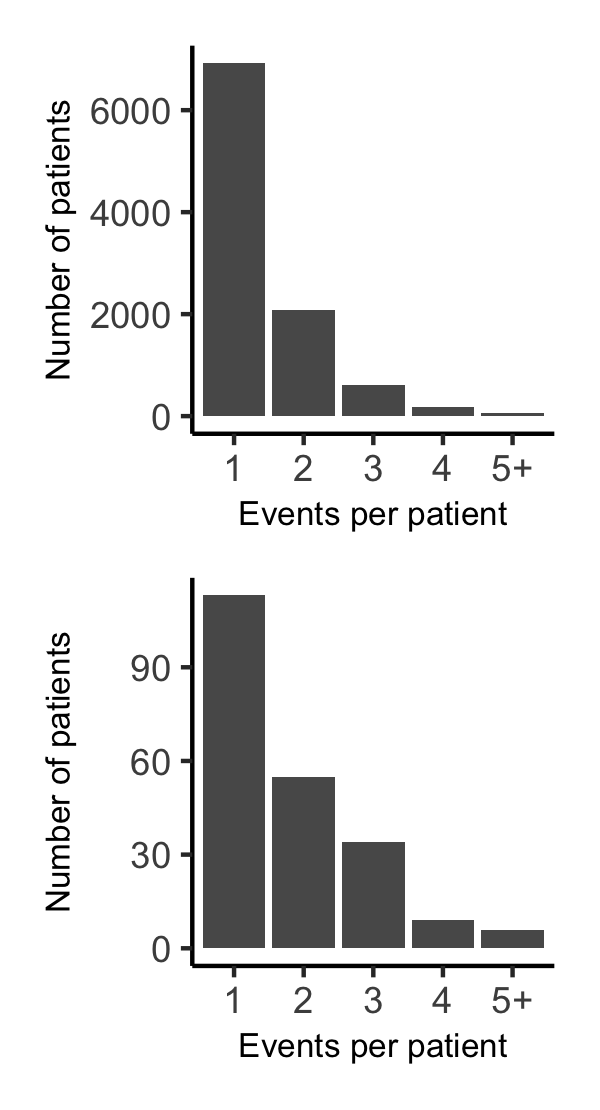

In [150]:
D = M_wide %>%
    filter(ch_nonsilent == 1) %>%
    mutate(mutnum_nonsilent = case_when(
        mutnum_nonsilent < 5 ~ as.character(mutnum_nonsilent), T ~ '5+')
    ) %>%
    count(mutnum_nonsilent) %>%
    mutate(prop = n/sum(n))

display(D)

p_n_all = ggplot(
        D,
        aes(x = mutnum_nonsilent, y = n)
    ) +
    theme_classic() +
    geom_bar(stat = 'identity', position = 'stack') +
    scale_fill_manual(values = cnv_pal) +
    theme(
        legend.position = 'none',
        axis.title = element_text(size = 8)
    ) +
    xlab('Events per patient') +
    ylab('Number of patients')
#     scale_y_continuous(expand = expansion(add = 0))


D = M_wide %>% 
    filter(ch_nonsilent == 1) %>%
    filter(ch_cnv == 1) %>%
    mutate(mutnum_nonsilent = case_when(
        mutnum_nonsilent < 5 ~ as.character(mutnum_nonsilent), T ~ '5+')
    ) %>%
    count(mutnum_nonsilent)

p_n_ai = ggplot(
        D,
        aes(x = mutnum_nonsilent, y = n)
    ) +
    theme_classic() +
    geom_bar(stat = 'identity', position = 'stack') +
    scale_fill_manual(values = cnv_pal) +
    theme(
        legend.position = 'none',
        axis.title = element_text(size = 8)
    ) +
    xlab('Events per patient') +
    ylab('Number of patients')
#     scale_y_continuous(expand = expansion(add = 0))

(p_n_all / p_n_ai) %>%
do_plot('sm_num.pdf', w = 2, h = 3.7)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



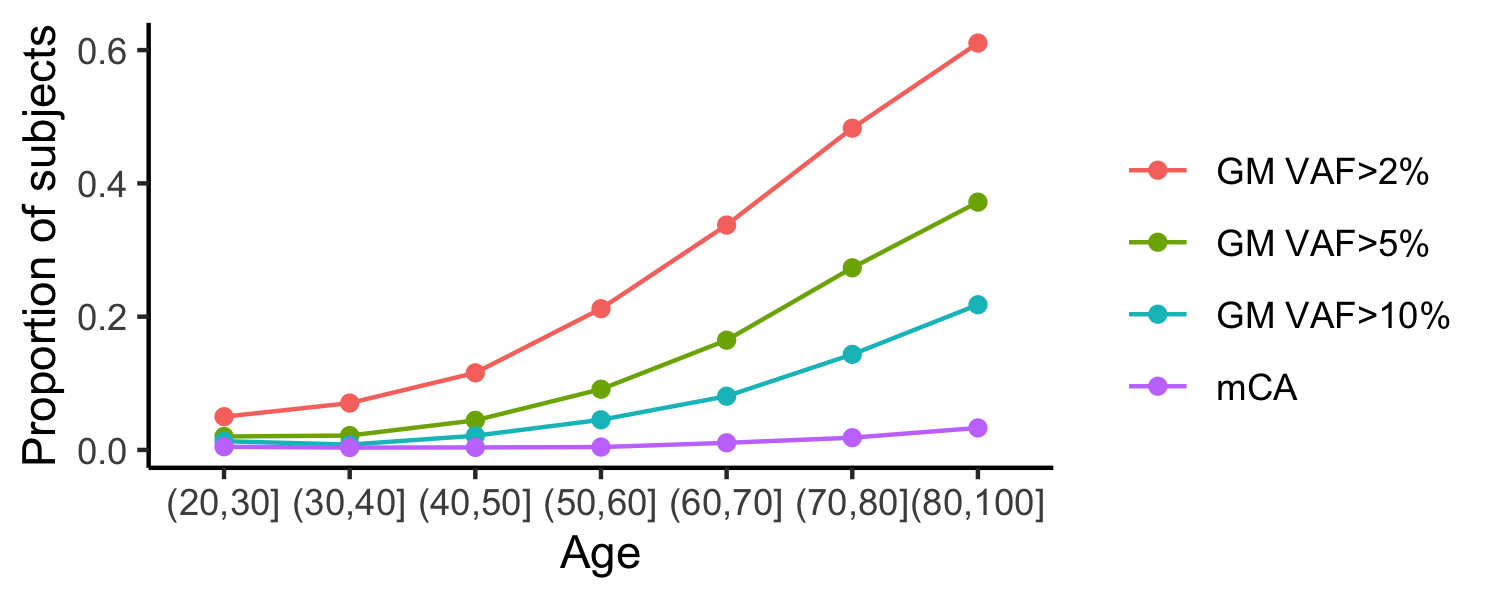

In [151]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 300)

D = M_wide %>% 
    mutate(age_bin = cut(age, c(0, seq(20, 80, 10), 100))) %>%
    group_by(age_bin) %>%
    summarise(
        `GM VAF>2%` = sum(ch_nonsilent & VAF_nonsilent > 0.02)/n(),
        `GM VAF>5%` = sum(ch_nonsilent & VAF_nonsilent > 0.05)/n(),
        `GM VAF>10%` = sum(ch_nonsilent & VAF_nonsilent > 0.1)/n(),
        n = n()
    ) %>% 
    melt(measure.vars = c('GM VAF>2%', 'GM VAF>5%', 'GM VAF>10%'), variable.name = 'threshold', value.name = 'prop') %>%
    rbind(
        M_wide %>% 
        mutate(age_bin = cut(age, c(0, seq(20, 80, 10), 100))) %>%
        group_by(age_bin) %>%
        summarise(
            prop = sum(ch_cnv)/n(),
            n = n()
        ) %>%
        mutate(threshold = 'mCA')
    )

p_age = ggplot(
    D,
    aes(x = age_bin, y = prop, group = threshold, color = threshold)
) +
geom_line() +
theme_classic() +
geom_point() +
ylab('Proportion of subjects') +
xlab('Age') +
labs(color = '')

p_age %>%
do_plot('sm_age.pdf', w = 5, h = 2)


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



$colour
[1] ""

attr(,"class")
[1] "labels"

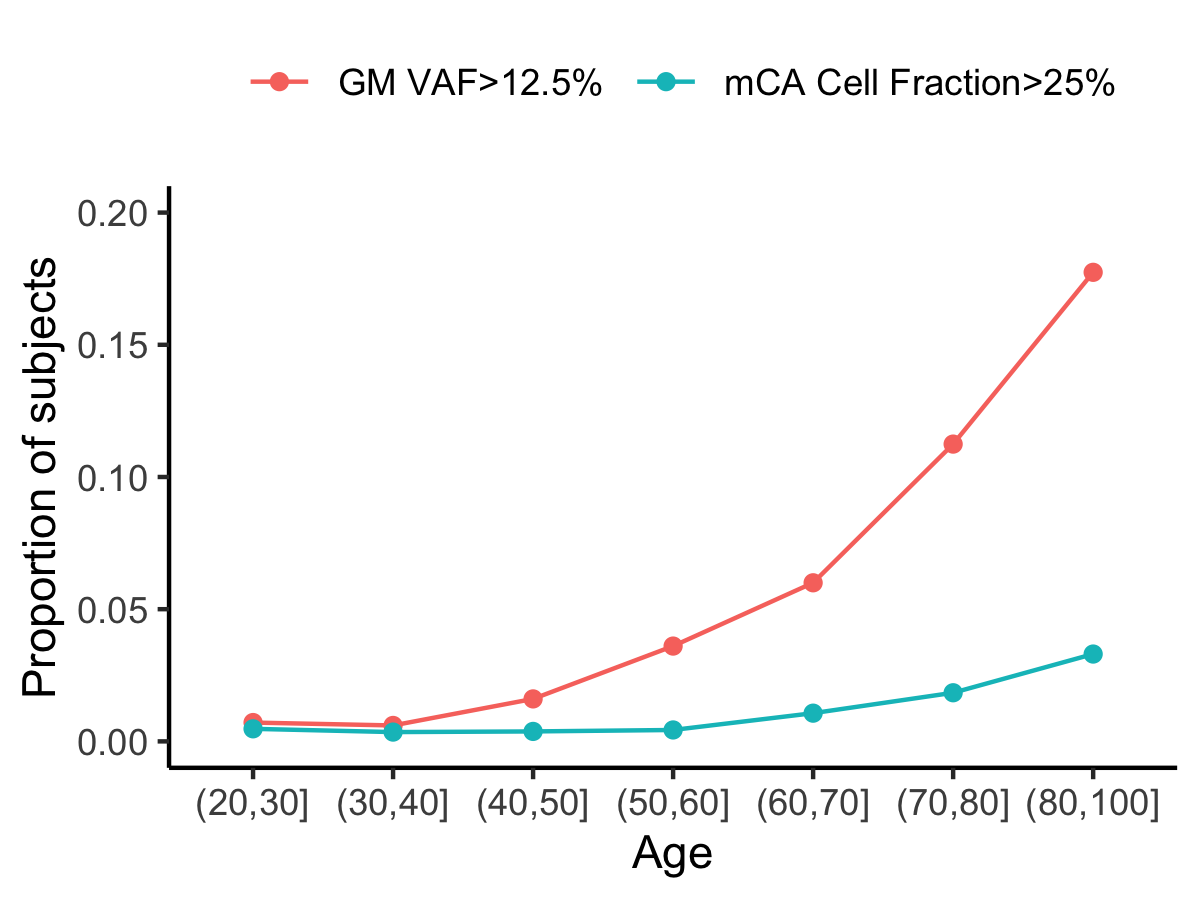

In [152]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 300)
D = M_wide %>% 
    mutate(age_bin = cut(age, c(0, seq(20, 80, 10), 100))) %>%
    group_by(age_bin) %>%
    summarise(
        `GM VAF>12.5%` = sum(ch_nonsilent & VAF_nonsilent > 0.125)/n(),
        n = n()
    ) %>% 
    melt(measure.vars = c('GM VAF>12.5%'), variable.name = 'threshold', value.name = 'prop') %>%
    rbind(
        M_wide %>% 
        mutate(age_bin = cut(age, c(0, seq(20, 80, 10), 100))) %>%
        group_by(age_bin) %>%
        summarise(
            prop = sum(ch_cnv )/n(),
            n = n()
        ) %>%
        mutate(threshold = 'mCA Cell Fraction>25%')
    )
p_age = ggplot(
    D,
    aes(x = age_bin, y = prop,  group = threshold , color = threshold)
) +
geom_line() +
theme_classic() +
geom_point() + theme(legend.position="top") + theme(legend.title = element_blank()) + 
ylab('Proportion of subjects') +
xlab('Age') + ylim(0,0.2)
labs(color = '')
p_age %>%
do_plot('sm_age_MS_edit.pdf', w = 4, h = 3)

# Therapy and demographics

term                  estimate  std.error  conf.low  conf.high statistic
1 GenderMale            1.4261418 0.21038496 0.9442407 2.153985   1.687254
2 race_b                1.4408066 0.31303190 0.7801039 2.661086   1.166664
3 age10                 1.6862573 0.09541417 1.3986439 2.033015   5.476246
4 smoke                 1.3472820 0.22422731 0.8681522 2.090842   1.329406
5 XRT                   1.6693663 0.22312939 1.0780119 2.585114   2.296623
6 ind_cytotoxic_therapy 0.8780983 0.22249845 0.5677434 1.358108  -0.584259
  df.error p.value      p.stars p.label  group xpos xmin  xmax 
1 Inf      9.155460e-02         1.43     pos   6    5.825 6.175
2 Inf      2.433460e-01         1.44     pos   5    4.825 5.175
3 Inf      4.344439e-08 ***     1.69 *** pos   4    3.825 4.175
4 Inf      1.837139e-01         1.35     pos   3    2.825 3.175
5 Inf      2.164028e-02 *       1.67 *   pos   2    1.825 2.175
6 Inf      5.590461e-01         0.88     neg   1    0.825 1.175

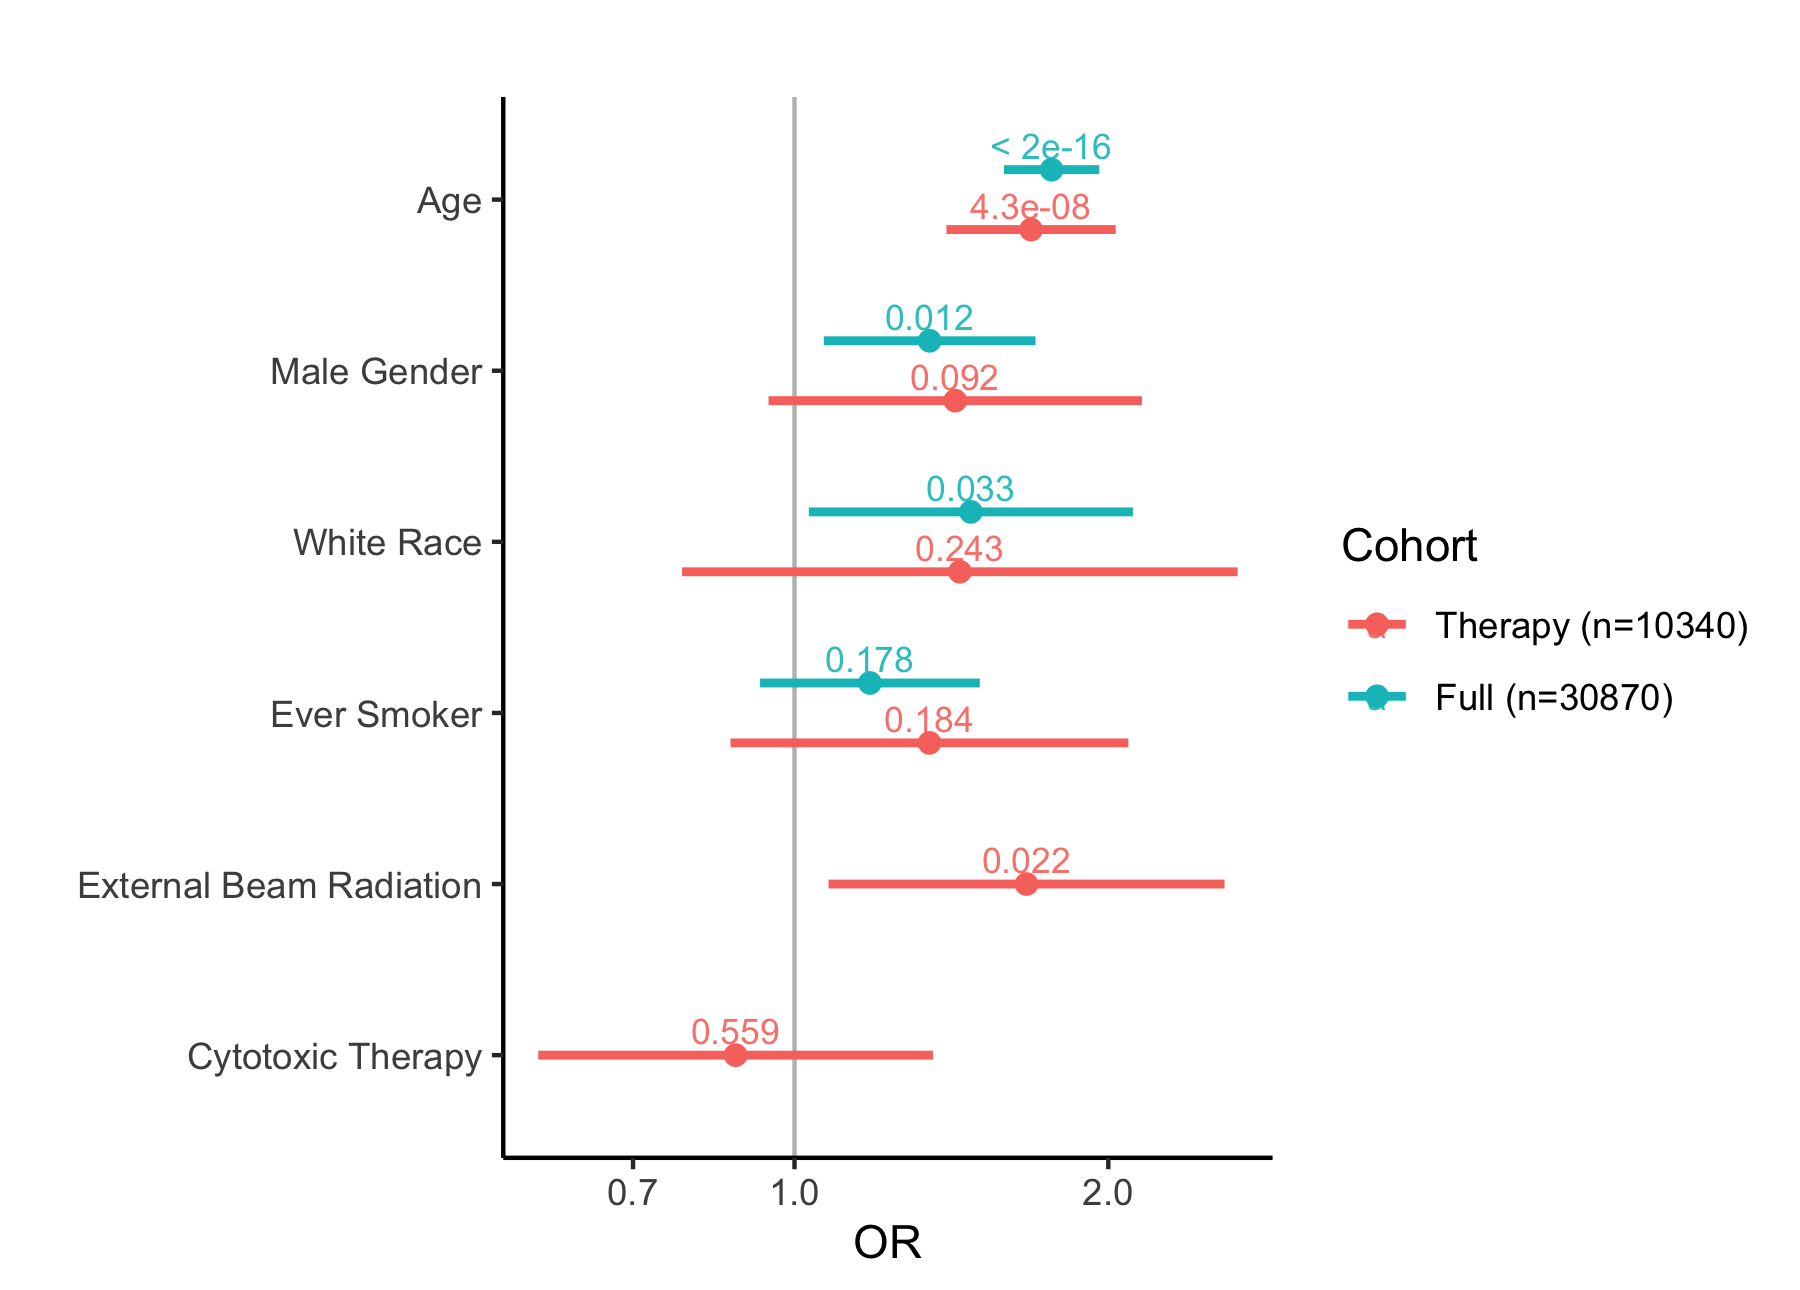

In [7]:
### therapy mCA 

options(repr.plot.width = 4, repr.plot.height = 2.5, repr.plot.res = 500)

options(warn=-1)

summ_cnv = M_wide %>%
    filter(smoke != 'missing') %>%
    mutate(smoke = as.integer(smoke)) %>%
    glm(
        ch_cnv_auto ~ Gender + race_b + age10 + smoke ,
        data = .,
        family = 'binomial'
    ) %>% 
    sjPlot::get_model_data(type = 'est')

summ_cnv_therapy = M_wide %>%
    filter(therapy_detailed & smoke != 'missing') %>%
    filter(DOP_match) %>%
    group_by(tumor_type) %>% mutate(n_tumor_type = n()) %>% ungroup() %>%
    mutate(tumor_type = ifelse(n_tumor_type < 100, 'Other', tumor_type)) %>%
    mutate(
        smoke = as.integer(smoke)
    ) %>%
    glm(
        ch_cnv_auto ~ Gender + race_b + age10 + smoke + XRT + ind_cytotoxic_therapy,
        data = .,
        family = 'binomial'
    ) %>% 
    sjPlot::get_model_data(type = 'est')

options(warn=0)

summ_cnv_therapy

p_forest = rbind(
        summ_cnv %>% mutate(cohort = paste0('Full (n=', nrow(M_wide[M_wide$smoke != 'missing',]), ')')),
        summ_cnv_therapy %>% mutate(cohort = paste0('Therapy (n=', sum(M_wide[M_wide$smoke != 'missing',]$therapy_detailed), ')'))
    ) %>%
    arrange(cohort) %>%
    mutate(cohort = factor(cohort, rev(unique(cohort)))) %>%
    filter(!str_detect(term, 'tumor_type')) %>%
    mutate(term = factor(term, c('age10', 'GenderMale', 'race_b', 'smoke', 'XRT', 'ind_cytotoxic_therapy'))) %>%
    arrange(term) %>%
    mutate(
        term = c('age10' = 'Age', 'GenderMale' = 'Male Gender', 'race_b' = 'White Race',
                'smoke' = 'Ever Smoker', 'XRT' = 'External Beam Radiation', 'ind_cytotoxic_therapy' = 'Cytotoxic Therapy')[term] 
    ) %>%
    mutate(term = factor(term, rev(unique(term)))) %>%
    mutate(format.p.value = format.pval(p.value, digits = 2)) %>% 
    plot_forest(
        x = 'term',
        label = 'format.p.value',
        eb_w = 0,
        eb_s = 1,
        ps = 2,
        or_s = 3,
        nudge = -0.45,
        OR = T,
        col = 'cohort',
        dodge_width = 0.7
    ) +
    theme_classic() +
    ylab('OR') +
    xlab('') +
    scale_color_discrete(name = 'Cohort')

do_plot(p_forest, 'forest_therapy_pvalue.pdf', w = 6, h = 4.3)

# Associations with gene mutations

## Venn

In [155]:
library(VennDiagram)
library(RColorBrewer)
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

venn.diagram(
    x = list(M_wide[M_wide$ch_cnv == 1,][['dmp_patient_id']], M_wide[M_wide$ch_nonsilent == 1,][['dmp_patient_id']]),
    category.names = c('mCA', 'GM'),
    
    # output features
    filename = '../figures/venn.tiff',
    imagetype="tiff",
    height = 800, 
    width = 800, 
#     resolution = 300,
    compression = "lzw",
    output = TRUE,
    margin = 0.1,
    
    # circles
    lwd = 1,
    fill = c(cnv_col, sm_col),

    # Numbers
    cex = 0.6,
    fontface = "bold",
    fontfamily = "sans",
    ext.dist = 0.06,
    ext.line.lwd = 0.8,
    
    # Set names
    cat.cex = 0.55,
    cat.fontface = "bold",
    cat.default.pos = "outer",
    cat.fontfamily = "sans",
    cat.dist = 0.1
)

NULL

[1] 1

In [156]:
display(table(M_wide$ch_cnv, M_wide$ch_nonsilent))
fisher.test(table(M_wide$ch_cnv, M_wide$ch_nonsilent))

   
        0     1
  0 22459  9637
  1   129   217


	Fisher's Exact Test for Count Data

data:  table(M_wide$ch_cnv, M_wide$ch_nonsilent)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.133768 4.919801
sample estimates:
odds ratio 
   3.92049 


## Volcano

In [158]:
genes = M_long %>% count(Gene) %>% filter(n >= 30) %>% pull(Gene)

res = data.frame()

for (gene in genes) {
    
    test = fisher.test(table(M_wide[[gene]], M_wide[['ch_cnv']]))
    
    res = rbind(
        res,
        data.frame(
            'p.value' = test$p.value,
            'Gene' = gene,
            'OR' = test$estimate
        )
    )
}

res = res %>% mutate(q = p.adjust(p.value, n = length(genes), method = 'BH'))

Warning message:
“Removed 131 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 131 rows containing missing values (geom_text_repel).”


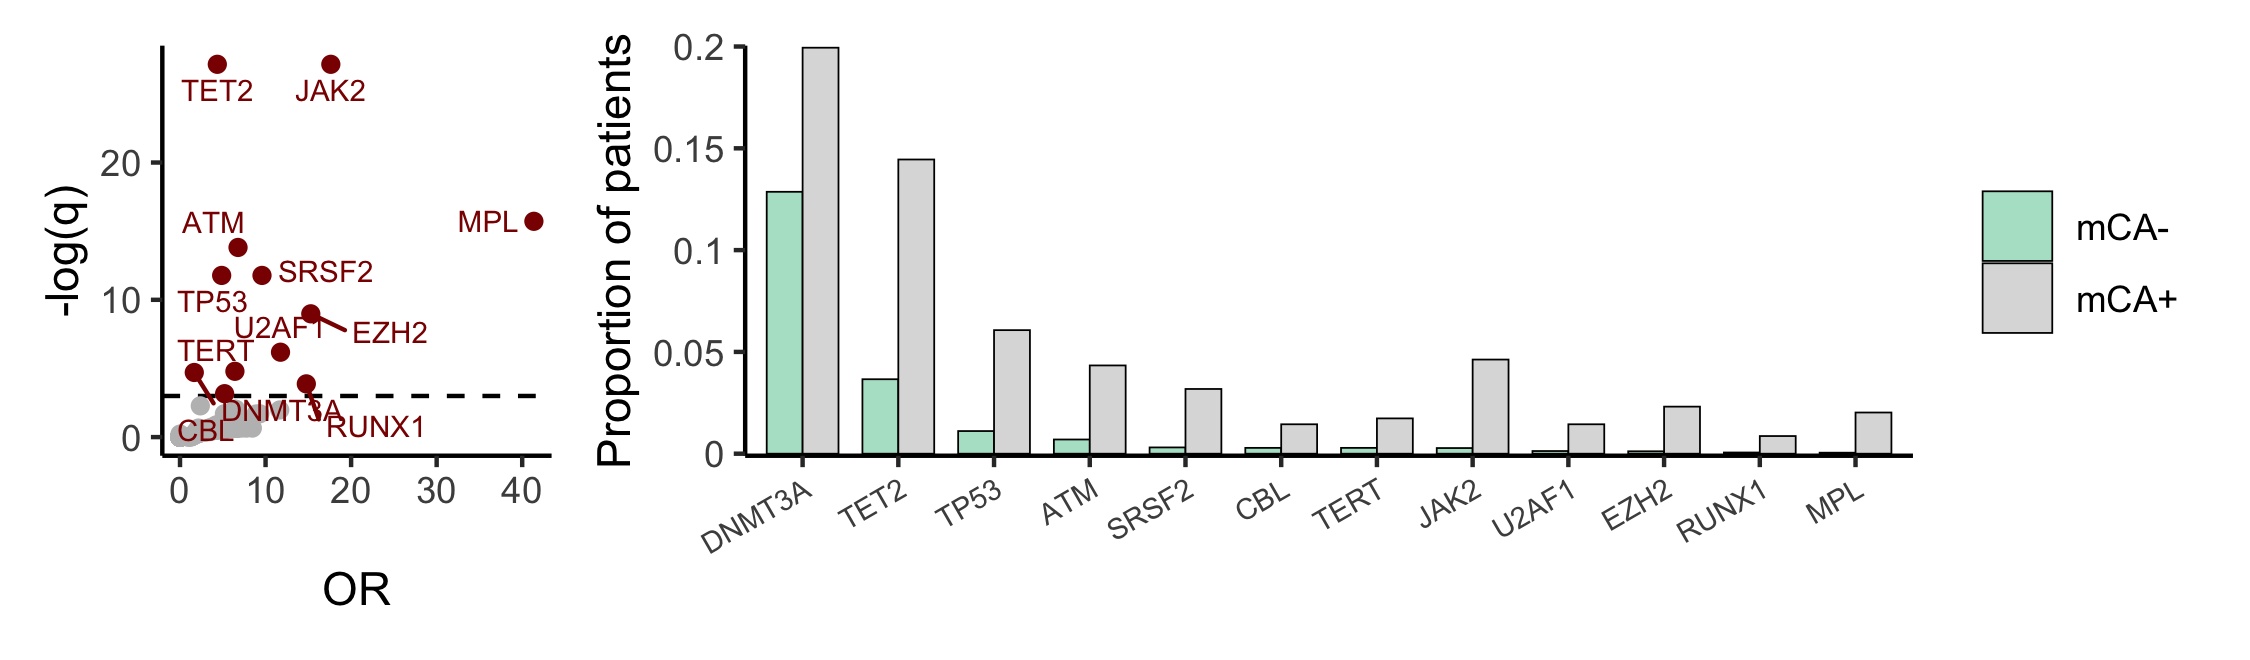

In [159]:
p_volcano = ggplot(
    res %>% mutate(label = ifelse(q < 0.05, as.character(Gene), NA)),
    aes(x = OR, y = -log(q), color = q < 0.05, label = label)
) +
geom_hline(yintercept = -log(0.05), linetype = 'dashed') +
geom_point() +
geom_text_repel(size = 2.5, seed = 3) +
theme_classic() +
scale_color_manual(values = c('gray', 'darkred')) +
theme(
    legend.position = 'none'
)

n_cnv = sum(M_wide$ch_cnv)
n_normal = nrow(M_wide) - sum(M_wide$ch_cnv)

genes = M_long %>% count(Gene) %>% arrange(-n) %>% filter(n > 30) %>% pull(Gene)

D = M_long %>%
    filter(ch_nonsilent == 1) %>%
    count(Gene, ch_cnv) %>%
    tidyr::complete(Gene, ch_cnv, fill = list(n = 0)) %>% 
    mutate(n_total = ifelse(ch_cnv == 1, n_cnv, n_normal)) %>% 
    group_by(ch_cnv) %>%
    mutate(prop = n/n_total) %>%
    left_join(
        res,
        by = 'Gene'
    ) %>%
    filter(q < 0.05) %>%
    arrange(desc(n)) %>%
    mutate(Gene = factor(Gene, Gene))

p_genes = ggplot(
    D %>% mutate(ch_cnv = ifelse(ch_cnv == 1, 'mCA+', 'mCA-')),
    aes(x = Gene, y = prop, fill = ch_cnv)
) +
theme_classic() +
geom_col(
    position = position_dodge(),
    width = 0.75,
    size = 0.2,
    color = 'black'
) +
scale_y_continuous(expand = expansion(add = 0.001), labels = abs) +
scale_fill_manual(values = c(cnv_col, 'gainsboro')) +
theme(
    axis.text.x = element_text(angle = 30, hjust = 1, size = 7),
    legend.title = element_blank(),
    legend.position = 'right'
) +
ylab('Proportion of patients') +
xlab('')

panel = (p_volcano | p_genes) + plot_layout(widths = c(1,3))

do_plot(panel, 'sm_enrichment.pdf', w = 7.5, h = 2.2)

## mCA ~ VAF & Mutnum

mutnum_bin n_cnv total prop        prop_lower  prop_upper 
1 0          129   22588 0.005710997 0.004914114 0.006552152
2 1          113    6919 0.016331840 0.013874837 0.018933372
3 2           55    2089 0.026328387 0.020584011 0.032072762
4 3           34     605 0.056198347 0.041322314 0.072727273
5 4+          15     241 0.062240664 0.037344398 0.087136929

VAF_bin n_cnv total prop        prop_lower  prop_upper 
1 <2%     143   22602 0.006326874 0.005486240 0.007211751
2 2-5%     57    4816 0.011835548 0.009343854 0.014534884
3 5-10%    50    2433 0.020550760 0.016029593 0.025482943
4 10-20%   46    1553 0.029620090 0.022537025 0.036703155
5 >20%     50    1038 0.048169557 0.037572254 0.059730250

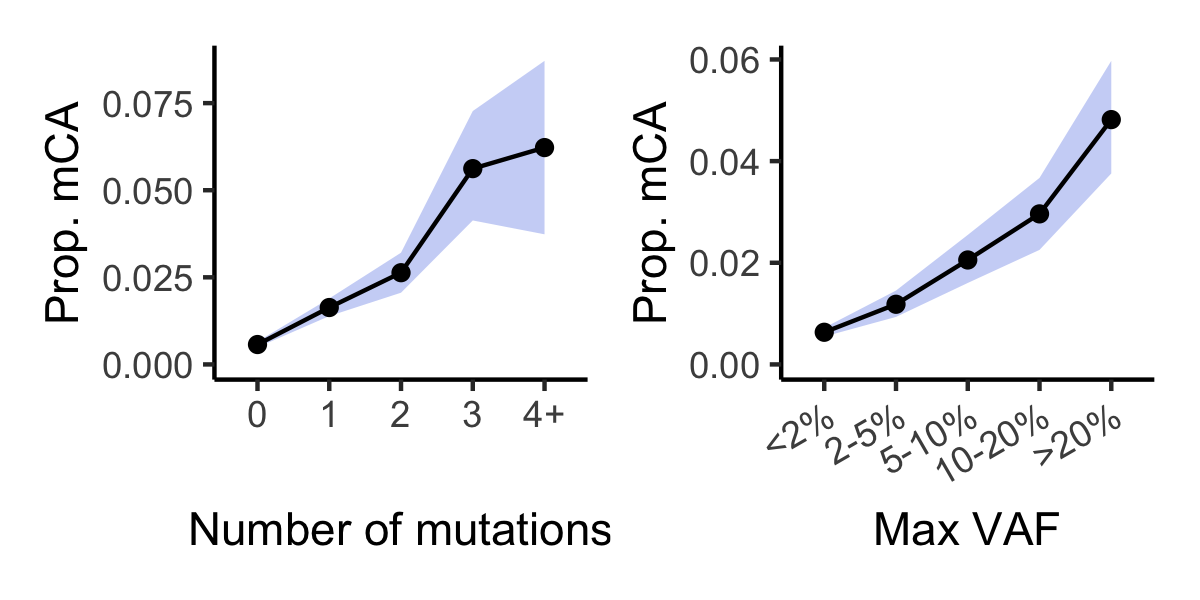

In [93]:
D = M_wide %>% 
    mutate(mutnum_bin = ifelse(mutnum_nonsilent >= 4, '4+', as.character(mutnum_nonsilent))) %>%
    group_by(mutnum_bin) %>%
    summarise(
        n_cnv = sum(ch_cnv),
        total = n(),
        prop = n_cnv/total,
        `.groups` = 'drop'
    ) %>%
    rowwise() %>%
    mutate(
        # (03/22/2021) 90% confidence interval - may be inexact!
        prop_lower = qbinom(p = 0.05, size = total, prob = prop)/total,
        prop_upper = qbinom(p = 0.95, size = total, prob = prop)/total,
        # (03/22/2021) uncomment below code to generate exact 95% intervals
#         prop_lower = binom.test(x = n_cnv, n = total, p = 0.5)$conf[1],
#         prop_upper = binom.test(x = n_cnv, n = total, p = 0.5)$conf[2]
    ) %>%
    ungroup()

p_mutnum = ggplot(
        D,
        aes(x = mutnum_bin, y = prop, group = '', ymin = prop_lower, ymax = prop_upper)
    ) +
    geom_ribbon(fill = 'royalblue', alpha = 0.3) +
    geom_line(color = 'black') +
    geom_point(color = 'black') +
    theme_classic() +
    ylab('Prop. mCA') +
    xlab('Number of mutations') +
    scale_y_continuous(expand = expansion(mult = 0.05), limits = c(0,NA))

display(D)


D = M_wide %>%
    mutate(VAF_bin = case_when(
        VAF_trans == 0 ~ '<2%',
        VAF_trans < 0.05 ~ '2-5%',
        VAF_trans < 0.1 ~ '5-10%',
        VAF_trans < 0.2 ~ '10-20%',
        T ~ '>20%'
    )) %>%
    arrange(VAF_trans) %>%
    mutate(VAF_bin = factor(VAF_bin, unique(VAF_bin))) %>%
    group_by(VAF_bin) %>%
    summarise(
        n_cnv = sum(ch_cnv),
        total = n(),
        prop = n_cnv/total,
        `.groups` = 'drop'
    ) %>%
    rowwise() %>%
    mutate(
        # (03/22/2021) 90% confidence interval - may be inexact!
        prop_lower = qbinom(p = 0.05, size = total, prob = prop)/total,
        prop_upper = qbinom(p = 0.95, size = total, prob = prop)/total,
        # (03/22/2021) uncomment below code to generate exact 95% intervals
#         prop_lower = binom.test(x = n_cnv, n = total, p = 0.5)$conf[1],
#         prop_upper = binom.test(x = n_cnv, n = total, p = 0.5)$conf[2]
    ) %>%
    ungroup()

display(D)

             
p_vaf = ggplot(
        D,
        aes(x = VAF_bin, y = prop, ymin = prop_lower, ymax = prop_upper, group = '')
    ) +
    geom_ribbon(fill = 'royalblue', alpha = 0.3) +
    geom_line(color = 'black') +
    geom_point(color = 'black') +
    theme_classic() +
    ylab('Prop. mCA') +
    xlab('Max VAF') +
    scale_y_continuous(expand = expansion(mult = 0.05), limits = c(0,NA)) +
    theme(axis.text.x = element_text(angle = 30, hjust = 1))

panel = p_mutnum | p_vaf

do_plot(panel, 'mutnum_vaf.pdf', w = 4, h = 2)

## Cis interactions

In [163]:
cis_genes = c('DNMT3A', 'TET2', 'ASXL1', 'EZH2', 'TP53', 'ATM', 'CHEK2', 'PPM1D',
        'SRSF2', 'SF3B1', 'U2AF1', 'MPL', 'JAK2', 'TERT')

cis_gene_bed = gene_bed %>% filter(Gene %in% cis_genes)

overlap_gene = function(seg_chrom, seg_start, seg_end, window = 5e6) {
    
    res = cis_gene_bed %>% 
        mutate(overlap = chrom == seg_chrom & start > seg_start - window & end < seg_end + window) %>%
        pull(overlap) %>% as.integer()
    
    return(res)
}

cnv_overlaps = mapply(
        overlap_gene,
        segs_filtered$chrom, segs_filtered$start, segs_filtered$end
    ) %>%
    t %>%
    as.data.frame() %>%
    setNames(paste0(cis_gene_bed$Gene, '_cnv'))

display('overlapped gene with CNV')

segs_filtered = cbind(
    segs_filtered %>% 
        select_if((!colnames(.) %in% colnames(cnv_overlaps)) | colnames(.) == 'dmp_patient_id'), 
    cnv_overlaps)

segs_filtered = segs_filtered %>%
    mutate_at(colnames(cnv_overlaps), list(amp = function(x){x * (.[['type']] == 'amp')})) %>%
    mutate_at(colnames(cnv_overlaps), list(deloh = function(x){x * (.[['type']] %in% c('del', 'loh'))})) %>%
    mutate_at(colnames(cnv_overlaps), list(del = function(x){x * (.[['type']] == 'del')})) %>%
    mutate_at(colnames(cnv_overlaps), list(loh = function(x){x * (.[['type']] == 'loh')}))

GENE_CNV = segs_filtered %>% 
    group_by(dmp_patient_id) %>%
    summarise_at(
        str_subset(colnames(.), '_cnv'),
        max
    )

M_wide = M_wide %>%
    select_if((!colnames(.) %in% colnames(GENE_CNV)) | colnames(.) == 'dmp_patient_id') %>%
    left_join(
        GENE_CNV,
        by = "dmp_patient_id",
        fill = 0
    ) %>%
    mutate_at(colnames(GENE_CNV), function(x){ifelse(is.na(x), 0, x)})

display('merging with main dataframe')

GENEALL = M_long %>%
    reshape2::dcast(
      formula = dmp_patient_id ~ Gene,
      value.var = 'Gene',
      fun.aggregate = function(x) {min(1, length(x))}
    ) %>%
    setNames(c('dmp_patient_id', paste0(colnames(.)[-1], '_all')))

M_wide = M_wide %>%
    select_if((!colnames(.) %in% colnames(GENEALL)) | colnames(.) == 'dmp_patient_id') %>%
    left_join(GENEALL, by = "dmp_patient_id") %>%
    mutate_at(colnames(GENEALL), function(x){ifelse(is.na(x), 0, x)})

segs_filtered = segs_filtered %>%
    select_if((!colnames(.) %in% colnames(GENEALL)) | colnames(.) == 'dmp_patient_id') %>%
    left_join(GENEALL, by = "dmp_patient_id") %>%
    mutate_at(colnames(GENEALL), function(x){ifelse(is.na(x), 0, x)})

[1] "overlapped gene with CNV"

[1] "merging with main dataframe"

In [164]:
cis_effects = data.frame()

for (gene in cis_genes) {
        
    D = M_wide %>% filter(!is.na(get(gene)))
    
    sm_count = sum(D[[paste0(gene, '')]])
    cnv_count = sum(D[[paste0(gene, '_cnv')]])
    del_count = sum(D[[paste0(gene, '_del')]])
    loh_count = sum(D[[paste0(gene, '_loh')]])
    intersect_cnv = sum(D[[paste0(gene, '')]] == 1 & D[[paste0(gene, '_cnv')]] == 1)
    intersect_del = sum(D[[paste0(gene, '')]] == 1 & D[[paste0(gene, '_cnv_del')]] == 1)
    intersect_loh = sum(D[[paste0(gene, '')]] == 1 & D[[paste0(gene, '_cnv_loh')]] == 1)
    
    #  pval_all = fisher.test(table(D[[paste0(gene, '')]], D[[paste0(gene, '_cnv')]]))$p.value

    if (intersect_del >= 2) {
        
        pval = fisher.test(table(D[[paste0(gene, '')]], D[[paste0(gene, '_cnv_del')]]))$p.value
        
        cis_effects = rbind(
            cis_effects,
            data.frame(
                'Gene' = gene,
                'cnv_type' = 'del',
                'sm_count' = sm_count,
                'cnv_count' = del_count,
                'intersect_count' = intersect_del,
                'pval' = pval
            )
        )
    }
    
    if (intersect_loh >= 2) {
        
        pval = fisher.test(table(D[[paste0(gene, '')]], D[[paste0(gene, '_cnv_loh')]]))$p.value
        
        cis_effects = rbind(
            cis_effects,
            data.frame(
                'Gene' = gene,
                'cnv_type' = 'loh',
                'sm_count' = sm_count,
                'cnv_count' = del_count,
                'intersect_count' = intersect_loh,
                'pval' = pval
            )
        )
    }
}

cis_effects = cis_effects %>% mutate(q = p.adjust(pval, method = 'BH', n = length(cis_genes) * 2))

cis_effects = cis_effects %>%
    mutate(Gene = as.character(Gene)) %>%
    left_join(gene_bed, by = 'Gene') %>%
    arrange(chrom) %>% mutate(Gene = factor(Gene, unique(Gene)))

In [165]:
gene_cnvs = function(gene, qval) {
    
    all_colors = c(
        'amp' = 'darkblue', 'loh' = 'darkgreen', 'del' = 'darkred',
        'Regulatory' = 'darkturquoise', 'Missense' = 'salmon', 'Truncating' = 'purple') 

    gene_chrom = gene_bed %>% filter(Gene == gene) %>% pull(chrom)
    
    gene_structure = gene_structures %>% filter(str_detect(description, gene))

    gene_locs = gene_bed %>% 
        filter(Gene == gene) %>%
        as.data.frame(stringsAsFactors = F) %>%
        mutate(loc = as.integer((start + end) / 2), chrom = as.integer(chrom))

    this_chrom_lens = chrom_lens %>% filter(chrom == gene_chrom)

    acen_chrom = acen %>% filter(chrom == gene_chrom)

    D = segs_filtered %>%
        filter(chrom == gene_chrom) %>%
        mutate(chrom = factor(chrom)) %>%
        group_by(dmp_sample_id, chrom) %>%
        mutate(total_length = sum(size)) %>%
        mutate(type = factor(type, c('amp', 'loh', 'del'))) %>%
        arrange(desc(type), round(start/1e7), -total_length) %>%
        group_by(chrom) %>%
        mutate(index = as.integer(factor(dmp_sample_id, unique(dmp_sample_id)))) %>%
        ungroup()

    M_overlap = M_long %>%
        filter(Gene == gene) %>%
        filter(dmp_patient_id %in% D$dmp_patient_id) %>%
        rowwise() %>%
        filter(
            any(chrom == D$chrom & dmp_patient_id == D$dmp_patient_id)
#                 start >= D$start - window & start <= D$end + window)
        ) %>%
        left_join(
            D %>% select(dmp_sample_id, index),
            by = 'dmp_sample_id'
        ) %>%
        ungroup() %>%
        mutate(VariantClass = case_when(
            VariantClass %in% c('Silent', 'Intron') ~ 'noncoding',
            T ~ 'coding'
        ))

    p_segs = ggplot(
            D,
            aes(x = start, xend = end, y = index, yend = index, color = type)
        ) +
        geom_rect(
            inherit.aes = F,
            data = acen_chrom,
            aes(xmin = cen_start, xmax = cen_end, ymin = -Inf, ymax = Inf),
            fill = 'gray',
            size = 0,
            alpha = 0.3
        ) +
        geom_segment(
            size = 1,
            alpha = 0.8,
            lineend = 'round'
        ) +
        geom_segment(
            inherit.aes = F,
            data = this_chrom_lens,
            aes(x = 0, xend = length, y = 0, yend = 0),
            color = 'black',
            size = 0
        ) +
        # label the mutations
#         geom_point(
#             inherit.aes = F,
#             mapping = aes(x = start, y = index, color = VariantClass2),
#             data = M_overlap,
#             size = 6.5,
#             pch = '*',
#             color = 'white'
#         ) +
        geom_point(
            inherit.aes = F,
            mapping = aes(x = start, y = index, fill = VariantClass2),
            data = M_overlap,
            size = 1.5,
            color = 'black',
            pch = 21
        ) +
#         geom_text_repel(
#             inherit.aes = F,
#             mapping = aes(x = start, y = index, color = VariantClass2, label = AAchange),
#             data = M_overlap %>% mutate(zoom = TRUE),
#             size = 1.5,
#             segment.size = 0.2,
#             color = 'black',
#             ylim = c(0,NA)
#         ) +
        scale_alpha(
            range = c(0, 1)
        ) +
        theme_classic() +
        theme(
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            axis.title = element_blank(),
            legend.position = 'none',
            panel.spacing.y = unit(1, "mm"),
            plot.margin = unit(c(0.5,0.2,0.2,0.2), "lines"),
            strip.text.y = element_blank(),
            panel.border = element_rect(size = 0.2, fill = NA, color = 'gray'),
            strip.background = element_rect(size = 0.5, fill = 'seashell3', color = 'seashell3'),
            plot.title = element_text(size = 7)
        ) +
        scale_y_discrete(expand = expansion(add = 1)) +
        xlab('') +
        ylab('') +
        scale_color_manual(values = all_colors) +
        scale_fill_manual(values = all_colors) +
        ggtitle(paste0(gene, ', chr', gene_chrom)) +
        # exon structures
        geom_segment(
            inherit.aes = F,
            data = gene_structure %>% mutate(zoom = TRUE),
            aes(x = min(start), xend = max(end), y = -1, yend = -1),
            size = 0.1,
            color = 'black'
        ) +
        geom_segment(
            inherit.aes = F,
            data = gene_structure %>% mutate(zoom = TRUE),
            aes(x = start, xend = end, y = -1, yend = -1),
            size = 2,
            color = 'black'
        ) +
        facet_zoom(
            zoom.size = 1,
            zoom.data = zoom,
            xlim = c(gene_locs$start, gene_locs$end)
        )

    p_segs
}

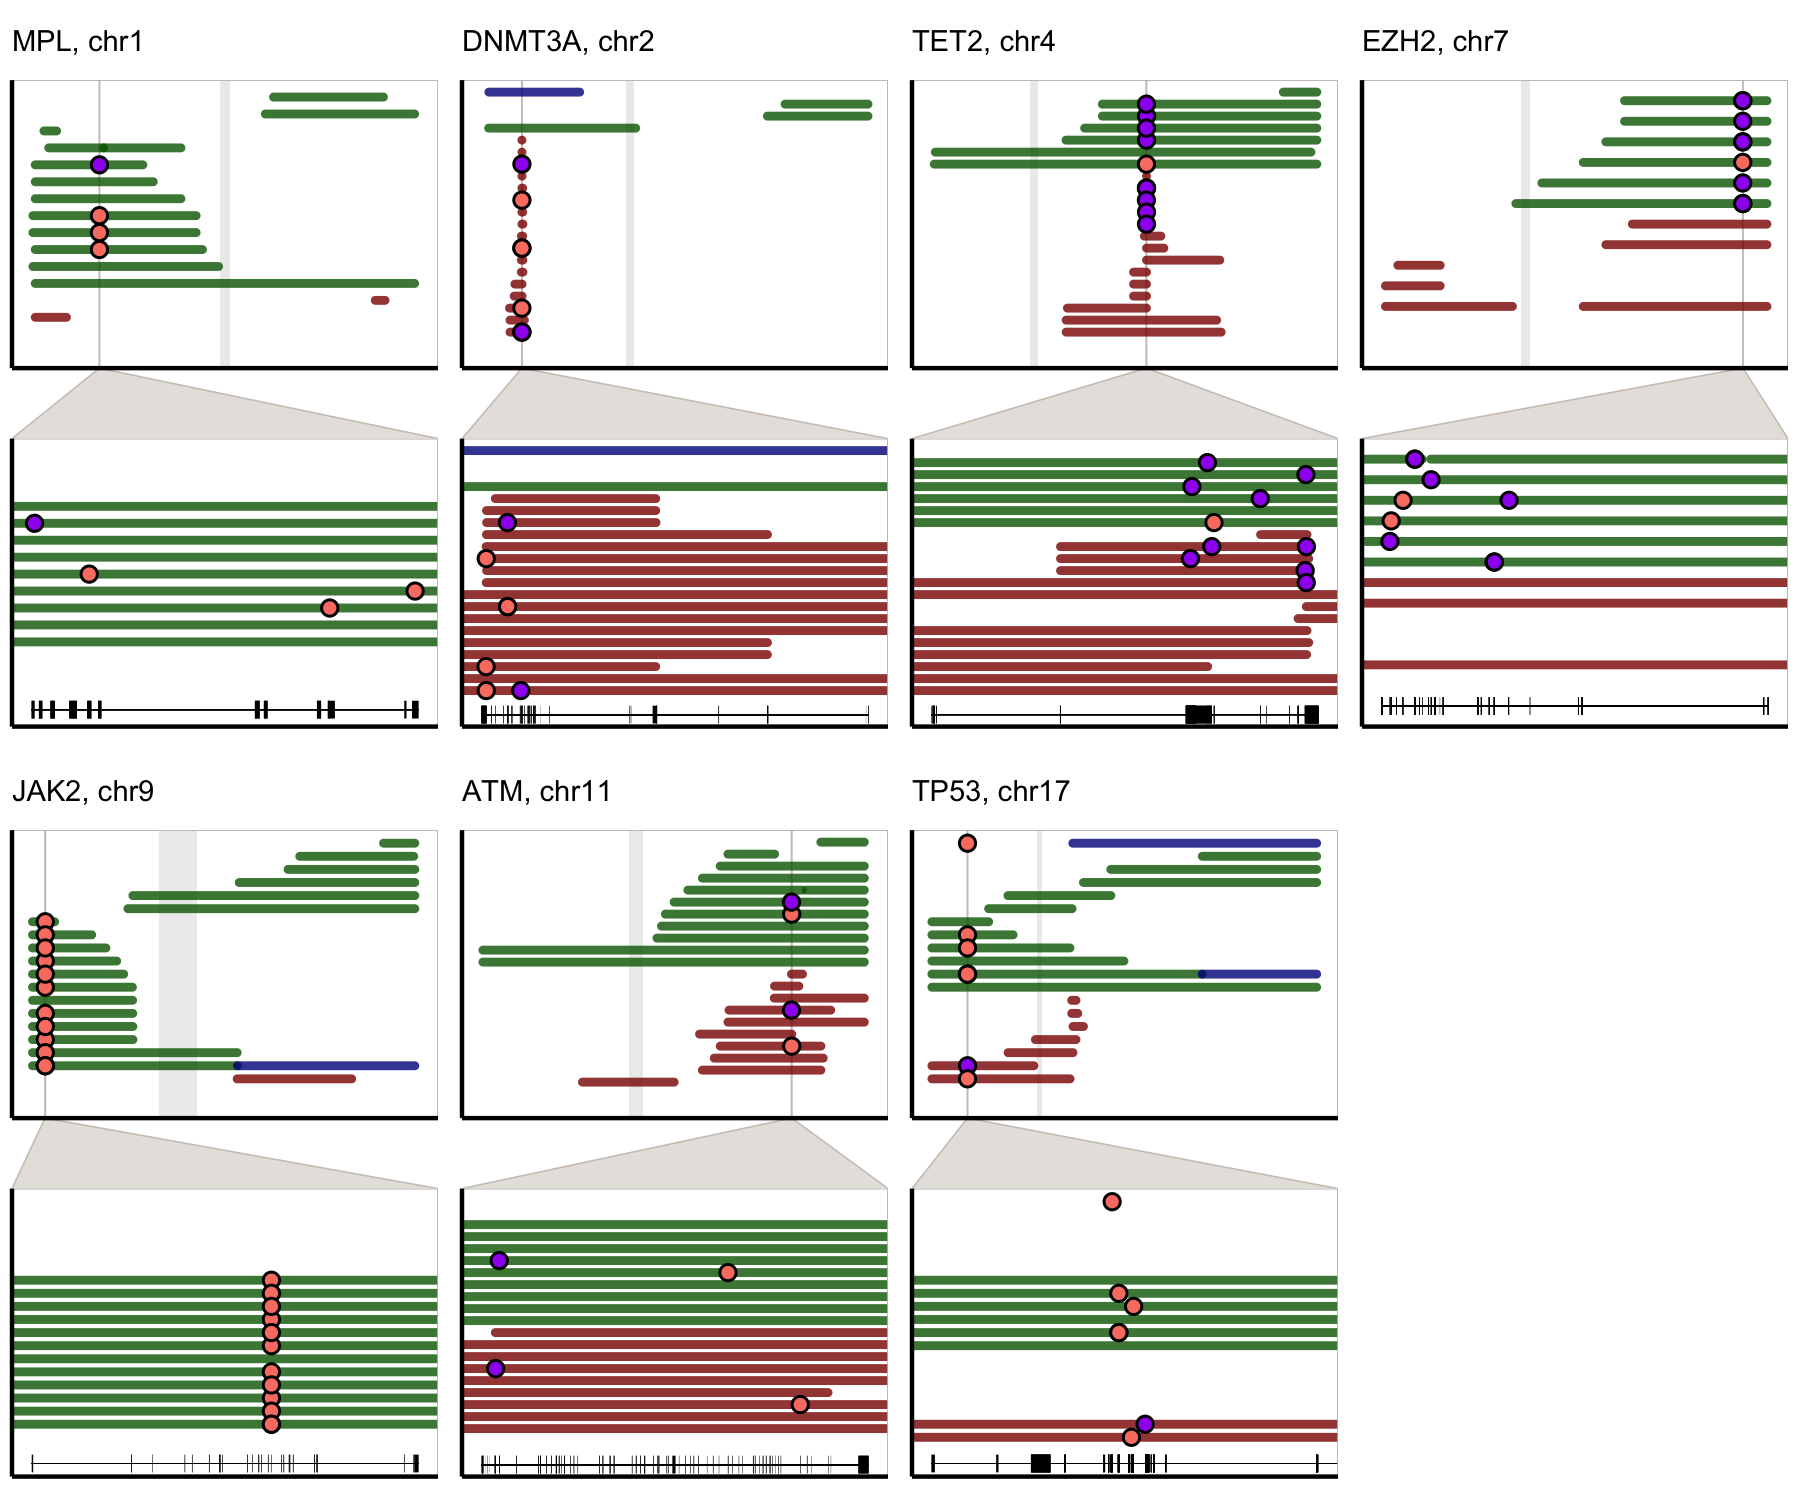

In [166]:
plots = list()

for (i in 1:nrow(cis_effects)) {
    gene = as.character(cis_effects[i,'Gene'])
    qval = cis_effects[i,'q']
    pval = cis_effects[i,'pval']
    plots[[gene]] = gene_cnvs(gene, pval)
}

p_cis = plot_grid(plotlist = plots, nrow = 2)

do_plot(p_cis, 'cis_loci.pdf', w = 6, h = 5)

In [167]:
cis_total = sum(cis_effects$intersect_count)
cis_total %>% paste0(' total cis events')
(cis_total/nrow(segs_filtered_auto)) %>% signif(3) %>% {.*100} %>% paste0('% of total events')

[1] "44 total cis events"

[1] "13.1% of total events"

In [48]:
window = 5e6

segs_filtered_auto = segs_filtered %>% filter(chrom != 23)

M_overlap = M_long %>%
    filter(dmp_patient_id %in% segs_filtered_auto$dmp_patient_id) %>%
    rowwise() %>%
    mutate(
        locality = ifelse(
            any(chrom == segs_filtered_auto$chrom & dmp_patient_id == segs_filtered_auto$dmp_patient_id &
                start >= segs_filtered_auto$start - window & start <= segs_filtered_auto$end + window
            ),
            'cis',
            'trans'
        )
    ) %>%
    ungroup() %>%
    mutate(variant_type = case_when(
        VariantClass %in% c('Silent', 'Intron') ~ 'noncoding',
        T ~ 'coding'
    ))


M_overlap_nonsilent = M_overlap %>% filter(variant_type == 'coding')

segs_filtered_auto %>%
    rowwise() %>%
    mutate(
        cis_coding = as.integer(
            any(chrom == M_overlap_nonsilent$chrom & dmp_patient_id == M_overlap_nonsilent$dmp_patient_id &
                M_overlap_nonsilent$start >= start - window & M_overlap_nonsilent$start <= end + window
            ))
    ) %>%
    group_by(type) %>%
    summarise(
        n = n(),
        prop_cis = sum(cis_coding)/n
    )

`summarise()` ungrouping output (override with `.groups` argument)



type n   prop_cis  
1 amp   56 0.08928571
2 del  156 0.08333333
3 loh  123 0.27642276

## Global interactions

In [182]:
genes = c('DNMT3A', 'TET2', 'ASXL1', 'EZH2', 'TP53', 'ATM', 'CHEK2', 'PPM1D',
        'SRSF2', 'SF3B1', 'U2AF1', 'MPL', 'JAK2', 'TERT')

res = data.frame()

# don't test for all if chrom has predominately one kind of change
single_type_chroms = segs_filtered %>% 
    count(chrom, type) %>% 
    group_by(chrom) %>%
    mutate(total = sum(n)) %>%
    mutate(prop = n/total) %>% 
    filter(prop > 0.7) %>% pull(chrom) %>%
    paste0('chr', .)

chroms_detailed = colnames(CNV_detailed)[-1][(CNV_detailed[,-1] %>% colSums) > 3]
chroms_broad = colnames(CNV)[-1][(CNV[,-1] %>% colSums) > 3]
chroms_broad = chroms_broad[chroms_broad != 'ch_cnv']
chroms_broad = chroms_broad[!(chroms_broad %in% single_type_chroms)]
chroms = c(chroms_broad, chroms_detailed)
# chroms = chroms[str_extract(chroms, '\\d+') != 23]
# chroms = c(chroms, 'loy')

ntest = 0

for (gene in genes) {
    
    display(gene)
    gene_chrom = gene_bed %>% filter(Gene == gene) %>% pull(chrom)
    
    for (chrom in chroms) {
        
#         chroms[str_extract(chroms, '\\d+') != gene_chrom]
        
        ntest = ntest + 1
        
#         D = M_wide %>% filter(!cytopenia)
        D = M_wide
        
        counts = table(D[[gene]], D[[chrom]])
        
        if (ncol(counts) != 1) {
            
            if (chrom == 'chr23_del') {
                counts = table(D[D$Gender == 'Female',][[gene]], D[D$Gender == 'Female',][[chrom]])
            }

            if (chrom == 'loy') {
                counts = table(D[D$Gender == 'Male',][[gene]], D[D$Gender == 'Male',][[chrom]])
            }
            
            co = counts[2,2]

            if (co >= 2) {

                test = fisher.test(counts)
                res = rbind(res,
                    data.frame(
                        gene = gene,
                        chrom = chrom,
                        p = test$p.value,
                        OR = test$estimate,
                        co = co
                    ))
            }
            
        }
        
    }
}

ntest_broad = length(chroms_broad) * length(genes)
ntest_specific = (length(chroms) - length(chroms_broad)) * length(genes)

res = res %>% 
    mutate(category = ifelse(str_detect(chrom, '_'), 'broad', 'specific')) %>%
    mutate(q = ifelse(
        category == 'broad', 
        p.adjust(p, method = 'BH', n = ntest_broad),
        p.adjust(p, method = 'BH', n = ntest_specific)
    )) %>% 
    mutate(chrom = str_remove(chrom, 'chr')) %>%
#     mutate(q = p.adjust(p, method = 'BH', n = ntest)) %>%
    mutate(logOR = log2(OR))

[1] "DNMT3A"

[1] "TET2"

[1] "ASXL1"

[1] "EZH2"

[1] "TP53"

[1] "ATM"

[1] "CHEK2"

[1] "PPM1D"

[1] "SRSF2"

[1] "SF3B1"

[1] "U2AF1"

[1] "MPL"

[1] "JAK2"

[1] "TERT"

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 1 rows containing missing values (geom_tile).”
Warning message:
“Removed 1 rows containing missing values (geom_tile).”


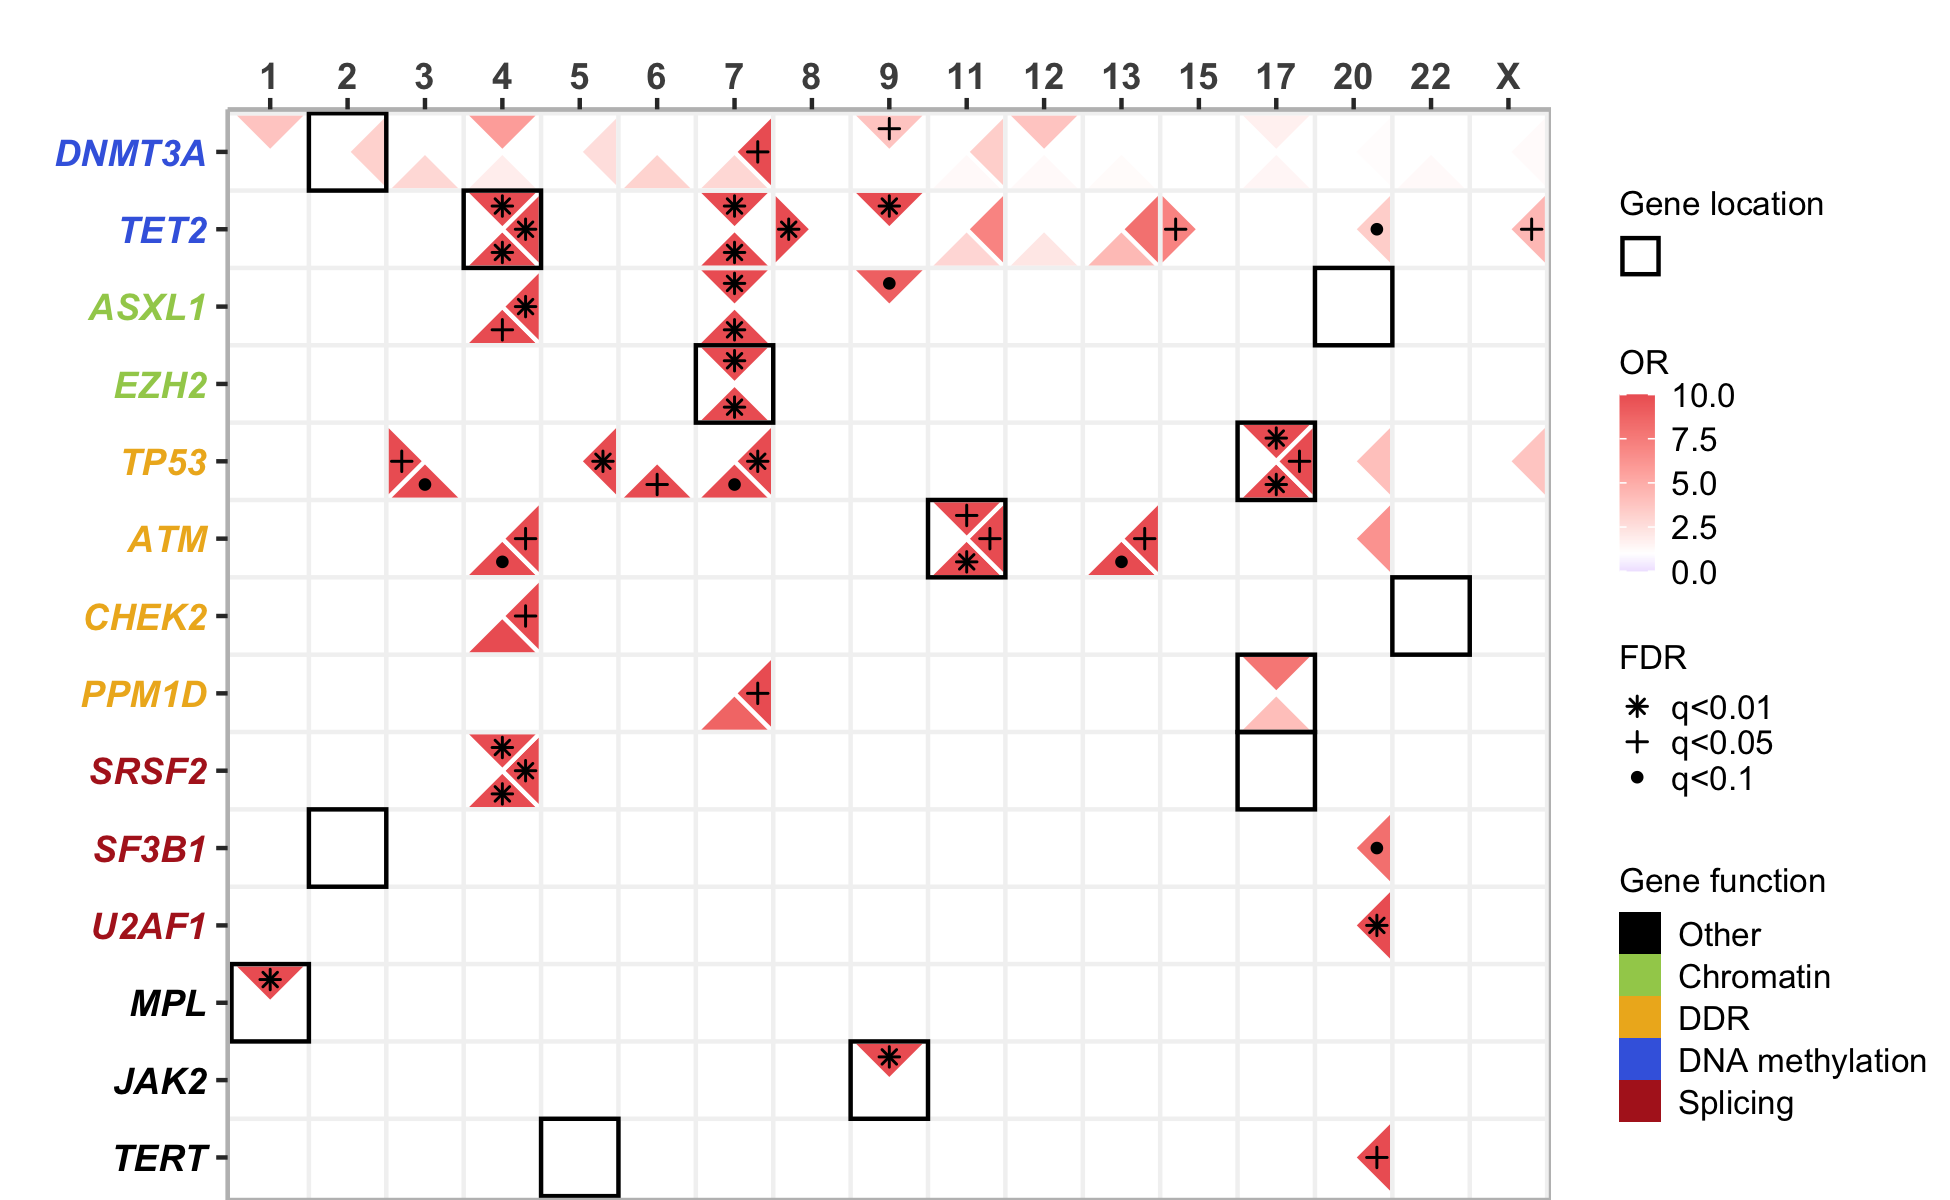

In [183]:
limor = 10
width = 0.5
star_dodge = 0.3
key_width = 0.7

ddr = c('TP53', 'PPM1D', 'CHEK2', 'ATM')
splicing = c('SRSF2', 'SF3B1', 'U2AF1')
dna_methylation = c('TET2', 'DNMT3A')
chromatin = c('ASXL1', 'EZH2')

genes = unique(res$gene)

gene_locations = gene_bed %>% filter(Gene %in% genes)

res = res %>% 
    mutate(signif_cat = case_when(
        q < 0.01 ~ 'q<0.01',
        q < 0.05 ~ 'q<0.05',
        q < 0.1 ~ 'q<0.1',
        T ~ 'ns'
    ))

D = res %>% 
    rowwise() %>%
    mutate(
        type = str_split(chrom, '_')[[1]][2],
        chrom = str_split(chrom, '_')[[1]][1]
    ) %>%
    mutate(type = ifelse(is.na(type), 'any', type)) %>%
    mutate(type = ifelse(chrom == 'loy', 'del', type)) %>%
    ungroup() %>%
    mutate(chrom = ifelse(chrom == 23, 'X', as.character(chrom))) %>%
    mutate(
        chrom = factor(chrom, gtools::mixedsort(unique(chrom))),
        gene = factor(gene, rev(genes))
    ) %>%
    mutate(
        chrom_i = as.integer(chrom),
        gene_i = as.integer(gene)
    )

D = D %>% mutate(gene_function = case_when(
    gene %in% dna_methylation ~ 'DNA methylation',
    gene %in% splicing ~ 'Splicing',
    gene %in% chromatin ~ 'Chromatin',
    gene %in% ddr ~ 'DDR',
    T ~ 'Other'
))

p_main = D %>%
    rbind(
        mutate(., 
            chrom_i = case_when(
                type == 'amp' ~ chrom_i - width,
                type == 'loh' ~ chrom_i - width,
                type == 'del' ~ chrom_i + width,
                type == 'any' ~ chrom_i - width,
            ),
            gene_i = case_when(
                type == 'amp' ~ gene_i + width,
                type == 'loh' ~ gene_i + width,
                type == 'del' ~ gene_i + width,
                type == 'any' ~ gene_i - width,
            )
        ),
        mutate(.,
            chrom_i = case_when(
                type == 'amp' ~ chrom_i - width,
                type == 'loh' ~ chrom_i + width,
                type == 'del' ~ chrom_i + width,
                type == 'any' ~ chrom_i + width,
            ), 
            gene_i = case_when(
                type == 'amp' ~ gene_i - width,
                type == 'loh' ~ gene_i + width,
                type == 'del' ~ gene_i - width,
                type == 'any' ~ gene_i - width,
            )
        )
    ) %>%
    rowwise() %>% mutate(OR = min(OR, limor), logOR = log2(OR)) %>% ungroup() %>%
    ggplot(
        aes()
    ) +
    theme_classic() +
    geom_polygon(
        aes(x = chrom_i, y = gene_i, group = paste0(gene, chrom, type), fill = OR),
        color = 'white',
        size = 0.5,
#         alpha = 1
    ) +
    geom_vline(data = D, aes(xintercept = chrom_i + 0.5), color = 'gray95') +
    geom_hline(data = D, aes(yintercept = gene_i + 0.5), color = 'gray95') +
    geom_point(
        aes(x = case_when(
                type == 'loh' ~ as.numeric(chrom_i),
                type == 'del' ~ as.numeric(chrom_i) + star_dodge,
                type == 'amp' ~ as.numeric(chrom_i) - star_dodge,
                type == 'any' ~ as.numeric(chrom_i)
            ),
            y = case_when(
                type == 'loh' ~ gene_i + star_dodge,
                type == 'del' ~ as.numeric(gene_i),
                type == 'amp' ~ as.numeric(gene_i),
                type == 'any' ~ as.numeric(gene_i) - star_dodge
            ),
            pch = signif_cat
        ),
        data = D %>% filter(q < 0.1),
        color = 'black',
        size = 1.3
    ) +
    geom_tile(
        data = gene_locations %>% 
            mutate(
                chrom_i = as.integer(factor(chrom, levels(D$chrom))),
                gene_i = as.integer(factor(Gene, levels(D$gene)))
            ),
        aes(x = chrom_i, y = gene_i, linetype = ' '),
        alpha = 0,
        color = 'black',
        size = 0.5
    ) +
    scale_fill_gradient2(low = 'blue', high = 'indianred2', mid = 'white', na.value = 'white', midpoint = 1, limits = c(0, limor)) +
#     scale_fill_manual(values = c(cnv_pal, 'any' = 'darkorange')) +
    ylab('') +
    xlab('') +
    scale_x_continuous(
        expand = expansion(add = 0.05),
        labels = levels(D$chrom),
        breaks = 1:length(levels(D$chrom)),
        position = "top"
    ) +
    scale_y_continuous(
        expand = expansion(add = 0.05), labels = levels(D$gene), breaks = 1:length(levels(D$gene))
    ) +
    theme(
        plot.margin = unit(c(0,0,0,0), 'mm'),
        axis.text.y = element_text(
            face = 'bold.italic',
            color = case_when(
                as.character(levels(D$gene)) %in% dna_methylation ~ 'royalblue',
                as.character(levels(D$gene)) %in% splicing ~ 'firebrick',
                as.character(levels(D$gene)) %in% chromatin ~ 'darkolivegreen3',
                as.character(levels(D$gene)) %in% ddr ~ 'goldenrod2',
                T ~ 'black'
            )
        ),
        axis.text.x = element_text(
            face = 'bold'
        ),
        legend.key.size = unit(0.3, 'cm'),
        legend.position = 'right',
        panel.border = element_rect(color = 'gray', fill = NA),
        axis.line = element_line(color = 'gray'),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8),
        legend.spacing = unit(2, 'mm')
    ) +
    scale_shape_manual(values = c('q<0.01' = 8, 'q<0.05' = 3, 'q<0.1' = 20), name = 'FDR') +
    geom_text(
        data = D %>% distinct(gene, gene_function) %>% mutate(gene_function = relevel(factor(gene_function), 'Other')),
        aes(x = 1, 
            y = 1,
            color = gene_function,
            label = gene),
        size = 0,
        key_glyph = draw_key_rect
    ) +
#     scale_alpha_continuous(range = c(0, 0.5)) +
    scale_color_manual(
        values = c(
            'DNA methylation' = 'royalblue', 
            'Splicing' = 'firebrick', 
            'Chromatin' = 'darkolivegreen3',
            'DDR' = 'goldenrod2',
            'Other' = 'black'
        )
    ) +
    guides(
        color = guide_legend(keyheight = key_width, keywidth = key_width, title = 'Gene function', override.aes = list(size = 3)),
#         alpha = guide_legend(keyheight = key_width, keywidth = key_width),
#         fill = guide_legend(keyheight = key_width, keywidth = key_width, override.aes = list(alpha = 0.5)),
        linetype = guide_legend(title = 'Gene location', keyheight = key_width, keywidth = key_width)
    )

do_plot(p_main, 'trans_heatmap.pdf', w = 6.5, h = 4)

# GM CNV VAF correlation

Warning message:
“Removed 50 row(s) containing missing values (geom_path).”
Warning message:
“Removed 50 row(s) containing missing values (geom_path).”


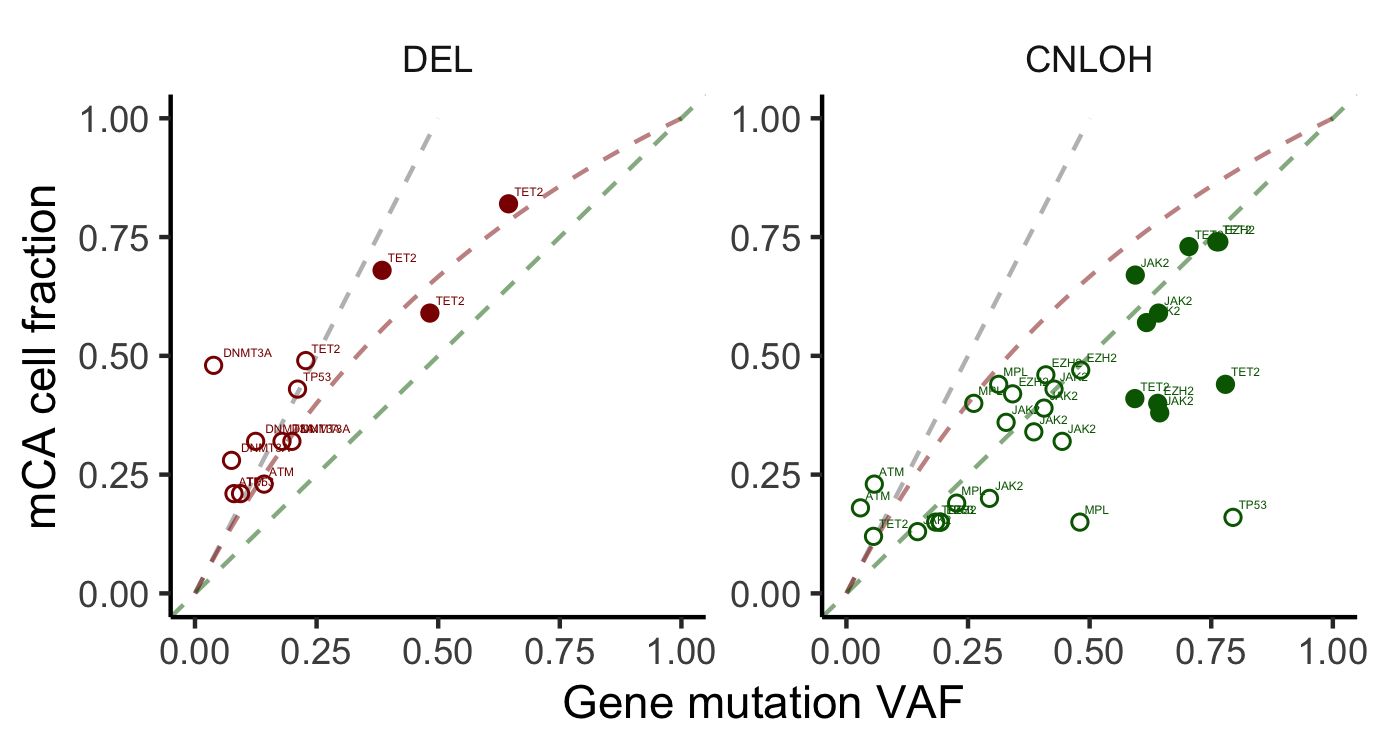

In [170]:
window = 1e7

M_overlap = M_long %>%
    filter(dmp_patient_id %in% segs_filtered$dmp_patient_id) %>%
    rowwise() %>%
    filter(
        any(chrom == segs_filtered$chrom & dmp_patient_id == segs_filtered$dmp_patient_id &
           start >= segs_filtered$start - window & start <= segs_filtered$end + window)
    ) %>%
    ungroup() %>%
    mutate(VariantClass = case_when(
        VariantClass %in% c('Silent', 'Intron') ~ 'noncoding',
        str_detect(VariantClass, 'Del|Ins') ~ 'indel',
        T ~ 'snv'
    )) %>%
    filter(VariantClass != 'noncoding') %>%
    filter(Gene %in% c("EZH2", "ATM", "TET2", "JAK2", "MPL", 'DNMT3A', 'TP53')) %>%
    arrange(desc(VAF_N)) %>%
    distinct(dmp_patient_id, `.keep_all` = T)
    

p_vaf = segs_filtered %>%
    left_join(
        M_overlap %>% select(dmp_patient_id, chrom, sm_pos = start, Gene, VariantClass, VAF_N),
        by = c('chrom', 'dmp_patient_id')
    ) %>%
    filter(type != 'amp') %>%
    filter(VAF_N > 0) %>%
    mutate(
        phi_sm = case_when(
            type == 'del' ~ 2 * VAF_N/(1 + VAF_N),
            type == 'loh' ~ VAF_N
        )
    ) %>% arrange(phi, ascending = FALSE) %>% distinct(dmp_patient_id, sm_pos, .keep_all = TRUE) %>% 
    mutate(pigeonhole = phi_sm + phi > 1) %>%
    ggplot(
        aes(x = VAF_N, y = phi, color = type2, label = Gene)
    ) +
    # stat_function(fun = function(v){2*v}, linetype = 'dashed', color = cnv_pal['err']) +
    # stat_function(fun = function(v){2 * v/(1+v)}, linetype = 'dashed', color = cnv_pal['del'], alpha = 0.5) +
    # geom_abline(linetype = 'dashed', color = cnv_pal['loh'], alpha = 0.5) +
    stat_function(fun = function(v){2 * v}, linetype = 'dashed', color = cnv_pal['err']) +
    stat_function(fun = function(v){2 * v/(1+v)}, linetype = 'dashed', color = cnv_pal['del'], alpha = 0.5) +
    geom_abline(linetype = 'dashed', color = cnv_pal['loh'], alpha = 0.5) +
#     annotate('text', x = 0.35, y = 1, label = 'trans', color = cnv_pal['err'], size = 3) +
#     annotate('text', x = 0.75, y = 1, label = 'DEL', color = cnv_pal['del'], size = 3, alpha = 0.5) +
#     annotate('text', x = 0.9, y = 0.7, label = 'CNLOH', color = cnv_pal['loh'], size = 3, alpha = 0.5) +
    theme_classic() +
    # stat_cor(label.y = 0.95, size = 3) +
    scale_color_manual(values = cnv_pal2) +
    geom_point(
        aes(pch = pigeonhole),
#         pch = 21
    ) +
    scale_shape_manual(values = c('TRUE' = 19, 'FALSE' = 21)) +
    xlim(0,1) +
    ylim(0,1) +
    geom_text(size = 1, vjust = -1, hjust = -0.2) +
    facet_wrap(~type2, nrow = 1, scale = 'free') +
    theme(
        legend.position = 'none',
        strip.background = element_blank()
    ) +
    xlab('Gene mutation VAF') +
    ylab('mCA cell fraction')

do_plot(p_vaf, 'cis_vaf.pdf', w = 4.6, h = 2.5)
# do_plot(p_vaf, 'cis_vaf.pdf', w = 8, h = 5)

Warning message:
“Removed 50 row(s) containing missing values (geom_path).”
Warning message:
“Removed 145 rows containing missing values (geom_point).”
Warning message:
“Removed 50 row(s) containing missing values (geom_path).”
Warning message:
“Removed 145 rows containing missing values (geom_point).”


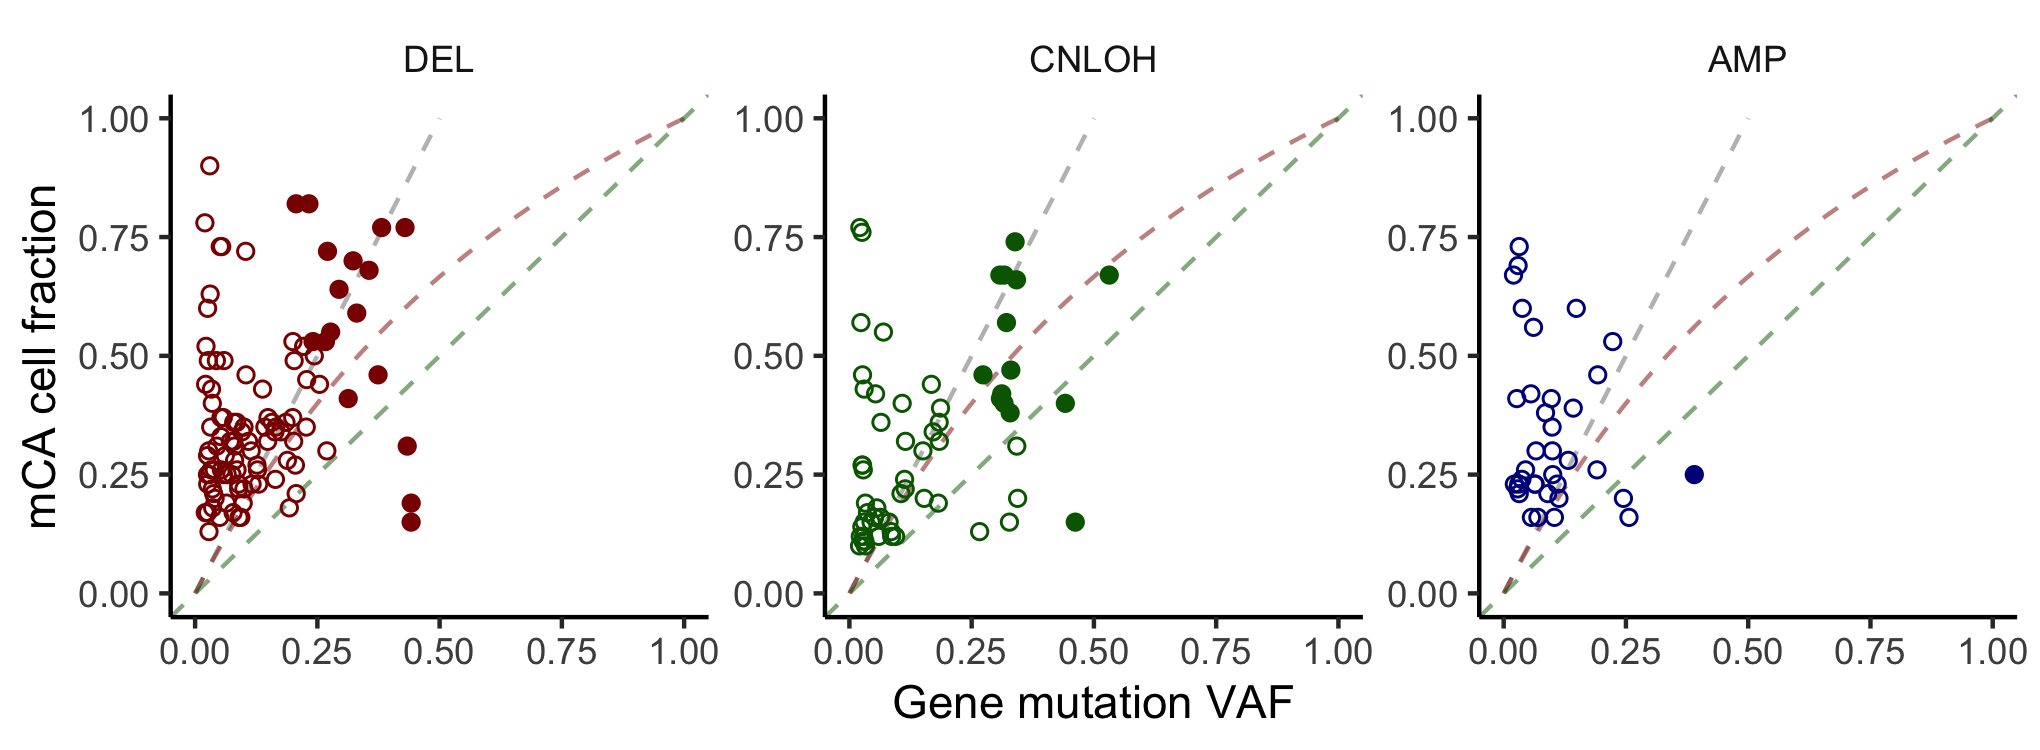

In [171]:
options(repr.plot.width = 6, repr.plot.height = 2.3, repr.plot.res = 300)

window = 1e7

M_overlap = M_long %>%
    filter(dmp_patient_id %in% segs_filtered$dmp_patient_id) %>%
    rowwise() %>%
    filter(
        !any(chrom == segs_filtered$chrom & dmp_patient_id == segs_filtered$dmp_patient_id &
           start >= segs_filtered$start - window & start <= segs_filtered$end + window)
    ) %>%
    ungroup() %>%
    mutate(VariantClass = case_when(
        VariantClass %in% c('Silent', 'Intron') ~ 'noncoding',
        str_detect(VariantClass, 'Del|Ins') ~ 'indel',
        T ~ 'snv'
    )) %>%
    filter(VariantClass != 'noncoding') %>%
    arrange(desc(VAF_N)) %>%
    distinct(dmp_patient_id, `.keep_all` = T)

p_vaf = segs_filtered %>%
    arrange(desc(phi)) %>%
    distinct(dmp_patient_id, `.keep_all` = T) %>%
    left_join(
        M_overlap %>% select(dmp_patient_id, chrom, sm_pos = start, Gene, VariantClass, VAF_N),
        by = c('dmp_patient_id')
    ) %>%
    mutate(pigeonhole = 2 * VAF_N + phi > 1) %>%
    ggplot(
        aes(x = VAF_N, y = phi, color = type2, label = Gene)
    ) +
    stat_function(fun = function(v){2*v}, linetype = 'dashed', color = cnv_pal['err']) +
    stat_function(fun = function(v){2 * v/(1+v)}, linetype = 'dashed', color = cnv_pal['del'], alpha = 0.5) +
    geom_abline(linetype = 'dashed', color = cnv_pal['loh'], alpha = 0.5) +
#     annotate('text', x = 0.35, y = 1, label = 'trans', color = cnv_pal['err'], size = 3) +
#     annotate('text', x = 0.75, y = 1, label = 'cis-del', color = cnv_pal['del'], size = 3, alpha = 0.5) +
#     annotate('text', x = 0.9, y = 0.7, label = 'cis-loh', color = cnv_pal['loh'], size = 3, alpha = 0.5) +
    theme_classic() +
    # geom_abline(linetype = 'dashed') +
    scale_shape_manual(values = c('TRUE' = 19, 'FALSE' = 21)) +
    # stat_cor(label.y = 0.98, size = 3) +
    scale_color_manual(values = cnv_pal2) +
    geom_point(
    #     pch = 21,
        aes(pch = pigeonhole)
    ) +
    xlim(0,1) +
    ylim(0,1) +
    # geom_text(size = 1, vjust = -1, hjust = -0.2) +
    # scale_shape_manual(values = c(1,5)) +
    facet_wrap(~type2, nrow = 1, scale = 'free') +
    theme(
        legend.position = 'none',
        strip.background = element_blank()
    ) +
    ylab('mCA cell fraction') +
    xlab('Gene mutation VAF')

do_plot(p_vaf, 'trans_vaf.pdf', w = 6.8, h = 2.5)

# Blood count phenotypes

`summarise()` regrouping output by 'group_label' (override with `.groups` argument)

Warning message:
“Removed 26252 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 26252 rows containing non-finite values (stat_bin).”


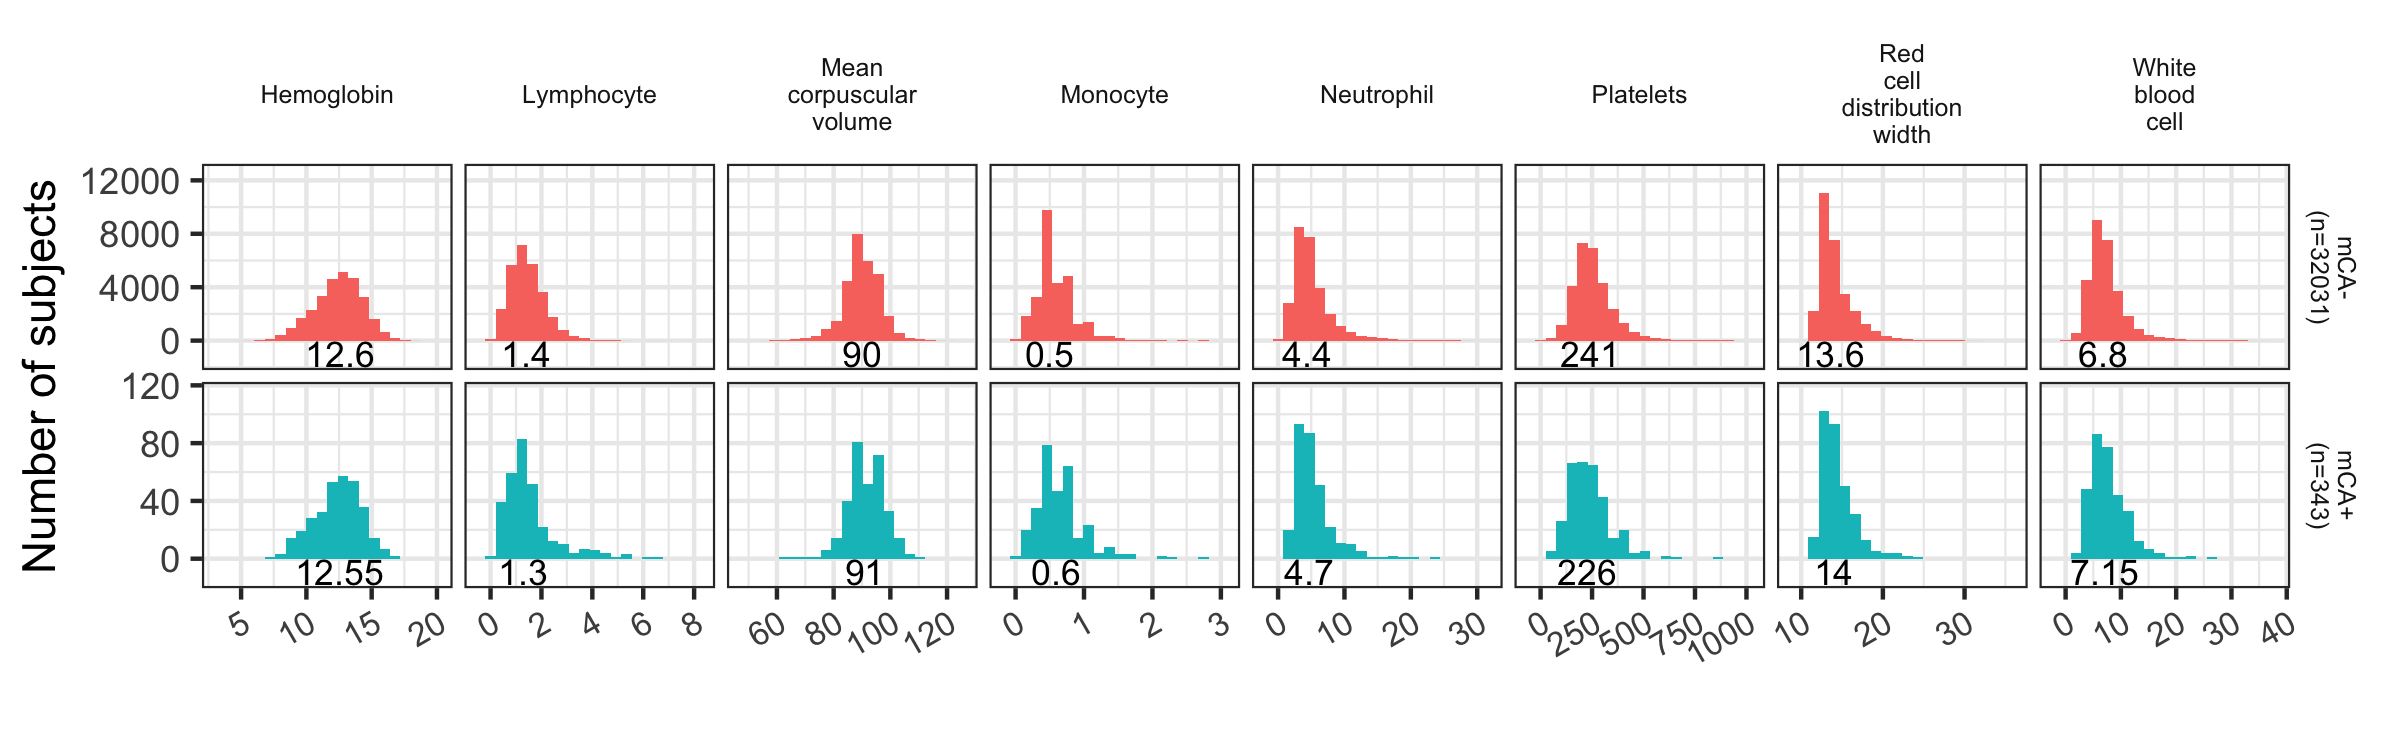

In [172]:
give.median <- function(x){
  return(c(x = median(x), label = median(x))) 
}

D = M_wide %>% 
    filter(anc < 30 & alc < 8 & amc < 3 & plt < 1000 | is.na(anc) | is.na(alc) | is.na(amc) | is.na(plt)) %>%
    mutate(group = ifelse(ch_cnv == 1, 'mCA+', 'mCA-')) %>%
    mutate(group = factor(group, c('mCA+', 'mCA-'))) %>%
    group_by(group) %>%
    mutate(n = n()) %>%
    ungroup() %>%
    mutate(group_label = paste0(group, '\n(n=', n, ')')) %>%
    mutate(group_label = factor(group_label, unique(group_label))) %>%
    reshape2::melt(measure.vars = cbcs[cbcs != 'rbc']) %>%
    mutate(variable = str_wrap(cbc_labels[variable], width = 3))

p_cbc = ggplot(
    D,
    aes(x = value, fill = group_label)
) +
geom_histogram(bins = 20, show.legend = F) +
# stat_summary(aes(y = 0), fun.data = give.median, geom = "text", vjust = 0, size = 2) +
facet_grid(group_label~variable, scale = 'free') +
scale_y_continuous(expand = c(0.2,0)) +
scale_x_continuous(expand = c(0.1,0)) +
geom_text(
    inherit.aes = F,
    data = D %>% group_by(group_label, variable) %>% summarise(median = median(na.omit(value))),
    mapping = aes(y = 0, x = median, label = median),
    size = 3,
    vjust = 1
) +
theme_bw() +
theme(
    panel.spacing = unit(1, "mm"),
    legend.position = 'top',
    legend.title = element_blank(),
    axis.text.x = element_text(size = 8, angle = 30, hjust = 1),
    strip.text = element_text(size = 6),
    strip.background = element_blank()
) +
xlab('') +
ylab('Number of subjects')

do_plot(p_cbc, 'cbc_dist.pdf', w = 8, h = 2.5)

## WHO criteria for cytopenia

`summarise()` regrouping output by 'group_label', 'group' (override with `.groups` argument)



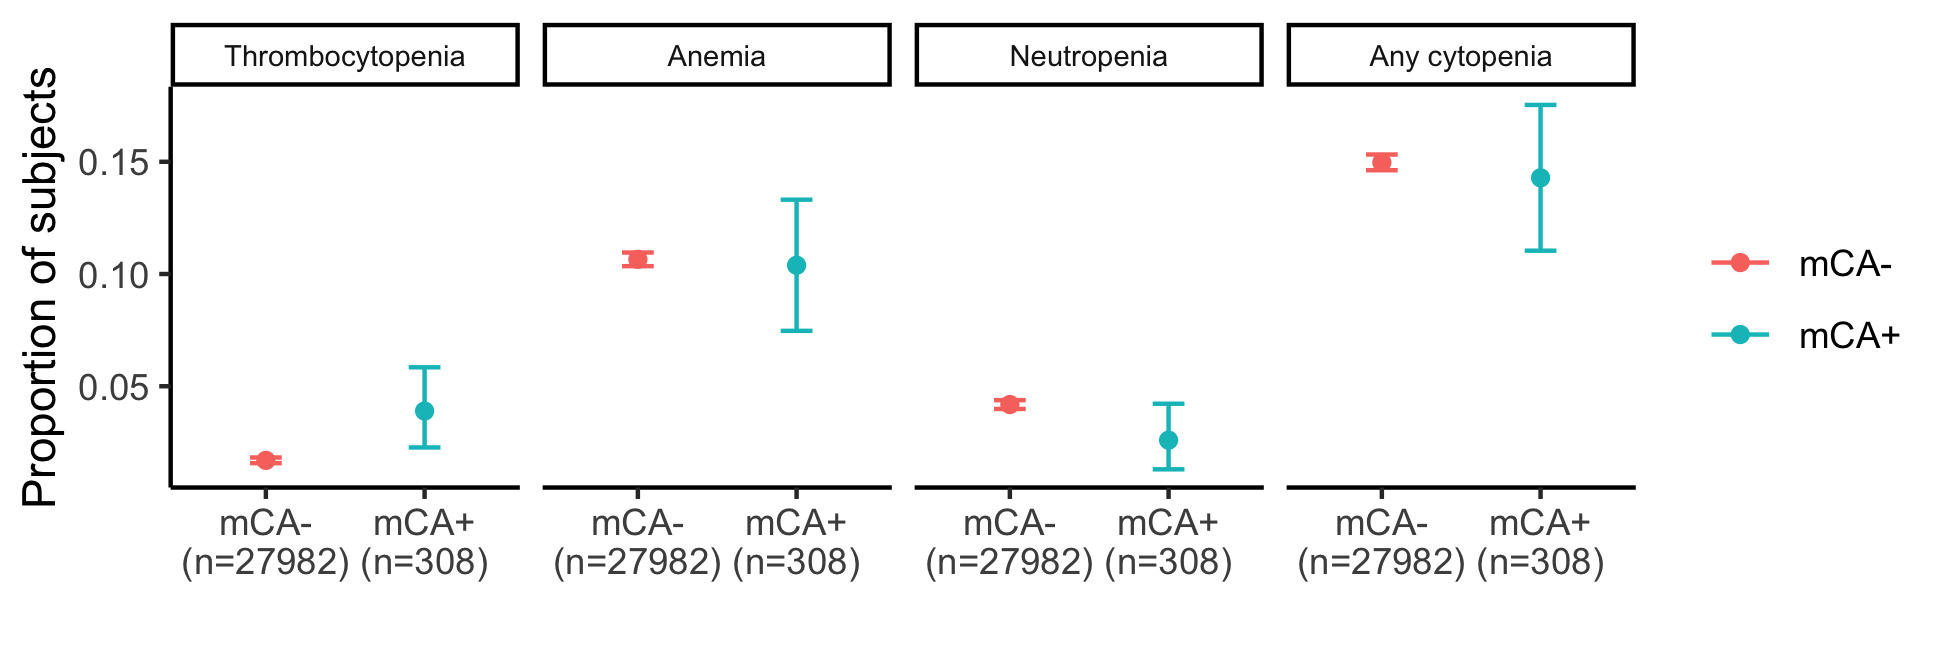

In [99]:
M_wide = M_wide %>% 
    mutate(
        thrombocytopenia = plt < 100,
        anemia = hgb < 10,
        neutropenia = anc < 1.8,
        cytopenia = thrombocytopenia | anemia | neutropenia
    )

D = M_wide %>% 
    mutate(group = factor(ifelse(ch_cnv == 1, 'mCA+', 'mCA-'), c('mCA-', 'mCA+'))) %>%
#     mutate(group = factor(group, c('none', 'sm', 'cnv', 'both'))) %>%
    select(group, thrombocytopenia, anemia, neutropenia, cytopenia) %>%
    filter(complete.cases(.)) %>%
    group_by(group) %>%
    mutate(n = n()) %>%
    ungroup() %>%
    mutate(group_label = paste0(group, '\n(n=', n, ')')) %>%
    mutate(group_label = factor(group_label, unique(group_label))) %>%
    reshape2::melt(measure.vars = c('thrombocytopenia', 'anemia', 'neutropenia', 'cytopenia')) %>%
    mutate(variable = ifelse(variable == 'cytopenia', 'any cytopenia', as.character(variable))) %>%
    mutate(variable = Hmisc::capitalize(variable)) %>%
    mutate(variable = factor(variable, unique(variable))) %>%
    group_by(group_label, group, variable) %>%
    summarise(
        total = n(),
        prop = sum(value)/total,
        cases = sum(value)
    ) %>%
    rowwise() %>%
    mutate(
        # (03/22/2021) 90% confidence interval - may be inexact!
        lower = qbinom(p = 0.05, size = total, prob = prop)/total,
        upper = qbinom(p = 0.95, size = total, prob = prop)/total,
        # (03/22/2021) uncomment below code to generate exact 95% intervals
#         lower = binom.test(x = cases, n = total, p = 0.5)$conf[1],
#         upper = binom.test(x = cases, n = total, p = 0.5)$conf[2]
    ) %>%
    ungroup()

p_cytopenia = ggplot(
    D,
    aes(x = group_label, y = prop, ymin = lower, ymax = upper, color = group)
) +
geom_errorbar(position = position_dodge(width = 0.3), width = 0.2) +
geom_point(position = position_dodge(width = 0.3)) +
theme_classic() +
facet_wrap(~variable, scale = 'free_x', nrow = 1) +
ylab('Proportion of subjects') +
xlab('') +
theme(
    legend.title = element_blank(),
    strip.text = element_text(size = 7),
#     legend.position = 'none'
)

do_plot(p_cytopenia, 'cytopenia.pdf', w = 6.5, h = 2.2)

# Hematological Cancers

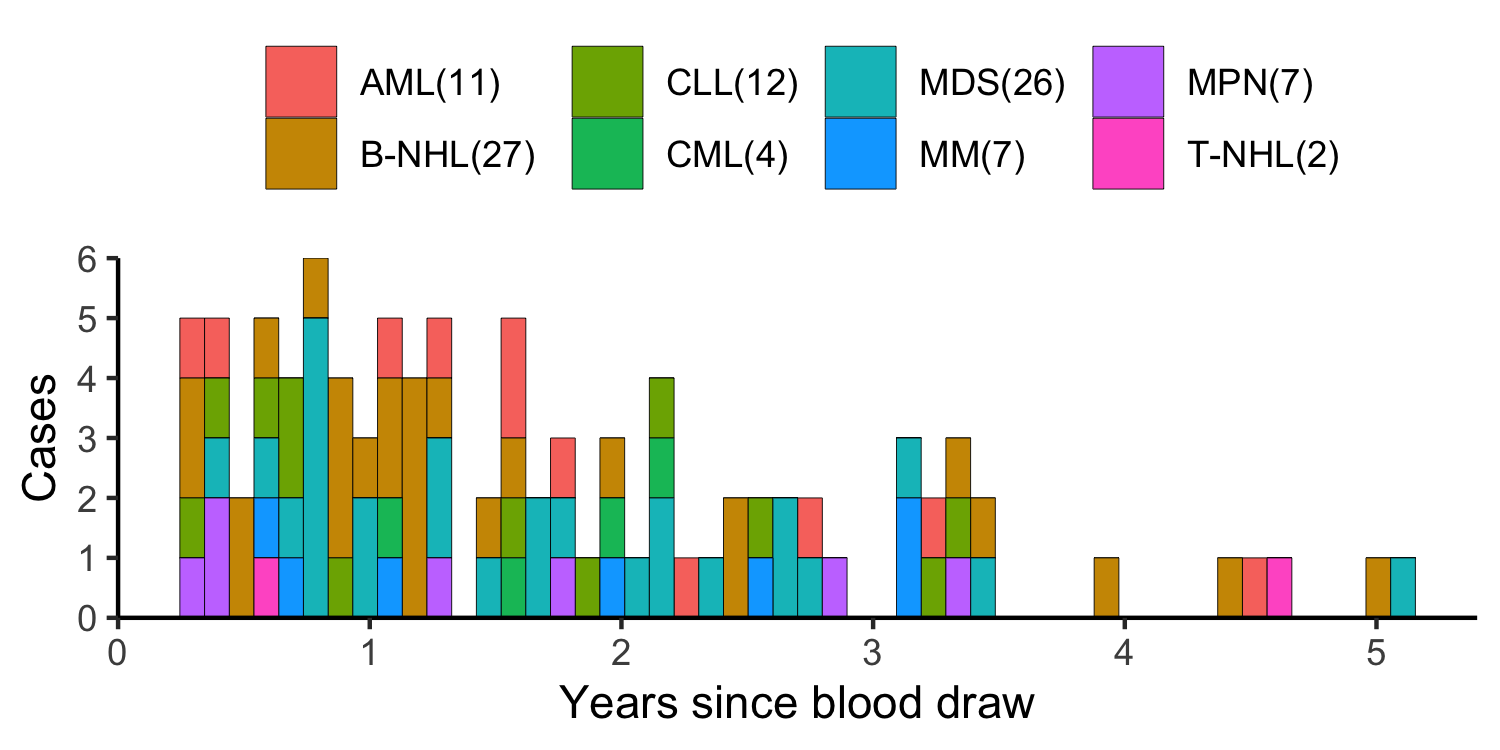

In [174]:
p = ggplot(
    M_wide %>% 
    filter(!is.na(heme_cat2)) %>% 
    group_by(heme_cat2) %>%
    mutate(n_heme_cat = n()) %>%
    ungroup() %>%
    mutate(heme_cat2 = glue('{heme_cat2}({n_heme_cat})')) %>%
    mutate(seq_to_diag = seq_to_diag/365),
    aes(x = seq_to_diag, fill = heme_cat2)
) +
geom_histogram(bins = 50, color = 'black', size = 0.1) +
scale_y_continuous(expand = c(0,0)) +
xlab('Years since blood draw') +
theme_classic() +
theme(
    legend.title = element_blank(),
    legend.position = 'top'
) +
ylab('Cases')

do_plot(p, 'diagnosis.pdf', w = 5, h = 2.5)

Warning message:
“Removed 51 rows containing missing values (geom_tile).”
Warning message:
“Removed 51 rows containing missing values (geom_tile).”


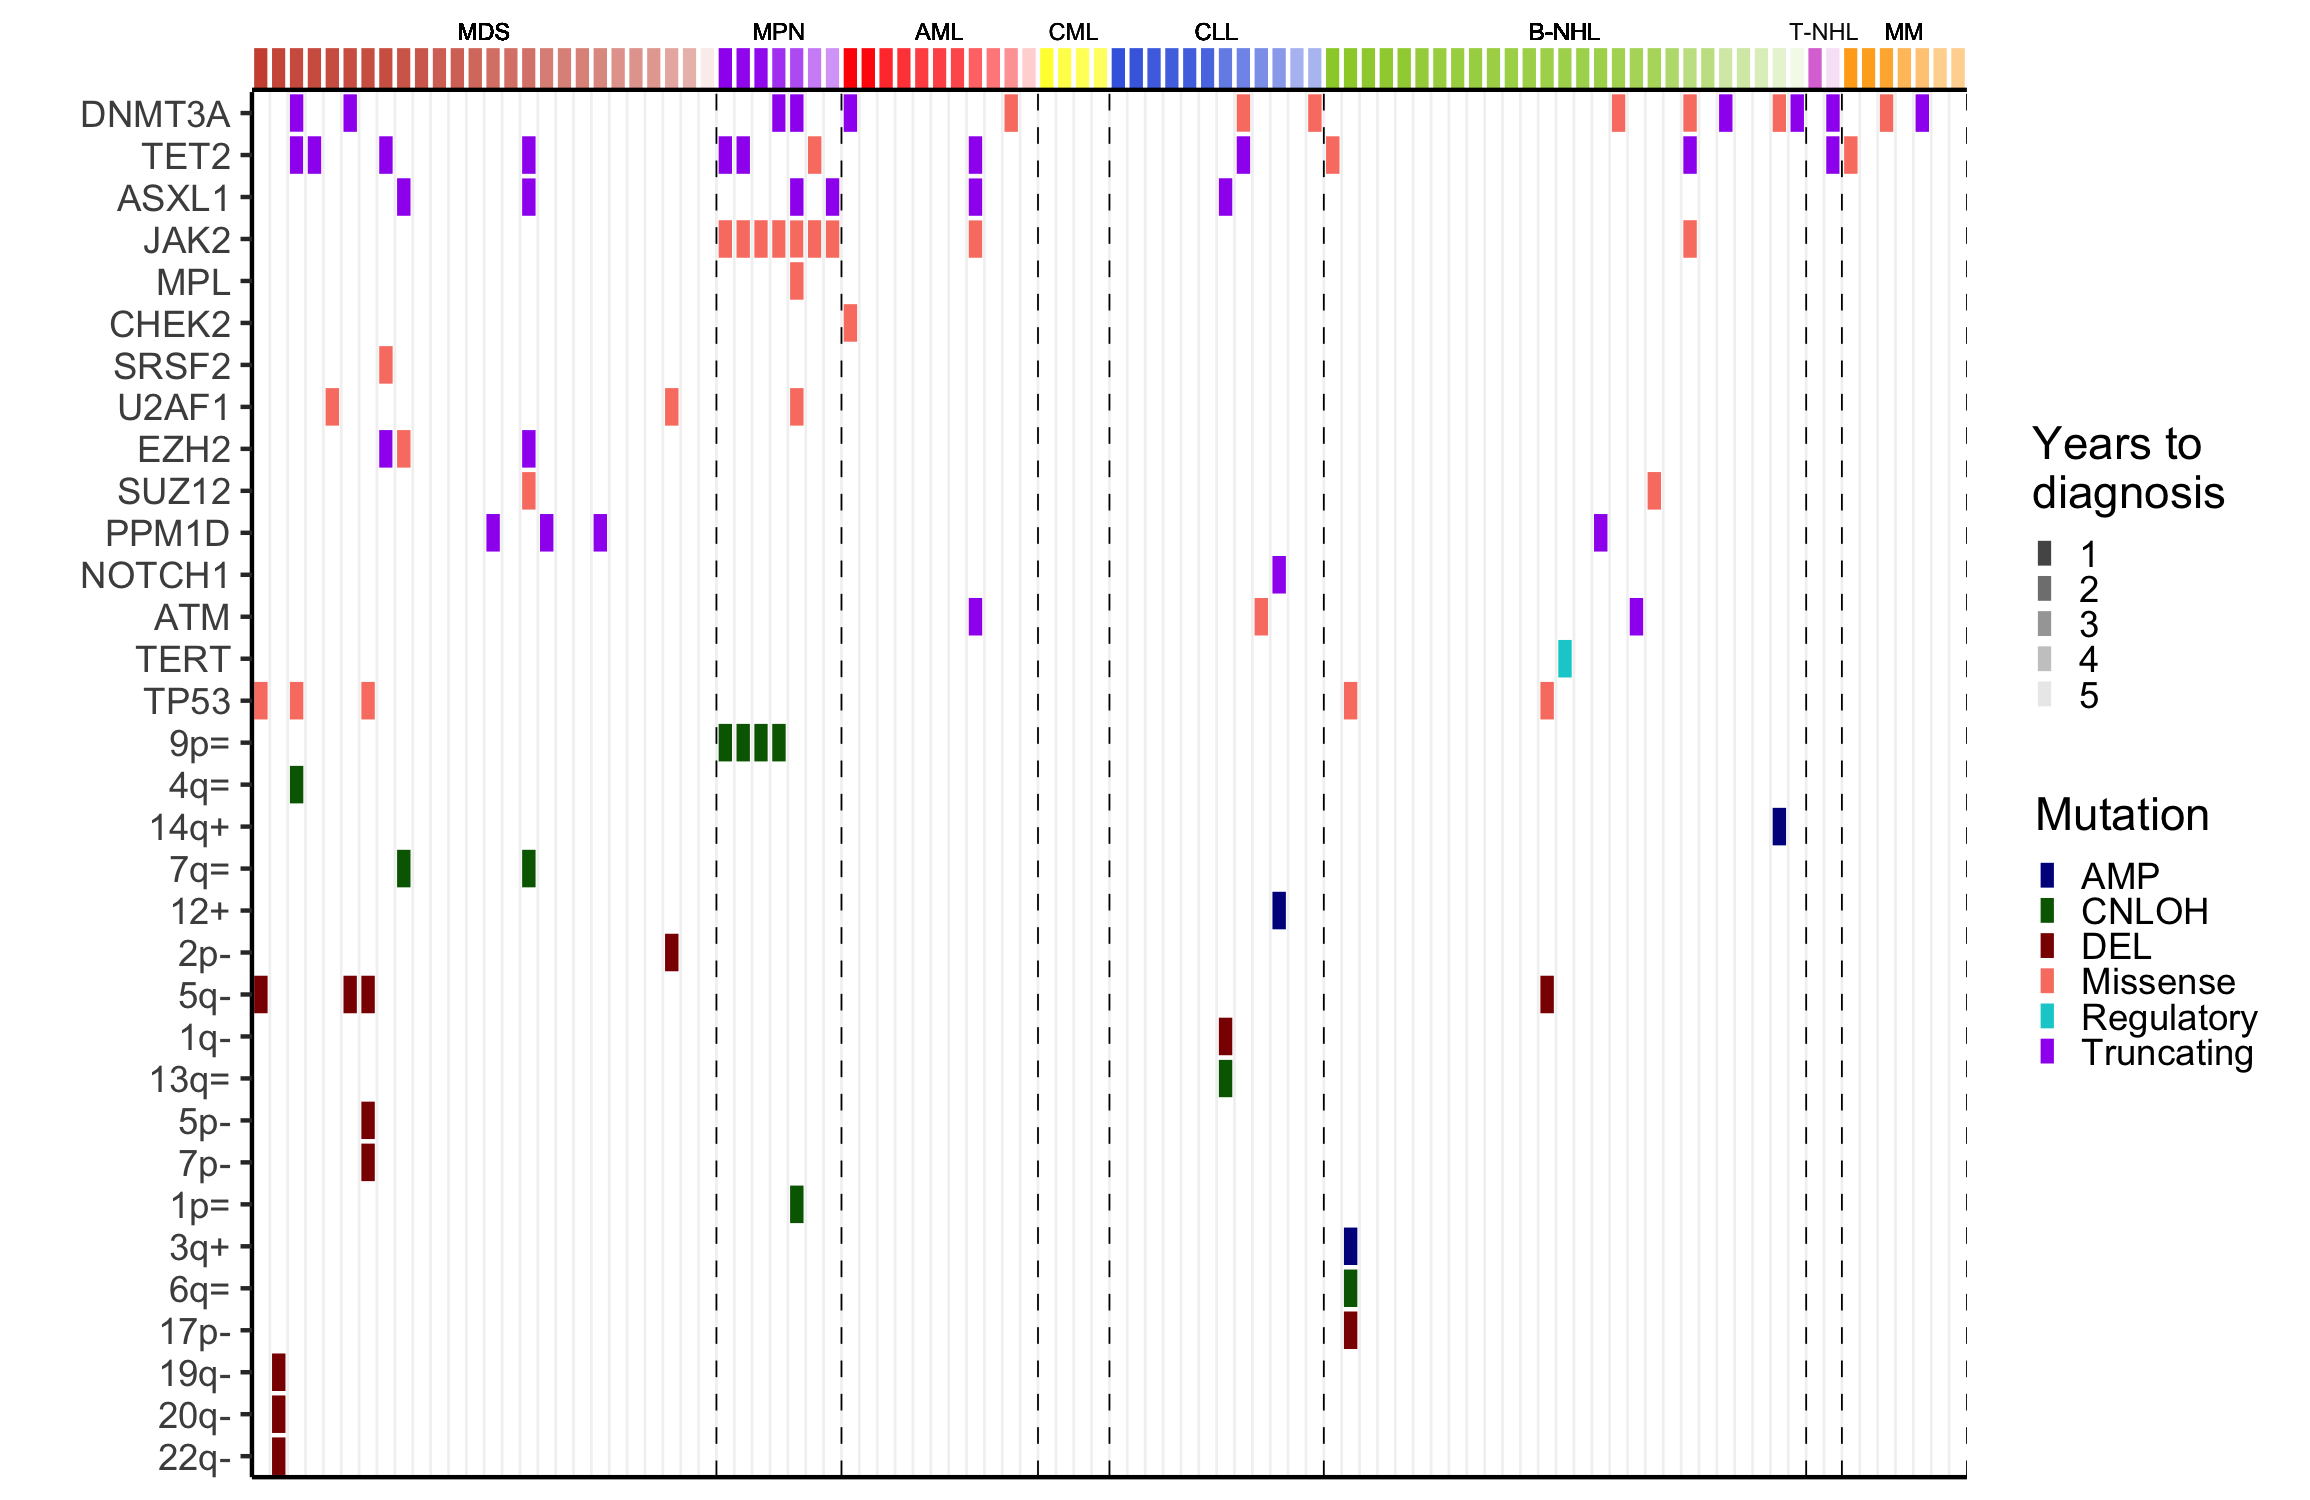

In [177]:
gene_set = c('DNMT3A', 'TET2', 'JAK2', 'ASXL1', 'TP53', 'ATM', 'PPM1D', 'CHEK2',
             'SRSF2', 'SF3B1', 'U2AF1', 'EZH2', 'MPL', 'NOTCH1', 'TERT', 'SUZ12', 'CBL')

patients_heme = M_wide %>% filter(post_heme == 1) %>% pull(dmp_patient_id)

segs_auto = segs_filtered %>% filter(chrom != '23')

M_co = rbind(
        M_long %>% 
        filter(Gene %in% gene_set) %>%
        filter(ch_nonsilent == 1 | VariantClass == 'Addition') %>%
        mutate(
            mutation = Gene,
            type = VariantClass2,
            arm = 'na',
            focality = 'na'
        ) %>%
        rowwise() %>% mutate(phi = min(VAF_N * 2, 1)) %>% ungroup() %>%
        select(mutation, phi, type, arm, focality, dmp_patient_id),
        segs_auto %>% 
        mutate(type_label = c('loh' = '=', 'del' = '-', 'amp' = '+')[type]) %>%
        mutate(mutation = paste0(chrom, ifelse(arm == 'p,q', '', arm), type_label)) %>%
        select(mutation, phi, type = type2, arm, focality, dmp_patient_id)
    ) %>%
    filter(dmp_patient_id %in% patients_heme) %>%
    full_join(
        M_wide %>% filter(post_heme == 1) %>%
            select(dmp_patient_id, heme_cat, seq_to_diag),
        by = 'dmp_patient_id'
    ) %>%
    filter(heme_cat != 'LCH') %>%
    mutate(
        heme_cat = ifelse(heme_cat %in% c('ET', 'PV'), 'MPN', heme_cat),
        heme_cat = ifelse(heme_cat %in% c('ALCL', 'CTCL'), 'T-NHL', heme_cat),
        heme_cat = ifelse(heme_cat %in% c('DLBCL', 'FL', 'MZL', 'PCNSL', 'WM'), 'B-NHL', heme_cat)
    ) %>%
    mutate(heme_cat = factor(heme_cat, c('MDS', 'MPN', 'AML', 'CML', 'CLL', 'B-NHL', 'T-NHL', 'MM'))) %>%
    mutate(mutation = ifelse(is.na(mutation), 'none', mutation))

M_co = M_co %>% mutate(
    class = case_when(
        mutation %in% c('JAK2', 'MPL', 'CHEK2', '9ploh') ~ 'MPN',
        mutation %in% c('TP53') ~ 'TP53',
        mutation %in% c('EZH2', 'SRSF2', 'U2AF1', 'SF3B1', 'ASXL1', 'SUZ12') ~ 'MDS',
        mutation %in% c('PPM1D', '7qdel') ~ 'CMML',
        mutation %in% c('NOTCH1', '12amp', '19amp', 'ATM', 'MYD88') ~ 'CLL',
        T ~ 'other'
    ),
    class_rank = as.integer(factor(class, c('MPN', 'TP53', 'MDS', 'CMML', 'CLL', 'other')))
)

mutation_order = c('DNMT3A', 'TET2', 'ASXL1', 'JAK2', 'MPL', 'CHEK2',
                   'SRSF2', 'SF3B1', 'U2AF1', 'EZH2', 'SUZ12', 'PPM1D', 'NOTCH1','ATM',
                   'MYD88', 'TERT', 'TP53')

mutation_other = M_co %>% filter(!mutation %in% mutation_order) %>% pull(mutation) %>% unique

mutation_order = c(mutation_order, mutation_other)

D = M_co %>%
#     filter(type == 'snv') %>%
    distinct(mutation, dmp_patient_id, `.keep_all` = T) %>%
    group_by(mutation) %>% mutate(mutation_n = n()) %>% ungroup() %>%
    arrange(class_rank, mutation != 'EZH2', desc(mutation_n)) %>%
    mutate(mutation = factor(mutation, rev(unique(mutation)))) %>% 
    rowwise() %>%
    mutate(mut_weight = 2^which(mutation == levels(mutation))) %>%
    ungroup() %>%
    group_by(dmp_patient_id) %>% 
    mutate(patient_weight = sum(mut_weight)) %>%
    ungroup() %>%
    group_by(dmp_patient_id) %>% 
    mutate(patient_group = min(class_rank)) %>%
    ungroup() %>%
    arrange(heme_cat, seq_to_diag, desc(patient_weight), type) %>%
    mutate(pid = as.integer(factor(dmp_patient_id, unique(dmp_patient_id)))) %>%
    mutate(mutation = as.character(mutation)) %>%
    mutate(mutation = ifelse(mutation == 'none', NA, mutation)) %>%
    mutate(mutation = factor(mutation, rev(mutation_order))) %>%
    mutate(mutation_i = as.integer(mutation))

p_mat = ggplot(
        D,
        aes(x = pid, y = mutation, fill = type)
    ) +
    geom_tile(color = 'white', size = 0.5) +
    geom_vline(
        aes(xintercept = pid - 0.5), color = 'gray95', size = 0.3
    ) +
#     geom_hline(
#         yintercept = length(levels(D$mutation)) - 1 - c(2.5), color = 'gray80',
#     ) +
    theme_classic() +
    theme(
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        plot.margin = unit(c(0,0,0,0), 'mm'),
        legend.key.size = unit(2, 'mm')
    ) +
    geom_vline(xintercept = cumsum(
        D %>% distinct(pid, heme_cat) %>% count(heme_cat) %>% pull(n)
    ) + 0.5, size = 0.2, linetype = 'dashed') +
    scale_fill_manual(
        values = c(cnv_pal2, sm_pal),
        na.translate = FALSE
    ) +
    scale_color_manual(
        values = c(cnv_pal2, sm_pal),
        na.translate = FALSE
    ) +
    scale_x_discrete(expand = expansion(add = 0)) +
    scale_y_discrete(expand = c(0.01,0), na.translate = FALSE) +
    xlab('') +
    scale_alpha_continuous(range = c(0.4,1)) +
    labs(alpha = 'Cell fraction') +
    labs(fill = 'Mutation') +
    ylab('')

p_heme = D %>% 
    mutate(seq_to_diag = seq_to_diag/365) %>%
    distinct(dmp_patient_id, pid, heme_cat, seq_to_diag) %>% 
    group_by(heme_cat) %>%
    mutate(label_pos = median(pid)) %>%
    ungroup %>%
    ggplot(
        aes(x = pid, y = 1, fill = heme_cat, alpha = seq_to_diag)
    ) +
    geom_tile(color = 'white', size = 0.5, show.legend = T) +
#     geom_vline(xintercept = cumsum(
#         D %>% distinct(pid, heme_cat) %>% count(heme_cat) %>% pull(n)
#     ) + 0.5, size = 0.2, linetype = 'dashed') +
    geom_rect(xmin = 0, xmax = max(D$pid) + 0.5, ymin = 1.5, ymax = 3, fill = 'white', show.legend = F) +
    geom_hline(yintercept = 0.5, size = 1) +
    geom_text(
        aes(x = label_pos, y = 2, label = heme_cat),
        color = 'black',
        vjust = 1,
        size = 2,
        show.legend = F
    ) +
    theme_void() +
    theme(
        axis.text.x = element_blank(),
        legend.key.size = unit(2, 'mm'),
        plot.margin = unit(c(0,0,0,0), 'mm'),
        legend.margin = margin(l = 1.7,1,1,1, "mm")
    ) +
    scale_x_discrete(expand = expansion(add = 0)) +
    scale_y_discrete(expand = expansion(add = 0)) +
    ylab('') +
    scale_fill_manual(
        values = c(' ' = 'white', 'CLL' = 'royalblue', 'MDS' = 'tomato3', 'CML' = 'yellow',
                   'AML' = 'red', 'MPN' = 'purple', 'B-NHL' = 'yellowgreen', 'T-NHL' = 'orchid', 'MM' = 'orange')
    ) +
    scale_alpha_continuous(trans = 'reverse') +
    labs(alpha = "Years to \ndiagnosis") +
    guides(fill = FALSE)

panel = (p_heme / p_mat) + plot_layout(heights = c(1,20), guides = 'collect')

do_plot(panel, 'heme_heatmap.pdf', w = 7.7, h = 5)

## Risk models

In [178]:
betas = data.frame()

for (landmark in seq(90, 360, 90)) {
    
    D = M_wide %>% 
        filter(time_leukemia > landmark) %>%
        mutate(time_leukemia = time_leukemia - landmark) %>%
        rowwise() %>%
        mutate(
#             VAF_pd_10 = min(VAF_pd, 0.5)/0.1,
            VAF_pd_10 = VAF_pd/0.1
        ) %>%
        ungroup()
    
    fit = coxph(Surv(time_leukemia, post_leukemia) ~ ch_cnv_auto + VAF_pd_10 + mutnum_pd + age, data = D, na.action = 'na.omit')
    
    cox.sum = sjPlot::get_model_data(fit, type = 'est') %>% mutate(with_cnv = 0, landmark = landmark)
    
    betas = rbind(
        betas,
        cox.sum
    )
}

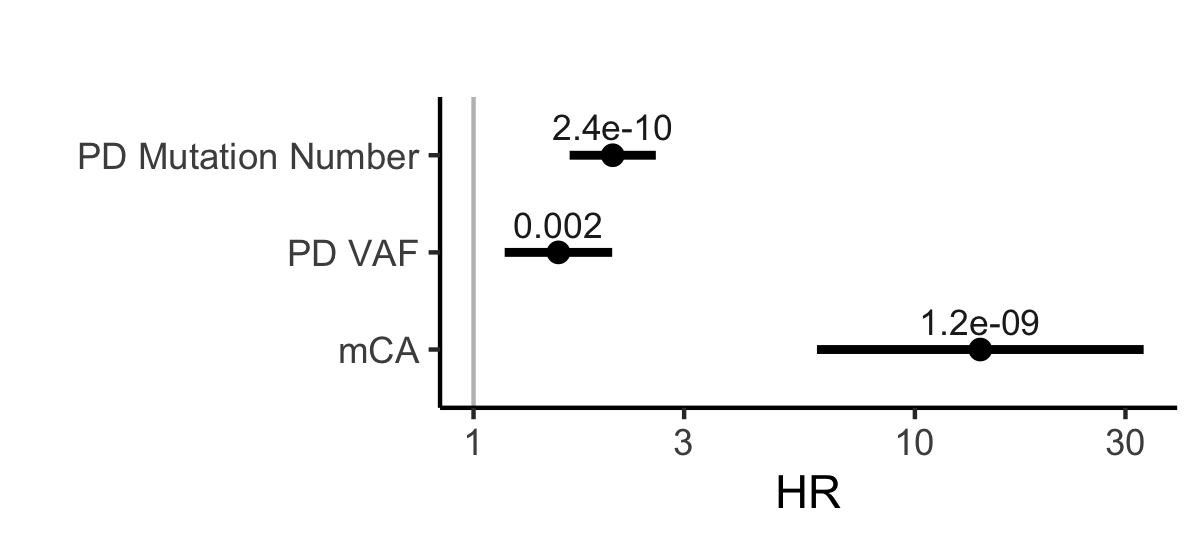

In [179]:
options(repr.plot.width = 4, repr.plot.height = 2, repr.plot.res = 300)

p = betas %>%
    filter(landmark == 270) %>%
    filter(!(term %in% c('GenderMale', 'age'))) %>%
    mutate(landmark = paste0(landmark, ' days')) %>%
    mutate(landmark = factor(landmark, unique(landmark))) %>%
    mutate(term = c('VAF_pd_10' = 'PD VAF', 'mutnum_pd' = 'PD Mutation Number', 'ch_cnv_auto' = 'mCA')[as.character(term)]) %>%
    mutate(term = factor(term, unique(term))) %>%
    mutate(format.p.value = format.pval(p.value, digits = 2)) %>% 
    plot_forest(
        x = 'term',
        label = 'format.p.value',
        eb_w = 0,
        eb_s = 1,
        ps = 2,
        or_s = 3,
        nudge = -0.6
    ) +
    theme_classic() +
    ylab('HR') +
    xlab('')

do_plot(p, 'cox_pvalue.pdf', w = 4, h = 1.8)

## Cumulative incidence

In [184]:
library(prodlim)
library(cmprsk)

data002 = fread("../data/Fig_4C.tsv")

In [187]:
cmv <- prodlim(Hist(YearstoAnalysis, EventAnalysis) ~CH, data=data002)
summary(cmv,3) ### if the lower confidence interval =0 in the output just put at <0.001 



----------> Cause:  1 

CH=GM ONLY :
  time n.risk n.event n.lost  cuminc se.cuminc   lower   upper
1    3    815       0      3 0.00346   0.00109 0.00133 0.00559

CH=mCA ONLY :
  time n.risk n.event n.lost  cuminc se.cuminc lower  upper
1    3     22       0      0 0.00647   0.00645     0 0.0191

CH=mCA+GM :
  time n.risk n.event n.lost cuminc se.cuminc  lower upper
1    3     12       0      0  0.146    0.0397 0.0686 0.224

CH=None :
  time n.risk n.event n.lost  cuminc se.cuminc   lower   upper
1    3   4686       0      8 0.00169  0.000338 0.00102 0.00235



----------> Cause:  2 

CH=GM ONLY :
  time n.risk n.event n.lost cuminc se.cuminc lower upper
1    3    815       0      3  0.545   0.00875 0.528 0.563

CH=mCA ONLY :
  time n.risk n.event n.lost cuminc se.cuminc lower upper
1    3     22       0      0    0.5    0.0488 0.404 0.595

CH=mCA+GM :
  time n.risk n.event n.lost cuminc se.cuminc lower upper
1    3     12       0      0  0.521    0.0591 0.405 0.637

CH=None :
  tim

In [189]:
par(mar = c(3,2,1,1))

pdf(file = '../figures/cum_inc.pdf', width = 6, height = 6)

plot(cmv, 
     xlim=c(0, 4), ylim=c(0,0.25),
     xlab = "Years from blooddraw", ylab = "Cumulative Incidence",
     atRisk.at = seq(0, 4, 1),
     axis1.at = seq(0, 4, 1),
     atrisk.labels = "",  
     legend.cex = 1,
     col = c('#abdda4', '#2b83ba','#fdae61', '#d7191c'),
     legend.x="topleft") 
title(main="", cex=3)

dev.off()

display_pdf(file = '../figures/cum_inc.pdf')

pdf 
  2

In [190]:
## P-value
print(cuminc(data002$YearstoAnalysis, data002$EventAnalysis, data002$CH))
## P-value is <0.001 [corresponding test statistics is 174.7842, under 3 d.f.s

3 cases omitted due to missing values
Tests:
      stat pv df
1 867.4312  0  3
2 127.7665  0  3
Estimates and Variances:
$est
                      1           2           3           4           5
GM ONLY 1  0.0008483407 0.001463356 0.003462066 0.004811257 0.004811257
mCA ONLY 1 0.0064725871 0.006472587 0.006472587 0.006472587 0.006472587
mCA+GM 1   0.0719910198 0.125408042 0.146466522 0.174168451          NA
None 1     0.0003060817 0.001065630 0.001686761 0.002109365 0.002474751
GM ONLY 2  0.2690778071 0.446743001 0.545409507 0.610260933 0.668383542
mCA ONLY 2 0.2687343383 0.418719859 0.499820374 0.552717557 0.662920021
mCA+GM 2   0.1914065690 0.434278287 0.521110331 0.554968244          NA
None 2     0.2048189115 0.363556845 0.462791337 0.534112619 0.594110056
                     6
GM ONLY 1           NA
mCA ONLY 1          NA
mCA+GM 1            NA
None 1     0.003258557
GM ONLY 2           NA
mCA ONLY 2          NA
mCA+GM 2            NA
None 2     0.636721467

$var
             